# Predicting the Helpfulness of Amazon Reviews
### Keane Johnson and Tucker Anderson

This notebook builds multiple models that predict the helpfulness of Amazon reviews. It uses the [2015 Amazon Review dataset](http://jmcauley.ucsd.edu/data/amazon/index.html), compiled by Julian McAuley, associate professor in the Computer Science department at the University of California, San Diego.

The dataset contains product reviews from Amazon from May 1996 - July 2014, and includes ratings, text, helpfulness votes, descriptions, category information, price, brand, and image features. It is broken into smaller subsets, organized by product category.

This notebook focuses on the Home and Kitchen sub-category, and uses the aforementioned features to predict helpfulness.

## Outline
- Import Libraries
- Load and Prepare Dataset
- Exploratory Data Analysis
- Model 1: Every review is 100% helpful
- Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels
- Model 3: TFIDF and Logistic Regression
- Model 4: BERT

## Import Libraries

In [5]:
# load packages
import gzip
import json
import os
import wget

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
random.seed(42)

## Load and Prepare Dataset

In [6]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Home_and_Kitchen_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [7]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    
    df_return = pd.DataFrame.from_dict(df, orient='index')
    #shuffle all records to reduce bias of order of data
    df_return = df_return.sample(frac=1)
    
    return df_return


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

In [8]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [9]:
df.shape

(551682, 12)

The dataset contains 551,682 rows and twelve columns.

In [6]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
438202,A1UY3S4OR2ZLK4,B005DN65WG,John L,"[0, 0]",These mattress protector are terrific. Unlike ...,5.0,Terrific Product,1391126400,"01 31, 2014",0,0,0.000000
471318,A30WZ2LGA8VVPR,B0077L8YFI,Jonathan,"[0, 0]","Pros: Really loved the look, it wasn't too dif...",1.0,Was disappointed so I returned it. The weight...,1396310400,"04 1, 2014",0,0,0.000000
68407,ATS3U1L4F89VQ,B0000DE9B8,Diane,"[2, 4]",You really can't go wrong with a glass measuri...,5.0,You Can't Go Wrong,1124409600,"08 19, 2005",2,4,0.500000
401258,A2JSKM60VTCNI,B004CLYAM2,"Paul Stuart ""&#34;...also I'll brush my teeth...","[8, 13]",Reviewer Disclaimer: This was received as a Re...,3.0,"Crisp, clean air in a sleek package...but bett...",1341446400,"07 5, 2012",8,13,0.615385
548589,A1JBBR4MNGQ70G,B00J7XVNAM,Falkor The White Luck Dragon,"[2, 2]",I needed a window air conditioner as the upsta...,5.0,Just What I Was Looking For,1402358400,"06 10, 2014",2,2,1.000000


The twelve columns contain data including the reviewer name and review time, in addition to more applicable data to our models, like review text, summary, and helpful scores. The helpful column is a list of two numbers. The first number is the number of individuals who found that review helpful. The second number is the total number of individuals who scored that review.

We parse out these two numbers in helpful_votes and total_votes. We calculate the helpfulness percentage as well in helpful_perc. This is simply the number of helpful_votes divided by the number of total_votes. Helpful_perc will be our target variable in our models.

There are two sources of natural language in the dataset - reviewText and summary. We assume the reviewText will be more robust and impactful in determining whether a review is helpful or not. However, summary is a good resource for our models as well.

Next, we want to examine the completeness of our dataset.

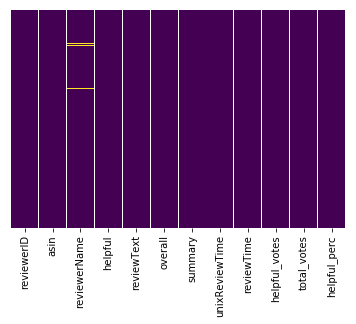

In [7]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

This heatmap shows that there are missing values for some observations of reviewerName. However, with such a large dataset, we could be missing some values for other features that just do not appear on this chart

In [8]:
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,4953
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


We confirm that we are only missing values for reviewerName. We reason that this does not have an impact on our analysis because we will be using primarily the reviewText, and possibly the summary, to determine a review's helpfulness. Additionally, we argue that individuals do not consistently use a reviewer's name when determining a review's helpfulness.

### Summary Statistics

After reviewing some sample data, and examining missing values, we next look at some summary statistics of our dataset.

In [9]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,551682.000000,5.516820e+05,551682.000000,551682.000000,551682.000000
mean,4.316655,1.348687e+09,3.497348,3.939469,0.367910
std,1.110749,6.120238e+07,76.539142,77.801556,0.456931
min,1.000000,9.572256e+08,0.000000,0.000000,0.000000
25%,4.000000,1.331770e+09,0.000000,0.000000,0.000000
50%,5.000000,1.367626e+09,0.000000,0.000000,0.000000
75%,5.000000,1.388880e+09,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,52176.000000,52861.000000,1.000000


These summary statistics show that over half of our observations have a 0% helpfulness. In addition, these observations have zero total votes. This means that the reviews simply haven't been voted upon. We should remove these observations from our dataset because our model could misinterpret the 0% helpful_perc to mean that the review was not helpful when in fact the review just hasn't been voted upon.

### Examining the Target Variable

We can use a histogram to visualize the distribution of helpful percentages.

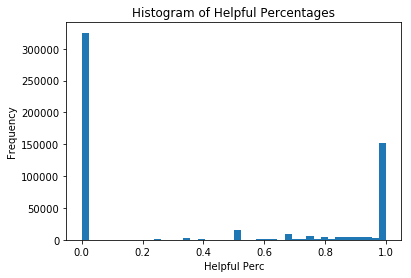

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

This histogram shows that the majority of reviews have a 0% helpful percentage, with the second most prevalent percentage being 100%. However, our dataset needs to be cleaned to remove observations that may add noise, but do not add meaning.

### Data Cleaning

We want to be purposeful with the data that we are supplying to our model. We want to only analyze reviews where there are at least three total votes, or reviews where there are two total votes, but both votes are in agreement.

Our rationale is that two total votes that are split does not tell us much. However, if both are an agreeement, that could tell us something about a reviews helpfulness.

In [14]:
# subset df of reviews that have at least three votes
df_three = df[df.total_votes >= 3]

# subset df of reviews that have two both and both are in agreeement
df_two = df[((df.total_votes == 2) & (df.helpful_perc == 1)) | ((df.total_votes == 2) & (df.helpful_perc == 0))]

# combine the dfs back together
df = df_three.append(df_two, ignore_index=True)
df.shape

(139470, 12)

The size of our dataset is now 139,470 rows. Next we can examine the new distribution of helpful_perc.

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,139470.000000,1.394700e+05,139470.000000,139470.000000,139470.000000
mean,3.988270,1.301792e+09,13.178676,14.704022,0.848035
std,1.356746,8.137408e+07,151.811710,154.232187,0.242654
min,1.000000,9.572256e+08,0.000000,2.000000,0.000000
25%,3.000000,1.261181e+09,2.000000,3.000000,0.750000
50%,5.000000,1.324080e+09,4.000000,5.000000,1.000000
75%,5.000000,1.362874e+09,9.000000,10.000000,1.000000
max,5.000000,1.405728e+09,52176.000000,52861.000000,1.000000


The median helpful_perc is 100%. We could be at risk of not having a good distribution of data to train on. This could result in our model being overly optimistic and inflating the helpfulness scores of reviews. We can visualize this skew with another histogram.

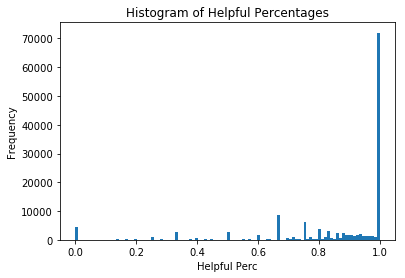

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Data Subsetting

Due to resource constraints, we'll subset our data to roughly half the original size. This is still more than enough data to build and test our models.

In [15]:
df_sampled = df.sample(80000)
df_sampled.shape

(80000, 12)

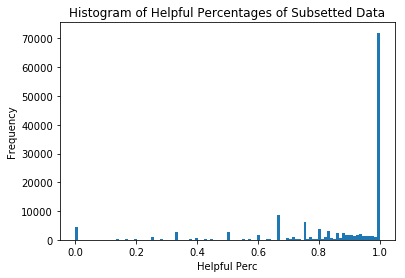

In [15]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(1, 1, 1)
n, bins, patches = ax3.hist(x=df['helpful_perc'], bins='auto')
                                 
ax3.set_xlabel('Helpful Perc')
ax3.set_ylabel('Frequency')
ax3.set_title('Histogram of Helpful Percentages of Subsetted Data')

The distribution of the sampled data visually matches the distribution of the original dataset. We can confirm the distributions are identical with the Kolmogorov-Smirnov statistic.

In [16]:
from scipy.stats import ks_2samp

df_sampled_helpful_prec = df_sampled['helpful_perc']
df_helpful_perc = df['helpful_perc']

ks_2samp(df_sampled_helpful_prec, df_helpful_perc)

Ks_2sampResult(statistic=0.0018642270739226974, pvalue=0.9944665853896963)

In [17]:
# df_sampled becomes our df
df = df_sampled

## Model 1: Every Review is Helpful

The most basic model we can produce is to label each review as being helpful if it meets a certain helpful_perc threshold. We choose 75%.

In [18]:
# calculate total number of reviews
total_reviews = len(df)

# calculate total number of reviews that are at least 75% helpful
helpful_reviews = len(df[df.helpful_perc >= 0.75])

# calculate accuracy if we predicted each review is at least 75% helpful
accuracy_1 = 100*(helpful_reviews/total_reviews)

print("Every Review is Helpful Accuracy Score -> ", accuracy_1)

Every Review is Helpful Accuracy Score ->  79.21125


This model would produce an accuracy score of 79.3%.

## Model 2: Naive Bayes Bag of Words with Binary Helpfulness Labels

A more sophisticated model is one where we estimate the hepfulness of a review using its text. We use a Bag of Words model to determine whether a review is helpful or not. We again define a helpful review as one whose helpfulness percentage is at least 75%.

### Data Pre-Processing

In [19]:
import nltk
# this nltk download may be needed. download stopwords, punkt
# nltk.download()

In [20]:
# ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

For our bag of words model, we will combine the reviewText and summary text fields to combine into a single "document" with which to analyze.

In [21]:
#nltk.download()

In [22]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [23]:
# We should then tokenize and stem the review data before ingesting into our NLP models
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()

# Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

In [24]:
# Create new column for helpful reviews (reviews with at least a 75% helpfulness rating)

df["isHelpful"] = df["helpful_perc"] > .75
df["isHelpful"] = df["isHelpful"].apply(int)

In [25]:
#let's make sure everything looks ok
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc,combinedText,processedText,isHelpful
106615,A1FNLY02ZH11MW,B00E58P7ME,J. VanGoethem,"[3, 4]","Yes, it costs too much for a $.25 worth of met...",4.0,Does the job,1315699200,"09 11, 2011",3,4,0.750000,"does the job. yes, it costs too much for a $.2...","[job, ., yes, ,, costs, much, $, .25, worth, m...",0
61951,A22MANL4US4RMY,B001V4VMRO,Book Carpenter,"[2, 3]","This cover is a nice, tight fit, and it seems ...",5.0,"Good Fit, Good Construction",1314144000,"08 24, 2011",2,3,0.666667,"good fit, good construction. this cover is a n...","[good, fit, ,, good, construction, ., cover, n...",0
119108,A3NT7RAITJZXXT,B000GX4CKA,"Linda ""cooking enthusiast""","[2, 2]",While this is a good shelf for the price it wo...,3.0,No instructions included,1279929600,"07 24, 2010",2,2,1.000000,no instructions included. while this is a good...,"[instructions, included, ., good, shelf, price...",1
15628,A1VB2KE2PR4J4W,B0000CFNQX,J. J. Emmel,"[3, 4]","It's made in China, a tad small, but not bad f...",3.0,not bad for made in China,1329177600,"02 14, 2012",3,4,0.750000,"not bad for made in china. it's made in china,...","[bad, made, china, ., 's, made, china, ,, tad,...",0
99353,A2QFO64UAU5N18,B008R3ER0Q,"W. Lucas ""wvl""","[2, 4]",This thing is very weak on the suction. I read...,1.0,"Must have gotten a bad one, because",1388361600,"12 30, 2013",2,4,0.500000,"must have gotten a bad one, because. this thin...","[must, gotten, bad, one, ,, ., thing, weak, su...",0


Text(0.5, 1.0, 'Histogram of Helpful/Not Helpful Reviews')

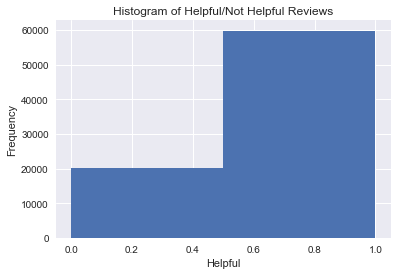

In [26]:
# take a look at distribution of Helpful/Not Helpful

fig4 = plt.figure()
ax4 = fig4.add_subplot(1, 1, 1)
n, bins, patches = ax4.hist(x=df['isHelpful'], bins=2)
                                 
ax4.set_xlabel('Helpful')
ax4.set_ylabel('Frequency')
ax4.set_title('Histogram of Helpful/Not Helpful Reviews')

In [27]:
from sklearn import preprocessing

data = df[['combinedText', 'isHelpful']]

le = preprocessing.LabelEncoder()
preprocessed_data = data.apply(le.fit_transform)

In [26]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(preprocessed_data['combinedText'], 
                                                    preprocessed_data['isHelpful'],
                                                    test_size=0.2)

NameError: name 'preprocessed_data' is not defined

In [29]:
# and train our classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

g_classifier = GaussianNB().fit(np.array(Train_X.values.tolist()).reshape(-1, 1), Train_Y)
accuracy_2 = accuracy_score(Test_Y, g_classifier.predict(np.array(Test_X.values.tolist()).reshape(-1, 1)))*100

print("Gaussian Naive Bayes Accuracy Score -> ", accuracy_2)

Gaussian Naive Bayes Accuracy Score ->  74.76875


Our Naive Bayes Bag of Words model performs worse than our previous "every review is helpful" baseline model. It produces an accuracy score of 75.3%, down from 79.3%.

## Model 3: TF-IDF and Logistic Regression

In [30]:
# import packages
import sklearn
import string

from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression

In [31]:
# split into train/validation/test sets
data = df[['combinedText', 'isHelpful']]

df_train, df_test = train_test_split(data, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [32]:
# stem combinedText to reduce size of corpus
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stem_text(df):
    text_list = df['combinedText'].tolist()
    text_list_stem = [None] * len(text_list)

    for i in range(len(text_list)):
        text_list_stem[i] = ' '.join([porter.stem(w) for w in text_list[i].split()])
    
    return text_list_stem

text_list_stem = stem_text(data)

In [33]:
# vectorize text
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
                max_features=100,
                ngram_range=(1,1)
                )

vectorizer.fit_transform(text_list_stem).toarray()

array([[0.03389221, 0.07340804, 0.03054271, ..., 0.03196743, 0.099017  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19454242, 0.        , 0.        , ..., 0.        , 0.14209024,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.26798256,
        0.        ],
       [0.03311168, 0.07171747, 0.08951795, ..., 0.        , 0.145105  ,
        0.14716066],
       [0.        , 0.        , 0.18267261, ..., 0.        , 0.14805248,
        0.        ]])

In [34]:
# vectorize train dataset
train_text_stem = stem_text(df_train)
train_vectorized = vectorizer.transform(train_text_stem).toarray()

print('Shape:', train_vectorized.shape)

Shape: (51200, 100)


In [35]:
# vectorize val dataset
val_text_stem = stem_text(df_val)
val_vectorized = vectorizer.transform(val_text_stem).toarray()

print('Shape:', val_vectorized.shape)

Shape: (12800, 100)


In [36]:
# vectorize test dataset
test_text_stem = stem_text(df_test)
test_vectorized = vectorizer.transform(test_text_stem).toarray()

print('Shape:', test_vectorized.shape)

Shape: (16000, 100)


In [37]:
# create array of labels to use in logistic regression
df_train_labels = np.array(df_train['isHelpful'])
df_test_labels = np.array(df_test['isHelpful'])
df_val_labels = np.array(df_val['isHelpful'])

In [38]:
# train logistic regression
lr = LogisticRegression(penalty='l2')
lr.fit(train_vectorized, df_train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
# tune hyperparameters
reg_str = [0.01, 0.1, 1.0, 10, 100, 1000]

best_acc = -1
best_c = None

for r in reg_str:
    lr = LogisticRegression(penalty='l2', C=r)
    lr.fit(train_vectorized, df_train_labels)
    preds = lr.predict(val_vectorized)
    acc = np.mean(preds == df_val_labels)
    print('regularization strength:', r, ' ', 'validation set accuracy:', acc)
    
    if acc > best_acc:
        best_acc = acc
        best_c = r

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 0.01   validation set accuracy: 0.745546875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 0.1   validation set accuracy: 0.746796875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 1.0   validation set accuracy: 0.747265625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 10   validation set accuracy: 0.7475


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 100   validation set accuracy: 0.74765625


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


regularization strength: 1000   validation set accuracy: 0.74765625


In [40]:
# test accuracy
lr_final = LogisticRegression(penalty='l2', C = best_c)
lr_final.fit(train_vectorized, df_train_labels)

preds = lr_final.predict(test_vectorized)
accuracy_3 = 100*np.mean(preds == df_test_labels)

print("TF-IDF and Logistic Regression Accuracy Score ->", accuracy_3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TF-IDF and Logistic Regression Accuracy Score -> 74.99375


The model with term frequency–inverse document frequency and logistic regression produces a marginally higher accuracy than the Naive Bayes Bag of Words model, but it is still not higher than the rudimentary Every Review is Helpful model. This motivates the need for a more robust representation of the language in the reviews. Enter BERT.

## Model 4: BERT

Code built around Strongio's notebook here https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

### Tokenization

In [10]:
import sys
import os
import re

# if this doesnt work, ensure tensorflow is version <2.0
import tensorflow as tf
import tensorflow_hub as hub

from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

# Tensorflow hub path to BERT module of choice
BERT_DIR =  "./bert"
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 256

sys.path.insert(0,BERT_DIR)

# Initialize session, may need to remove config if no GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [11]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module(path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels, max_examples=None):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples[:max_examples]

In [12]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

# Now create the combinedText with casing and no longer than 512 characters (max of BERT embedding input)
df['combinedText'] = df['summary'] + ". " + df['reviewText']

#drop rows where no votes
kitchen_df = df.drop(df[df.total_votes == 0].index)

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(kitchen_df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [15]:
# Convert data to InputExample format, ensure we don't have too many examples to encounter memory issues
train_examples = convert_text_to_examples(df_train['combinedText'], df_train['helpful_perc'], max_examples=10000)
val_examples = convert_text_to_examples(df_val['combinedText'], df_val['helpful_perc'], max_examples=2000)
test_examples = convert_text_to_examples(df_test['combinedText'], df_test['helpful_perc'], max_examples=2000)

#make sure the test Y is the same format
test_actual = np.array(df_test['helpful_perc'][:2000])
test_actual = test_actual.reshape(-1,1)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### Neural Net Creation

In [16]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)
    
    def get_config(self):
        config = {'n_fine_tune_layers': self.n_fine_tune_layers,
                  'pooling': self.pooling,
                  'bert_path': self.bert_path}
        base_config = super(MyMeanPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
# Build model
def build_model(max_seq_length, model_loss, batch=False, CNN=False): 
    if CNN:
        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]

        bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(bert_output)
        flat = tf.keras.layers.flatten()(dense)
        conv = tf.keras.layers.Conv1D(8, 5, activation='relu')(flat)
        pred = tf.keras.layers.Dense(1, activation='sigmoid')(conv)

        model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
        model.compile(loss=model_loss, optimizer='adam')
        model.summary()
        
    else:
        in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
        in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
        in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
        bert_inputs = [in_id, in_mask, in_segment]

        bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(bert_output)
        pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
        model.compile(loss=model_loss, optimizer='adam')
        model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [18]:
# let's define some models!

#BCE Model: using BCE in regression https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders/370180#370180
model_BCE = build_model(MAX_SEQ_LENGTH, 'binary_crossentropy')
model_RMSE = build_model(MAX_SEQ_LENGTH, 'mean_squared_error')

# model_BCE_CNN = build_model(MAX_SEQ_LENGTH, 'binary_crossentropy', CNN=True)
# model_RMSE_CNN = build_model(MAX_SEQ_LENGTH, 'mean_squared_error', CNN=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]            

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

#### BCE Loss

In [19]:
#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_BCE.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=1,
    batch_size=8
)

Train on 10000 samples, validate on 2000 samples
10000/10000 [==============================] - 754s 75ms/sample - loss: 0.5014 - val_loss: 0.4950


In [22]:
# save weights
model_BCE.save_weights('./models/model_BCE')

In [23]:
#let's test the correlation coefficient
preds_BCE = model_BCE.predict([test_input_ids, test_input_masks, test_segment_ids])

In [30]:
np.corrcoef(preds_BCE.T, test_actual.T)

array([[1.        , 0.05203897],
       [0.05203897, 1.        ]])

#### RMSE Loss

In [31]:
# let's try RMSE
# Instantiate variables
initialize_vars(sess)

model_RMSE.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=1,
    batch_size=8
)

Train on 10000 samples, validate on 2000 samples
10000/10000 [==============================] - 790s 79ms/sample - loss: 0.1273 - val_loss: 0.1385


In [35]:
# save weights
model_RMSE.save_weights('./models/model_RMSE')

In [33]:
#let's test the correlation coefficient
preds_RMSE = model_RMSE.predict([test_input_ids, test_input_masks, test_segment_ids])

In [38]:
preds_RMSE

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [34]:
np.corrcoef(preds_RMSE.T, test_actual.T)

C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Tucker\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

In [53]:
#let's see if a different input length changes our model
MAX_SEQ_LENGTH = 512

# Convert data to InputExample format
train_examples = convert_text_to_examples(df_train['combinedText'], df_train['helpful_perc'], max_examples=10000)
val_examples = convert_text_to_examples(df_val['combinedText'], df_val['helpful_perc'], max_examples=2000)
test_examples = convert_text_to_examples(df_test['combinedText'], df_test['helpful_perc'], max_examples=2000)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer_4 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [ ]:
model_RMSE2 = build_model(MAX_SEQ_LENGTH, 'mean_squared_error')

#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_RMSE2.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=1,
    batch_size=8
)

In [65]:
#let's see if a different input length changes our model
MAX_SEQ_LENGTH = 256

# Convert data to InputExample format
train_examples = convert_text_to_examples(df_train['combinedText'], df_train['helpful_perc'])
val_examples = convert_text_to_examples(df_val['combinedText'], df_val['helpful_perc'])
test_examples = convert_text_to_examples(df_test['combinedText'], df_test['helpful_perc'])

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)

model_RMSE3 = build_model(MAX_SEQ_LENGTH, 'mean_squared_error')

#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_RMSE3.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=5,
    batch_size=8
)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [90]:
loss_RMSE3 = model_RMSE3.evaluate([test_input_ids, 
                       test_input_masks, 
                       test_segment_ids], test_labels)
print('Test loss:', loss_RMSE3)

16000/16000 [==============================] - 368s 23ms/sample - loss: 0.0832
Test loss: 0.08323233327269554


In [95]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [31]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

In [32]:
model_corrcoeff = build_model(MAX_SEQ_LENGTH, correlation_coefficient_loss)

#we can now finally build a model
# Instantiate variables
initialize_vars(sess)

model_corrcoeff.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=1,
    batch_size=1
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1203 09:45:20.537204 17564 saver.py:1483] Saver not created because there are no variables in the graph to restore


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

W1203 09:56:59.320878 17564 deprecation.py:323] From C:\Users\tla0113\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


  240/51200 [..............................] - ETA: 7657:12:50 - loss: 0.0000e+0 - ETA: 3833:47:13 - loss: 0.0000e+0 - ETA: 2559:16:58 - loss: 0.0000e+0 - ETA: 1921:48:37 - loss: 0.0000e+0 - ETA: 1539:25:13 - loss: 0.0000e+0 - ETA: 1284:26:38 - loss: 0.0000e+0 - ETA: 1102:18:14 - loss: 0.0000e+0 - ETA: 965:43:11 - loss: 0.0000e+0 - ETA: 859:31:33 - loss: 0.0000e+ - ETA: 774:31:40 - loss: 0.0000e+ - ETA: 704:58:02 - loss: 0.0000e+ - ETA: 647:04:20 - loss: 0.0000e+ - ETA: 598:06:14 - loss: 0.0000e+ - ETA: 556:05:04 - loss: 0.0000e+ - ETA: 519:37:15 - loss: 0.0000e+ - ETA: 487:43:30 - loss: 0.0000e+ - ETA: 459:41:04 - loss: 0.0000e+ - ETA: 434:42:41 - loss: 0.0000e+ - ETA: 412:26:39 - loss: 0.0000e+ - ETA: 392:20:25 - loss: 0.0000e+ - ETA: 374:23:10 - loss: 0.0000e+ - ETA: 357:58:41 - loss: 0.0000e+ - ETA: 343:12:31 - loss: 0.0000e+ - ETA: 329:25:25 - loss: 0.0000e+ - ETA: 316:40:09 - loss: 0.0000e+ - ETA: 304:53:59 - loss: 0.0000e+ - ETA: 294:00:44 - loss: 0.0000e+ - ETA: 283:58:47 - los

  480/51200 [..............................] - ETA: 43:30:39 - loss: 0.0000e+0 - ETA: 43:22:35 - loss: 0.0000e+0 - ETA: 43:14:12 - loss: 0.0000e+0 - ETA: 43:06:38 - loss: 0.0000e+0 - ETA: 42:58:34 - loss: 0.0000e+0 - ETA: 42:50:24 - loss: 0.0000e+0 - ETA: 42:42:15 - loss: 0.0000e+0 - ETA: 42:34:08 - loss: 0.0000e+0 - ETA: 42:26:00 - loss: 0.0000e+0 - ETA: 42:17:55 - loss: 0.0000e+0 - ETA: 42:10:04 - loss: 0.0000e+0 - ETA: 42:02:23 - loss: 0.0000e+0 - ETA: 41:54:34 - loss: 0.0000e+0 - ETA: 41:48:14 - loss: 0.0000e+0 - ETA: 41:40:34 - loss: 0.0000e+0 - ETA: 41:33:02 - loss: 0.0000e+0 - ETA: 41:25:36 - loss: 0.0000e+0 - ETA: 41:18:17 - loss: 0.0000e+0 - ETA: 41:11:00 - loss: 0.0000e+0 - ETA: 41:03:54 - loss: 0.0000e+0 - ETA: 40:56:35 - loss: 0.0000e+0 - ETA: 40:50:04 - loss: 0.0000e+0 - ETA: 40:46:00 - loss: 0.0000e+0 - ETA: 40:38:54 - loss: 0.0000e+0 - ETA: 40:31:42 - loss: 0.0000e+0 - ETA: 40:24:44 - loss: 0.0000e+0 - ETA: 40:17:55 - loss: 0.0000e+0 - ETA: 40:11:12 - loss: 0.0000e+0 - E

  720/51200 [..............................] - ETA: 27:37:11 - loss: 0.0000e+0 - ETA: 27:34:51 - loss: 0.0000e+0 - ETA: 27:32:37 - loss: 0.0000e+0 - ETA: 27:30:23 - loss: 0.0000e+0 - ETA: 27:28:08 - loss: 0.0000e+0 - ETA: 27:26:56 - loss: 0.0000e+0 - ETA: 27:24:52 - loss: 0.0000e+0 - ETA: 27:22:44 - loss: 0.0000e+0 - ETA: 27:20:46 - loss: 0.0000e+0 - ETA: 27:20:51 - loss: 0.0000e+0 - ETA: 27:18:43 - loss: 0.0000e+0 - ETA: 27:16:33 - loss: 0.0000e+0 - ETA: 27:14:27 - loss: 0.0000e+0 - ETA: 27:12:15 - loss: 0.0000e+0 - ETA: 27:10:07 - loss: 0.0000e+0 - ETA: 27:08:46 - loss: 0.0000e+0 - ETA: 27:06:35 - loss: 0.0000e+0 - ETA: 27:04:22 - loss: 0.0000e+0 - ETA: 27:02:16 - loss: 0.0000e+0 - ETA: 27:00:17 - loss: 0.0000e+0 - ETA: 26:58:53 - loss: 0.0000e+0 - ETA: 26:56:52 - loss: 0.0000e+0 - ETA: 26:54:43 - loss: 0.0000e+0 - ETA: 26:52:41 - loss: 0.0000e+0 - ETA: 26:50:47 - loss: 0.0000e+0 - ETA: 26:49:59 - loss: 0.0000e+0 - ETA: 26:47:58 - loss: 0.0000e+0 - ETA: 26:46:00 - loss: 0.0000e+0 - E

  960/51200 [..............................] - ETA: 22:16:30 - loss: 0.0000e+0 - ETA: 22:16:26 - loss: 0.0000e+0 - ETA: 22:15:26 - loss: 0.0000e+0 - ETA: 22:14:24 - loss: 0.0000e+0 - ETA: 22:13:22 - loss: 0.0000e+0 - ETA: 22:12:25 - loss: 0.0000e+0 - ETA: 22:11:34 - loss: 0.0000e+0 - ETA: 22:10:36 - loss: 0.0000e+0 - ETA: 22:09:31 - loss: 0.0000e+0 - ETA: 22:08:27 - loss: 0.0000e+0 - ETA: 22:08:33 - loss: 0.0000e+0 - ETA: 22:07:27 - loss: 0.0000e+0 - ETA: 22:06:23 - loss: 0.0000e+0 - ETA: 22:05:24 - loss: 0.0000e+0 - ETA: 22:04:39 - loss: 0.0000e+0 - ETA: 22:03:45 - loss: 0.0000e+0 - ETA: 22:02:43 - loss: 0.0000e+0 - ETA: 22:01:40 - loss: 0.0000e+0 - ETA: 22:00:39 - loss: 0.0000e+0 - ETA: 21:59:33 - loss: 0.0000e+0 - ETA: 21:58:31 - loss: 0.0000e+0 - ETA: 21:57:32 - loss: 0.0000e+0 - ETA: 21:56:30 - loss: 0.0000e+0 - ETA: 21:55:38 - loss: 0.0000e+0 - ETA: 21:54:44 - loss: 0.0000e+0 - ETA: 21:53:43 - loss: 0.0000e+0 - ETA: 21:52:38 - loss: 0.0000e+0 - ETA: 21:51:34 - loss: 0.0000e+0 - E

 1200/51200 [..............................] - ETA: 19:32:57 - loss: 0.0000e+0 - ETA: 19:32:19 - loss: 0.0000e+0 - ETA: 19:31:42 - loss: 0.0000e+0 - ETA: 19:31:03 - loss: 0.0000e+0 - ETA: 19:30:25 - loss: 0.0000e+0 - ETA: 19:29:46 - loss: 0.0000e+0 - ETA: 19:29:09 - loss: 0.0000e+0 - ETA: 19:28:33 - loss: 0.0000e+0 - ETA: 19:27:54 - loss: 0.0000e+0 - ETA: 19:27:13 - loss: 0.0000e+0 - ETA: 19:26:55 - loss: 0.0000e+0 - ETA: 19:26:16 - loss: 0.0000e+0 - ETA: 19:25:37 - loss: 0.0000e+0 - ETA: 19:24:59 - loss: 0.0000e+0 - ETA: 19:24:19 - loss: 0.0000e+0 - ETA: 19:23:38 - loss: 0.0000e+0 - ETA: 19:23:02 - loss: 0.0000e+0 - ETA: 19:22:26 - loss: 0.0000e+0 - ETA: 19:21:51 - loss: 0.0000e+0 - ETA: 19:21:13 - loss: 0.0000e+0 - ETA: 19:20:57 - loss: 0.0000e+0 - ETA: 19:20:29 - loss: 0.0000e+0 - ETA: 19:19:53 - loss: 0.0000e+0 - ETA: 19:19:17 - loss: 0.0000e+0 - ETA: 19:18:40 - loss: 0.0000e+0 - ETA: 19:18:02 - loss: 0.0000e+0 - ETA: 19:17:32 - loss: 0.0000e+0 - ETA: 19:16:53 - loss: 0.0000e+0 - E

 1440/51200 [..............................] - ETA: 18:03:24 - loss: 0.0000e+0 - ETA: 18:03:06 - loss: 0.0000e+0 - ETA: 18:02:49 - loss: 0.0000e+0 - ETA: 18:02:52 - loss: 0.0000e+0 - ETA: 18:02:30 - loss: 0.0000e+0 - ETA: 18:02:08 - loss: 0.0000e+0 - ETA: 18:01:45 - loss: 0.0000e+0 - ETA: 18:01:35 - loss: 0.0000e+0 - ETA: 18:01:13 - loss: 0.0000e+0 - ETA: 18:00:57 - loss: 0.0000e+0 - ETA: 18:00:35 - loss: 0.0000e+0 - ETA: 18:00:14 - loss: 0.0000e+0 - ETA: 18:00:20 - loss: 0.0000e+0 - ETA: 17:59:53 - loss: 0.0000e+0 - ETA: 17:59:25 - loss: 0.0000e+0 - ETA: 17:59:01 - loss: 0.0000e+0 - ETA: 17:59:01 - loss: 0.0000e+0 - ETA: 17:58:35 - loss: 0.0000e+0 - ETA: 17:58:08 - loss: 0.0000e+0 - ETA: 17:57:42 - loss: 0.0000e+0 - ETA: 17:57:16 - loss: 0.0000e+0 - ETA: 17:56:49 - loss: 0.0000e+0 - ETA: 17:56:26 - loss: 0.0000e+0 - ETA: 17:56:01 - loss: 0.0000e+0 - ETA: 17:55:36 - loss: 0.0000e+0 - ETA: 17:55:14 - loss: 0.0000e+0 - ETA: 17:54:52 - loss: 0.0000e+0 - ETA: 17:54:47 - loss: 0.0000e+0 - E

 1680/51200 [..............................] - ETA: 16:54:28 - loss: 0.0000e+0 - ETA: 16:54:10 - loss: 0.0000e+0 - ETA: 16:53:51 - loss: 0.0000e+0 - ETA: 16:53:31 - loss: 0.0000e+0 - ETA: 16:53:15 - loss: 0.0000e+0 - ETA: 16:52:59 - loss: 0.0000e+0 - ETA: 16:52:43 - loss: 0.0000e+0 - ETA: 16:52:47 - loss: 0.0000e+0 - ETA: 16:53:19 - loss: 0.0000e+0 - ETA: 16:53:01 - loss: 0.0000e+0 - ETA: 16:52:42 - loss: 0.0000e+0 - ETA: 16:52:23 - loss: 0.0000e+0 - ETA: 16:52:04 - loss: 0.0000e+0 - ETA: 16:51:48 - loss: 0.0000e+0 - ETA: 16:51:54 - loss: 0.0000e+0 - ETA: 16:51:35 - loss: 0.0000e+0 - ETA: 16:51:16 - loss: 0.0000e+0 - ETA: 16:51:00 - loss: 0.0000e+0 - ETA: 16:51:12 - loss: 0.0000e+0 - ETA: 16:51:00 - loss: 0.0000e+0 - ETA: 16:50:42 - loss: 0.0000e+0 - ETA: 16:50:23 - loss: 0.0000e+0 - ETA: 16:50:03 - loss: 0.0000e+0 - ETA: 16:49:43 - loss: 0.0000e+0 - ETA: 16:49:24 - loss: 0.0000e+0 - ETA: 16:49:06 - loss: 0.0000e+0 - ETA: 16:48:47 - loss: 0.0000e+0 - ETA: 16:48:27 - loss: 0.0000e+0 - E

 1920/51200 [>.............................] - ETA: 16:10:58 - loss: 0.0000e+0 - ETA: 16:10:42 - loss: 0.0000e+0 - ETA: 16:10:39 - loss: 0.0000e+0 - ETA: 16:10:25 - loss: 0.0000e+0 - ETA: 16:10:19 - loss: 0.0000e+0 - ETA: 16:10:05 - loss: 0.0000e+0 - ETA: 16:09:57 - loss: 0.0000e+0 - ETA: 16:09:42 - loss: 0.0000e+0 - ETA: 16:09:40 - loss: 0.0000e+0 - ETA: 16:09:25 - loss: 0.0000e+0 - ETA: 16:09:24 - loss: 0.0000e+0 - ETA: 16:09:07 - loss: 0.0000e+0 - ETA: 16:08:51 - loss: 0.0000e+0 - ETA: 16:08:35 - loss: 0.0000e+0 - ETA: 16:08:18 - loss: 0.0000e+0 - ETA: 16:08:04 - loss: 0.0000e+0 - ETA: 16:07:48 - loss: 0.0000e+0 - ETA: 16:07:37 - loss: 0.0000e+0 - ETA: 16:07:22 - loss: 0.0000e+0 - ETA: 16:07:06 - loss: 0.0000e+0 - ETA: 16:06:53 - loss: 0.0000e+0 - ETA: 16:07:07 - loss: 0.0000e+0 - ETA: 16:06:52 - loss: 0.0000e+0 - ETA: 16:06:37 - loss: 0.0000e+0 - ETA: 16:06:21 - loss: 0.0000e+0 - ETA: 16:06:04 - loss: 0.0000e+0 - ETA: 16:05:55 - loss: 0.0000e+0 - ETA: 16:05:40 - loss: 0.0000e+0 - E

 2160/51200 [>.............................] - ETA: 15:32:42 - loss: 0.0000e+0 - ETA: 15:32:39 - loss: 0.0000e+0 - ETA: 15:32:26 - loss: 0.0000e+0 - ETA: 15:32:12 - loss: 0.0000e+0 - ETA: 15:31:58 - loss: 0.0000e+0 - ETA: 15:32:02 - loss: 0.0000e+0 - ETA: 15:32:09 - loss: 0.0000e+0 - ETA: 15:32:17 - loss: 0.0000e+0 - ETA: 15:32:04 - loss: 0.0000e+0 - ETA: 15:31:50 - loss: 0.0000e+0 - ETA: 15:31:36 - loss: 0.0000e+0 - ETA: 15:31:22 - loss: 0.0000e+0 - ETA: 15:31:31 - loss: 0.0000e+0 - ETA: 15:31:19 - loss: 0.0000e+0 - ETA: 15:31:07 - loss: 0.0000e+0 - ETA: 15:30:54 - loss: 0.0000e+0 - ETA: 15:30:43 - loss: 0.0000e+0 - ETA: 15:30:33 - loss: 0.0000e+0 - ETA: 15:30:21 - loss: 0.0000e+0 - ETA: 15:30:09 - loss: 0.0000e+0 - ETA: 15:29:57 - loss: 0.0000e+0 - ETA: 15:29:53 - loss: 0.0000e+0 - ETA: 15:29:42 - loss: 0.0000e+0 - ETA: 15:29:42 - loss: 0.0000e+0 - ETA: 15:29:29 - loss: 0.0000e+0 - ETA: 15:29:19 - loss: 0.0000e+0 - ETA: 15:29:07 - loss: 0.0000e+0 - ETA: 15:28:56 - loss: 0.0000e+0 - E

 2400/51200 [>.............................] - ETA: 14:59:00 - loss: 0.0000e+0 - ETA: 14:58:51 - loss: 0.0000e+0 - ETA: 14:58:40 - loss: 0.0000e+0 - ETA: 14:58:35 - loss: 0.0000e+0 - ETA: 14:58:25 - loss: 0.0000e+0 - ETA: 14:58:37 - loss: 0.0000e+0 - ETA: 14:58:26 - loss: 0.0000e+0 - ETA: 14:58:15 - loss: 0.0000e+0 - ETA: 14:58:05 - loss: 0.0000e+0 - ETA: 14:57:56 - loss: 0.0000e+0 - ETA: 14:58:04 - loss: 0.0000e+0 - ETA: 14:58:12 - loss: 0.0000e+0 - ETA: 14:58:20 - loss: 0.0000e+0 - ETA: 14:58:12 - loss: 0.0000e+0 - ETA: 14:58:02 - loss: 0.0000e+0 - ETA: 14:57:55 - loss: 0.0000e+0 - ETA: 14:57:47 - loss: 0.0000e+0 - ETA: 14:57:37 - loss: 0.0000e+0 - ETA: 14:57:27 - loss: 0.0000e+0 - ETA: 14:57:39 - loss: 0.0000e+0 - ETA: 14:57:39 - loss: 0.0000e+0 - ETA: 14:57:36 - loss: 0.0000e+0 - ETA: 14:57:31 - loss: 0.0000e+0 - ETA: 14:57:40 - loss: 0.0000e+0 - ETA: 14:57:52 - loss: 0.0000e+0 - ETA: 14:58:07 - loss: 0.0000e+0 - ETA: 14:58:00 - loss: 0.0000e+0 - ETA: 14:57:51 - loss: 0.0000e+0 - E

 2640/51200 [>.............................] - ETA: 14:36:12 - loss: 0.0000e+0 - ETA: 14:36:17 - loss: 0.0000e+0 - ETA: 14:36:08 - loss: 0.0000e+0 - ETA: 14:36:00 - loss: 0.0000e+0 - ETA: 14:36:04 - loss: 0.0000e+0 - ETA: 14:36:10 - loss: 0.0000e+0 - ETA: 14:36:00 - loss: 0.0000e+0 - ETA: 14:36:12 - loss: 0.0000e+0 - ETA: 14:36:03 - loss: 0.0000e+0 - ETA: 14:35:53 - loss: 0.0000e+0 - ETA: 14:35:45 - loss: 0.0000e+0 - ETA: 14:35:36 - loss: 0.0000e+0 - ETA: 14:35:27 - loss: 0.0000e+0 - ETA: 14:35:18 - loss: 0.0000e+0 - ETA: 14:35:10 - loss: 0.0000e+0 - ETA: 14:35:16 - loss: 0.0000e+0 - ETA: 14:35:07 - loss: 0.0000e+0 - ETA: 14:35:03 - loss: 0.0000e+0 - ETA: 14:34:54 - loss: 0.0000e+0 - ETA: 14:34:45 - loss: 0.0000e+0 - ETA: 14:34:36 - loss: 0.0000e+0 - ETA: 14:34:26 - loss: 0.0000e+0 - ETA: 14:34:16 - loss: 0.0000e+0 - ETA: 14:34:07 - loss: 0.0000e+0 - ETA: 14:34:00 - loss: 0.0000e+0 - ETA: 14:33:52 - loss: 0.0000e+0 - ETA: 14:33:43 - loss: 0.0000e+0 - ETA: 14:33:33 - loss: 0.0000e+0 - E

 2880/51200 [>.............................] - ETA: 14:18:06 - loss: 0.0000e+0 - ETA: 14:18:11 - loss: 0.0000e+0 - ETA: 14:18:03 - loss: 0.0000e+0 - ETA: 14:17:55 - loss: 0.0000e+0 - ETA: 14:17:47 - loss: 0.0000e+0 - ETA: 14:17:48 - loss: 0.0000e+0 - ETA: 14:17:42 - loss: 0.0000e+0 - ETA: 14:17:34 - loss: 0.0000e+0 - ETA: 14:17:27 - loss: 0.0000e+0 - ETA: 14:17:19 - loss: 0.0000e+0 - ETA: 14:17:13 - loss: 0.0000e+0 - ETA: 14:17:06 - loss: 0.0000e+0 - ETA: 14:17:00 - loss: 0.0000e+0 - ETA: 14:16:52 - loss: 0.0000e+0 - ETA: 14:16:44 - loss: 0.0000e+0 - ETA: 14:16:36 - loss: 0.0000e+0 - ETA: 14:16:35 - loss: 0.0000e+0 - ETA: 14:16:26 - loss: 0.0000e+0 - ETA: 14:16:17 - loss: 0.0000e+0 - ETA: 14:16:12 - loss: 0.0000e+0 - ETA: 14:16:05 - loss: 0.0000e+0 - ETA: 14:16:04 - loss: 0.0000e+0 - ETA: 14:15:56 - loss: 0.0000e+0 - ETA: 14:15:47 - loss: 0.0000e+0 - ETA: 14:15:50 - loss: 0.0000e+0 - ETA: 14:15:45 - loss: 0.0000e+0 - ETA: 14:15:39 - loss: 0.0000e+0 - ETA: 14:15:33 - loss: 0.0000e+0 - E

 3120/51200 [>.............................] - ETA: 14:01:17 - loss: 0.0000e+0 - ETA: 14:01:14 - loss: 0.0000e+0 - ETA: 14:01:08 - loss: 0.0000e+0 - ETA: 14:01:00 - loss: 0.0000e+0 - ETA: 14:00:53 - loss: 0.0000e+0 - ETA: 14:00:46 - loss: 0.0000e+0 - ETA: 14:00:39 - loss: 0.0000e+0 - ETA: 14:00:31 - loss: 0.0000e+0 - ETA: 14:00:27 - loss: 0.0000e+0 - ETA: 14:00:20 - loss: 0.0000e+0 - ETA: 14:00:13 - loss: 0.0000e+0 - ETA: 14:00:07 - loss: 0.0000e+0 - ETA: 14:00:00 - loss: 0.0000e+0 - ETA: 13:59:53 - loss: 0.0000e+0 - ETA: 13:59:46 - loss: 0.0000e+0 - ETA: 13:59:39 - loss: 0.0000e+0 - ETA: 13:59:46 - loss: 0.0000e+0 - ETA: 13:59:39 - loss: 0.0000e+0 - ETA: 13:59:46 - loss: 0.0000e+0 - ETA: 13:59:39 - loss: 0.0000e+0 - ETA: 13:59:32 - loss: 0.0000e+0 - ETA: 13:59:24 - loss: 0.0000e+0 - ETA: 13:59:17 - loss: 0.0000e+0 - ETA: 13:59:21 - loss: 0.0000e+0 - ETA: 13:59:16 - loss: 0.0000e+0 - ETA: 13:59:17 - loss: 0.0000e+0 - ETA: 13:59:10 - loss: 0.0000e+0 - ETA: 13:59:04 - loss: 0.0000e+0 - E

 3360/51200 [>.............................] - ETA: 13:41:49 - loss: 0.0000e+0 - ETA: 13:41:42 - loss: 0.0000e+0 - ETA: 13:41:36 - loss: 0.0000e+0 - ETA: 13:41:39 - loss: 0.0000e+0 - ETA: 13:41:33 - loss: 0.0000e+0 - ETA: 13:41:26 - loss: 0.0000e+0 - ETA: 13:41:19 - loss: 0.0000e+0 - ETA: 13:41:12 - loss: 0.0000e+0 - ETA: 13:41:05 - loss: 0.0000e+0 - ETA: 13:40:58 - loss: 0.0000e+0 - ETA: 13:40:51 - loss: 0.0000e+0 - ETA: 13:40:44 - loss: 0.0000e+0 - ETA: 13:40:38 - loss: 0.0000e+0 - ETA: 13:40:31 - loss: 0.0000e+0 - ETA: 13:40:24 - loss: 0.0000e+0 - ETA: 13:40:18 - loss: 0.0000e+0 - ETA: 13:40:11 - loss: 0.0000e+0 - ETA: 13:40:04 - loss: 0.0000e+0 - ETA: 13:39:57 - loss: 0.0000e+0 - ETA: 13:39:56 - loss: 0.0000e+0 - ETA: 13:39:51 - loss: 0.0000e+0 - ETA: 13:39:45 - loss: 0.0000e+0 - ETA: 13:39:39 - loss: 0.0000e+0 - ETA: 13:39:35 - loss: 0.0000e+0 - ETA: 13:39:28 - loss: 0.0000e+0 - ETA: 13:39:27 - loss: 0.0000e+0 - ETA: 13:39:20 - loss: 0.0000e+0 - ETA: 13:39:15 - loss: 0.0000e+0 - E

 3600/51200 [=>............................] - ETA: 13:25:15 - loss: 0.0000e+0 - ETA: 13:25:09 - loss: 0.0000e+0 - ETA: 13:25:18 - loss: 0.0000e+0 - ETA: 13:25:22 - loss: 0.0000e+0 - ETA: 13:25:16 - loss: 0.0000e+0 - ETA: 13:25:10 - loss: 0.0000e+0 - ETA: 13:25:04 - loss: 0.0000e+0 - ETA: 13:25:00 - loss: 0.0000e+0 - ETA: 13:24:57 - loss: 0.0000e+0 - ETA: 13:24:51 - loss: 0.0000e+0 - ETA: 13:24:46 - loss: 0.0000e+0 - ETA: 13:24:48 - loss: 0.0000e+0 - ETA: 13:24:42 - loss: 0.0000e+0 - ETA: 13:24:36 - loss: 0.0000e+0 - ETA: 13:24:32 - loss: 0.0000e+0 - ETA: 13:24:26 - loss: 0.0000e+0 - ETA: 13:24:20 - loss: 0.0000e+0 - ETA: 13:24:15 - loss: 0.0000e+0 - ETA: 13:24:10 - loss: 0.0000e+0 - ETA: 13:24:04 - loss: 0.0000e+0 - ETA: 13:24:00 - loss: 0.0000e+0 - ETA: 13:23:56 - loss: 0.0000e+0 - ETA: 13:23:52 - loss: 0.0000e+0 - ETA: 13:23:47 - loss: 0.0000e+0 - ETA: 13:23:41 - loss: 0.0000e+0 - ETA: 13:23:42 - loss: 0.0000e+0 - ETA: 13:23:37 - loss: 0.0000e+0 - ETA: 13:23:32 - loss: 0.0000e+0 - E

 3840/51200 [=>............................] - ETA: 13:15:31 - loss: 0.0000e+0 - ETA: 13:15:28 - loss: 0.0000e+0 - ETA: 13:15:24 - loss: 0.0000e+0 - ETA: 13:15:21 - loss: 0.0000e+0 - ETA: 13:15:17 - loss: 0.0000e+0 - ETA: 13:15:14 - loss: 0.0000e+0 - ETA: 13:15:09 - loss: 0.0000e+0 - ETA: 13:15:05 - loss: 0.0000e+0 - ETA: 13:14:59 - loss: 0.0000e+0 - ETA: 13:15:14 - loss: 0.0000e+0 - ETA: 13:15:11 - loss: 0.0000e+0 - ETA: 13:15:07 - loss: 0.0000e+0 - ETA: 13:15:01 - loss: 0.0000e+0 - ETA: 13:14:57 - loss: 0.0000e+0 - ETA: 13:14:51 - loss: 0.0000e+0 - ETA: 13:14:46 - loss: 0.0000e+0 - ETA: 13:14:41 - loss: 0.0000e+0 - ETA: 13:14:36 - loss: 0.0000e+0 - ETA: 13:14:35 - loss: 0.0000e+0 - ETA: 13:14:29 - loss: 0.0000e+0 - ETA: 13:14:24 - loss: 0.0000e+0 - ETA: 13:14:18 - loss: 0.0000e+0 - ETA: 13:14:12 - loss: 0.0000e+0 - ETA: 13:14:09 - loss: 0.0000e+0 - ETA: 13:14:04 - loss: 0.0000e+0 - ETA: 13:14:00 - loss: 0.0000e+0 - ETA: 13:13:57 - loss: 0.0000e+0 - ETA: 13:13:51 - loss: 0.0000e+0 - E

 4080/51200 [=>............................] - ETA: 13:06:21 - loss: 0.0000e+0 - ETA: 13:06:16 - loss: 0.0000e+0 - ETA: 13:06:26 - loss: 0.0000e+0 - ETA: 13:06:21 - loss: 0.0000e+0 - ETA: 13:06:16 - loss: 0.0000e+0 - ETA: 13:06:11 - loss: 0.0000e+0 - ETA: 13:06:08 - loss: 0.0000e+0 - ETA: 13:06:03 - loss: 0.0000e+0 - ETA: 13:05:59 - loss: 0.0000e+0 - ETA: 13:06:01 - loss: 0.0000e+0 - ETA: 13:05:56 - loss: 0.0000e+0 - ETA: 13:05:51 - loss: 0.0000e+0 - ETA: 13:05:46 - loss: 0.0000e+0 - ETA: 13:05:41 - loss: 0.0000e+0 - ETA: 13:05:47 - loss: 0.0000e+0 - ETA: 13:05:42 - loss: 0.0000e+0 - ETA: 13:05:37 - loss: 0.0000e+0 - ETA: 13:05:32 - loss: 0.0000e+0 - ETA: 13:05:27 - loss: 0.0000e+0 - ETA: 13:05:24 - loss: 0.0000e+0 - ETA: 13:05:19 - loss: 0.0000e+0 - ETA: 13:05:14 - loss: 0.0000e+0 - ETA: 13:05:09 - loss: 0.0000e+0 - ETA: 13:05:04 - loss: 0.0000e+0 - ETA: 13:04:59 - loss: 0.0000e+0 - ETA: 13:04:55 - loss: 0.0000e+0 - ETA: 13:04:50 - loss: 0.0000e+0 - ETA: 13:04:46 - loss: 0.0000e+0 - E

 4320/51200 [=>............................] - ETA: 12:55:59 - loss: 0.0000e+0 - ETA: 12:55:55 - loss: 0.0000e+0 - ETA: 12:55:52 - loss: 0.0000e+0 - ETA: 12:55:59 - loss: 0.0000e+0 - ETA: 12:56:02 - loss: 0.0000e+0 - ETA: 12:56:00 - loss: 0.0000e+0 - ETA: 12:55:58 - loss: 0.0000e+0 - ETA: 12:55:54 - loss: 0.0000e+0 - ETA: 12:55:51 - loss: 0.0000e+0 - ETA: 12:55:47 - loss: 0.0000e+0 - ETA: 12:55:46 - loss: 0.0000e+0 - ETA: 12:55:43 - loss: 0.0000e+0 - ETA: 12:55:39 - loss: 0.0000e+0 - ETA: 12:55:37 - loss: 0.0000e+0 - ETA: 12:55:36 - loss: 0.0000e+0 - ETA: 12:55:34 - loss: 0.0000e+0 - ETA: 12:55:33 - loss: 0.0000e+0 - ETA: 12:55:31 - loss: 0.0000e+0 - ETA: 12:55:30 - loss: 0.0000e+0 - ETA: 12:55:31 - loss: 0.0000e+0 - ETA: 12:55:31 - loss: 0.0000e+0 - ETA: 12:55:37 - loss: 0.0000e+0 - ETA: 12:55:35 - loss: 0.0000e+0 - ETA: 12:55:31 - loss: 0.0000e+0 - ETA: 12:55:28 - loss: 0.0000e+0 - ETA: 12:55:31 - loss: 0.0000e+0 - ETA: 12:55:27 - loss: 0.0000e+0 - ETA: 12:55:23 - loss: 0.0000e+0 - E

 4560/51200 [=>............................] - ETA: 12:50:03 - loss: 0.0000e+0 - ETA: 12:50:04 - loss: 0.0000e+0 - ETA: 12:50:03 - loss: 0.0000e+0 - ETA: 12:50:00 - loss: 0.0000e+0 - ETA: 12:49:56 - loss: 0.0000e+0 - ETA: 12:49:52 - loss: 0.0000e+0 - ETA: 12:49:50 - loss: 0.0000e+0 - ETA: 12:49:46 - loss: 0.0000e+0 - ETA: 12:49:41 - loss: 0.0000e+0 - ETA: 12:49:38 - loss: 0.0000e+0 - ETA: 12:49:34 - loss: 0.0000e+0 - ETA: 12:49:39 - loss: 0.0000e+0 - ETA: 12:49:36 - loss: 0.0000e+0 - ETA: 12:49:32 - loss: 0.0000e+0 - ETA: 12:49:28 - loss: 0.0000e+0 - ETA: 12:49:26 - loss: 0.0000e+0 - ETA: 12:49:26 - loss: 0.0000e+0 - ETA: 12:49:22 - loss: 0.0000e+0 - ETA: 12:49:27 - loss: 0.0000e+0 - ETA: 12:49:23 - loss: 0.0000e+0 - ETA: 12:49:19 - loss: 0.0000e+0 - ETA: 12:49:15 - loss: 0.0000e+0 - ETA: 12:49:12 - loss: 0.0000e+0 - ETA: 12:49:09 - loss: 0.0000e+0 - ETA: 12:49:05 - loss: 0.0000e+0 - ETA: 12:49:01 - loss: 0.0000e+0 - ETA: 12:48:57 - loss: 0.0000e+0 - ETA: 12:48:53 - loss: 0.0000e+0 - E

 4800/51200 [=>............................] - ETA: 12:42:36 - loss: 0.0000e+0 - ETA: 12:42:35 - loss: 0.0000e+0 - ETA: 12:42:32 - loss: 0.0000e+0 - ETA: 12:42:28 - loss: 0.0000e+0 - ETA: 12:42:27 - loss: 0.0000e+0 - ETA: 12:42:23 - loss: 0.0000e+0 - ETA: 12:42:29 - loss: 0.0000e+0 - ETA: 12:42:33 - loss: 0.0000e+0 - ETA: 12:42:29 - loss: 0.0000e+0 - ETA: 12:42:25 - loss: 0.0000e+0 - ETA: 12:42:23 - loss: 0.0000e+0 - ETA: 12:42:20 - loss: 0.0000e+0 - ETA: 12:42:21 - loss: 0.0000e+0 - ETA: 12:42:17 - loss: 0.0000e+0 - ETA: 12:42:13 - loss: 0.0000e+0 - ETA: 12:42:13 - loss: 0.0000e+0 - ETA: 12:42:10 - loss: 0.0000e+0 - ETA: 12:42:06 - loss: 0.0000e+0 - ETA: 12:42:03 - loss: 0.0000e+0 - ETA: 12:41:59 - loss: 0.0000e+0 - ETA: 12:42:01 - loss: 0.0000e+0 - ETA: 12:41:57 - loss: 0.0000e+0 - ETA: 12:41:53 - loss: 0.0000e+0 - ETA: 12:41:49 - loss: 0.0000e+0 - ETA: 12:41:46 - loss: 0.0000e+0 - ETA: 12:41:43 - loss: 0.0000e+0 - ETA: 12:41:39 - loss: 0.0000e+0 - ETA: 12:41:35 - loss: 0.0000e+0 - E

 5040/51200 [=>............................] - ETA: 12:33:59 - loss: 0.0000e+0 - ETA: 12:33:57 - loss: 0.0000e+0 - ETA: 12:33:55 - loss: 0.0000e+0 - ETA: 12:34:01 - loss: 0.0000e+0 - ETA: 12:33:58 - loss: 0.0000e+0 - ETA: 12:34:05 - loss: 0.0000e+0 - ETA: 12:34:01 - loss: 0.0000e+0 - ETA: 12:33:57 - loss: 0.0000e+0 - ETA: 12:33:53 - loss: 0.0000e+0 - ETA: 12:33:49 - loss: 0.0000e+0 - ETA: 12:33:46 - loss: 0.0000e+0 - ETA: 12:33:42 - loss: 0.0000e+0 - ETA: 12:33:40 - loss: 0.0000e+0 - ETA: 12:33:37 - loss: 0.0000e+0 - ETA: 12:33:33 - loss: 0.0000e+0 - ETA: 12:33:29 - loss: 0.0000e+0 - ETA: 12:33:25 - loss: 0.0000e+0 - ETA: 12:33:21 - loss: 0.0000e+0 - ETA: 12:33:24 - loss: 0.0000e+0 - ETA: 12:33:21 - loss: 0.0000e+0 - ETA: 12:33:17 - loss: 0.0000e+0 - ETA: 12:33:13 - loss: 0.0000e+0 - ETA: 12:33:09 - loss: 0.0000e+0 - ETA: 12:33:13 - loss: 0.0000e+0 - ETA: 12:33:19 - loss: 0.0000e+0 - ETA: 12:33:18 - loss: 0.0000e+0 - ETA: 12:33:14 - loss: 0.0000e+0 - ETA: 12:33:15 - loss: 0.0000e+0 - E

 5280/51200 [==>...........................] - ETA: 12:26:38 - loss: 0.0000e+0 - ETA: 12:26:35 - loss: 0.0000e+0 - ETA: 12:26:32 - loss: 0.0000e+0 - ETA: 12:26:28 - loss: 0.0000e+0 - ETA: 12:26:25 - loss: 0.0000e+0 - ETA: 12:26:21 - loss: 0.0000e+0 - ETA: 12:26:18 - loss: 0.0000e+0 - ETA: 12:26:28 - loss: 0.0000e+0 - ETA: 12:26:25 - loss: 0.0000e+0 - ETA: 12:26:21 - loss: 0.0000e+0 - ETA: 12:26:18 - loss: 0.0000e+0 - ETA: 12:26:15 - loss: 0.0000e+0 - ETA: 12:26:16 - loss: 0.0000e+0 - ETA: 12:26:12 - loss: 0.0000e+0 - ETA: 12:26:10 - loss: 0.0000e+0 - ETA: 12:26:09 - loss: 0.0000e+0 - ETA: 12:26:06 - loss: 0.0000e+0 - ETA: 12:26:02 - loss: 0.0000e+0 - ETA: 12:25:58 - loss: 0.0000e+0 - ETA: 12:25:55 - loss: 0.0000e+0 - ETA: 12:25:52 - loss: 0.0000e+0 - ETA: 12:25:48 - loss: 0.0000e+0 - ETA: 12:25:44 - loss: 0.0000e+0 - ETA: 12:25:49 - loss: 0.0000e+0 - ETA: 12:25:50 - loss: 0.0000e+0 - ETA: 12:25:54 - loss: 0.0000e+0 - ETA: 12:25:50 - loss: 0.0000e+0 - ETA: 12:25:55 - loss: 0.0000e+0 - E

 5520/51200 [==>...........................] - ETA: 12:19:17 - loss: 0.0000e+0 - ETA: 12:19:13 - loss: 0.0000e+0 - ETA: 12:19:10 - loss: 0.0000e+0 - ETA: 12:19:15 - loss: 0.0000e+0 - ETA: 12:19:12 - loss: 0.0000e+0 - ETA: 12:19:09 - loss: 0.0000e+0 - ETA: 12:19:06 - loss: 0.0000e+0 - ETA: 12:19:08 - loss: 0.0000e+0 - ETA: 12:19:04 - loss: 0.0000e+0 - ETA: 12:19:01 - loss: 0.0000e+0 - ETA: 12:18:59 - loss: 0.0000e+0 - ETA: 12:18:57 - loss: 0.0000e+0 - ETA: 12:18:55 - loss: 0.0000e+0 - ETA: 12:18:53 - loss: 0.0000e+0 - ETA: 12:18:49 - loss: 0.0000e+0 - ETA: 12:18:53 - loss: 0.0000e+0 - ETA: 12:18:52 - loss: 0.0000e+0 - ETA: 12:18:49 - loss: 0.0000e+0 - ETA: 12:18:46 - loss: 0.0000e+0 - ETA: 12:18:42 - loss: 0.0000e+0 - ETA: 12:18:39 - loss: 0.0000e+0 - ETA: 12:18:36 - loss: 0.0000e+0 - ETA: 12:18:33 - loss: 0.0000e+0 - ETA: 12:18:30 - loss: 0.0000e+0 - ETA: 12:18:32 - loss: 0.0000e+0 - ETA: 12:18:34 - loss: 0.0000e+0 - ETA: 12:18:31 - loss: 0.0000e+0 - ETA: 12:18:28 - loss: 0.0000e+0 - E

 5760/51200 [==>...........................] - ETA: 12:13:33 - loss: 0.0000e+0 - ETA: 12:13:31 - loss: 0.0000e+0 - ETA: 12:13:29 - loss: 0.0000e+0 - ETA: 12:13:35 - loss: 0.0000e+0 - ETA: 12:13:32 - loss: 0.0000e+0 - ETA: 12:13:29 - loss: 0.0000e+0 - ETA: 12:13:27 - loss: 0.0000e+0 - ETA: 12:13:28 - loss: 0.0000e+0 - ETA: 12:13:26 - loss: 0.0000e+0 - ETA: 12:13:23 - loss: 0.0000e+0 - ETA: 12:13:20 - loss: 0.0000e+0 - ETA: 12:13:16 - loss: 0.0000e+0 - ETA: 12:13:13 - loss: 0.0000e+0 - ETA: 12:13:11 - loss: 0.0000e+0 - ETA: 12:13:08 - loss: 0.0000e+0 - ETA: 12:13:04 - loss: 0.0000e+0 - ETA: 12:13:02 - loss: 0.0000e+0 - ETA: 12:13:00 - loss: 0.0000e+0 - ETA: 12:12:59 - loss: 0.0000e+0 - ETA: 12:12:59 - loss: 0.0000e+0 - ETA: 12:13:04 - loss: 0.0000e+0 - ETA: 12:13:02 - loss: 0.0000e+0 - ETA: 12:13:06 - loss: 0.0000e+0 - ETA: 12:13:08 - loss: 0.0000e+0 - ETA: 12:13:19 - loss: 0.0000e+0 - ETA: 12:13:17 - loss: 0.0000e+0 - ETA: 12:13:19 - loss: 0.0000e+0 - ETA: 12:13:22 - loss: 0.0000e+0 - E

 6000/51200 [==>...........................] - ETA: 12:08:45 - loss: 0.0000e+0 - ETA: 12:08:47 - loss: 0.0000e+0 - ETA: 12:08:43 - loss: 0.0000e+0 - ETA: 12:08:41 - loss: 0.0000e+0 - ETA: 12:08:38 - loss: 0.0000e+0 - ETA: 12:08:35 - loss: 0.0000e+0 - ETA: 12:08:39 - loss: 0.0000e+0 - ETA: 12:08:43 - loss: 0.0000e+0 - ETA: 12:08:40 - loss: 0.0000e+0 - ETA: 12:08:37 - loss: 0.0000e+0 - ETA: 12:08:34 - loss: 0.0000e+0 - ETA: 12:08:30 - loss: 0.0000e+0 - ETA: 12:08:36 - loss: 0.0000e+0 - ETA: 12:08:32 - loss: 0.0000e+0 - ETA: 12:08:29 - loss: 0.0000e+0 - ETA: 12:08:26 - loss: 0.0000e+0 - ETA: 12:08:23 - loss: 0.0000e+0 - ETA: 12:08:20 - loss: 0.0000e+0 - ETA: 12:08:17 - loss: 0.0000e+0 - ETA: 12:08:15 - loss: 0.0000e+0 - ETA: 12:08:13 - loss: 0.0000e+0 - ETA: 12:08:14 - loss: 0.0000e+0 - ETA: 12:08:15 - loss: 0.0000e+0 - ETA: 12:08:12 - loss: 0.0000e+0 - ETA: 12:08:15 - loss: 0.0000e+0 - ETA: 12:08:11 - loss: 0.0000e+0 - ETA: 12:08:08 - loss: 0.0000e+0 - ETA: 12:08:05 - loss: 0.0000e+0 - E

 6240/51200 [==>...........................] - ETA: 12:01:00 - loss: 0.0000e+0 - ETA: 12:00:58 - loss: 0.0000e+0 - ETA: 12:01:01 - loss: 0.0000e+0 - ETA: 12:00:58 - loss: 0.0000e+0 - ETA: 12:00:55 - loss: 0.0000e+0 - ETA: 12:00:52 - loss: 0.0000e+0 - ETA: 12:00:49 - loss: 0.0000e+0 - ETA: 12:00:46 - loss: 0.0000e+0 - ETA: 12:00:43 - loss: 0.0000e+0 - ETA: 12:00:40 - loss: 0.0000e+0 - ETA: 12:00:37 - loss: 0.0000e+0 - ETA: 12:00:33 - loss: 0.0000e+0 - ETA: 12:00:30 - loss: 0.0000e+0 - ETA: 12:00:28 - loss: 0.0000e+0 - ETA: 12:00:28 - loss: 0.0000e+0 - ETA: 12:00:26 - loss: 0.0000e+0 - ETA: 12:00:25 - loss: 0.0000e+0 - ETA: 12:00:26 - loss: 0.0000e+0 - ETA: 12:00:30 - loss: 0.0000e+0 - ETA: 12:00:28 - loss: 0.0000e+0 - ETA: 12:00:27 - loss: 0.0000e+0 - ETA: 12:00:25 - loss: 0.0000e+0 - ETA: 12:00:25 - loss: 0.0000e+0 - ETA: 12:00:31 - loss: 0.0000e+0 - ETA: 12:00:28 - loss: 0.0000e+0 - ETA: 12:00:25 - loss: 0.0000e+0 - ETA: 12:00:22 - loss: 0.0000e+0 - ETA: 12:00:24 - loss: 0.0000e+0 - E

 6480/51200 [==>...........................] - ETA: 11:54:06 - loss: 0.0000e+0 - ETA: 11:54:10 - loss: 0.0000e+0 - ETA: 11:54:08 - loss: 0.0000e+0 - ETA: 11:54:06 - loss: 0.0000e+0 - ETA: 11:54:04 - loss: 0.0000e+0 - ETA: 11:54:03 - loss: 0.0000e+0 - ETA: 11:54:01 - loss: 0.0000e+0 - ETA: 11:53:59 - loss: 0.0000e+0 - ETA: 11:53:56 - loss: 0.0000e+0 - ETA: 11:53:53 - loss: 0.0000e+0 - ETA: 11:53:51 - loss: 0.0000e+0 - ETA: 11:53:49 - loss: 0.0000e+0 - ETA: 11:53:50 - loss: 0.0000e+0 - ETA: 11:53:47 - loss: 0.0000e+0 - ETA: 11:53:45 - loss: 0.0000e+0 - ETA: 11:53:43 - loss: 0.0000e+0 - ETA: 11:53:41 - loss: 0.0000e+0 - ETA: 11:53:42 - loss: 0.0000e+0 - ETA: 11:53:39 - loss: 0.0000e+0 - ETA: 11:53:37 - loss: 0.0000e+0 - ETA: 11:53:39 - loss: 0.0000e+0 - ETA: 11:53:36 - loss: 0.0000e+0 - ETA: 11:53:38 - loss: 0.0000e+0 - ETA: 11:53:36 - loss: 0.0000e+0 - ETA: 11:53:34 - loss: 0.0000e+0 - ETA: 11:53:32 - loss: 0.0000e+0 - ETA: 11:53:30 - loss: 0.0000e+0 - ETA: 11:53:27 - loss: 0.0000e+0 - E

 6720/51200 [==>...........................] - ETA: 11:46:58 - loss: 0.0000e+0 - ETA: 11:46:55 - loss: 0.0000e+0 - ETA: 11:46:52 - loss: 0.0000e+0 - ETA: 11:46:50 - loss: 0.0000e+0 - ETA: 11:46:52 - loss: 0.0000e+0 - ETA: 11:46:56 - loss: 0.0000e+0 - ETA: 11:46:53 - loss: 0.0000e+0 - ETA: 11:46:51 - loss: 0.0000e+0 - ETA: 11:46:55 - loss: 0.0000e+0 - ETA: 11:46:53 - loss: 0.0000e+0 - ETA: 11:46:50 - loss: 0.0000e+0 - ETA: 11:46:47 - loss: 0.0000e+0 - ETA: 11:46:44 - loss: 0.0000e+0 - ETA: 11:46:41 - loss: 0.0000e+0 - ETA: 11:46:39 - loss: 0.0000e+0 - ETA: 11:46:37 - loss: 0.0000e+0 - ETA: 11:46:35 - loss: 0.0000e+0 - ETA: 11:46:36 - loss: 0.0000e+0 - ETA: 11:46:33 - loss: 0.0000e+0 - ETA: 11:46:30 - loss: 0.0000e+0 - ETA: 11:46:27 - loss: 0.0000e+0 - ETA: 11:46:24 - loss: 0.0000e+0 - ETA: 11:46:23 - loss: 0.0000e+0 - ETA: 11:46:22 - loss: 0.0000e+0 - ETA: 11:46:19 - loss: 0.0000e+0 - ETA: 11:46:17 - loss: 0.0000e+0 - ETA: 11:46:14 - loss: 0.0000e+0 - ETA: 11:46:18 - loss: 0.0000e+0 - E

 6960/51200 [===>..........................] - ETA: 11:40:43 - loss: 0.0000e+0 - ETA: 11:40:40 - loss: 0.0000e+0 - ETA: 11:40:39 - loss: 0.0000e+0 - ETA: 11:40:36 - loss: 0.0000e+0 - ETA: 11:40:34 - loss: 0.0000e+0 - ETA: 11:40:31 - loss: 0.0000e+0 - ETA: 11:40:29 - loss: 0.0000e+0 - ETA: 11:40:26 - loss: 0.0000e+0 - ETA: 11:40:25 - loss: 0.0000e+0 - ETA: 11:40:23 - loss: 0.0000e+0 - ETA: 11:40:20 - loss: 0.0000e+0 - ETA: 11:40:17 - loss: 0.0000e+0 - ETA: 11:40:18 - loss: 0.0000e+0 - ETA: 11:40:15 - loss: 0.0000e+0 - ETA: 11:40:17 - loss: 0.0000e+0 - ETA: 11:40:18 - loss: 0.0000e+0 - ETA: 11:40:15 - loss: 0.0000e+0 - ETA: 11:40:13 - loss: 0.0000e+0 - ETA: 11:40:14 - loss: 0.0000e+0 - ETA: 11:40:16 - loss: 0.0000e+0 - ETA: 11:40:13 - loss: 0.0000e+0 - ETA: 11:40:11 - loss: 0.0000e+0 - ETA: 11:40:12 - loss: 0.0000e+0 - ETA: 11:40:10 - loss: 0.0000e+0 - ETA: 11:40:07 - loss: 0.0000e+0 - ETA: 11:40:04 - loss: 0.0000e+0 - ETA: 11:40:02 - loss: 0.0000e+0 - ETA: 11:40:00 - loss: 0.0000e+0 - E

 7200/51200 [===>..........................] - ETA: 11:33:34 - loss: 0.0000e+0 - ETA: 11:33:32 - loss: 0.0000e+0 - ETA: 11:33:30 - loss: 0.0000e+0 - ETA: 11:33:27 - loss: 0.0000e+0 - ETA: 11:33:25 - loss: 0.0000e+0 - ETA: 11:33:23 - loss: 0.0000e+0 - ETA: 11:33:25 - loss: 0.0000e+0 - ETA: 11:33:23 - loss: 0.0000e+0 - ETA: 11:33:25 - loss: 0.0000e+0 - ETA: 11:33:23 - loss: 0.0000e+0 - ETA: 11:33:20 - loss: 0.0000e+0 - ETA: 11:33:17 - loss: 0.0000e+0 - ETA: 11:33:15 - loss: 0.0000e+0 - ETA: 11:33:12 - loss: 0.0000e+0 - ETA: 11:33:09 - loss: 0.0000e+0 - ETA: 11:33:07 - loss: 0.0000e+0 - ETA: 11:33:04 - loss: 0.0000e+0 - ETA: 11:33:02 - loss: 0.0000e+0 - ETA: 11:33:00 - loss: 0.0000e+0 - ETA: 11:32:57 - loss: 0.0000e+0 - ETA: 11:32:55 - loss: 0.0000e+0 - ETA: 11:32:57 - loss: 0.0000e+0 - ETA: 11:32:54 - loss: 0.0000e+0 - ETA: 11:32:51 - loss: 0.0000e+0 - ETA: 11:32:49 - loss: 0.0000e+0 - ETA: 11:32:47 - loss: 0.0000e+0 - ETA: 11:32:45 - loss: 0.0000e+0 - ETA: 11:32:42 - loss: 0.0000e+0 - E

 7440/51200 [===>..........................] - ETA: 11:27:34 - loss: 0.0000e+0 - ETA: 11:27:31 - loss: 0.0000e+0 - ETA: 11:27:29 - loss: 0.0000e+0 - ETA: 11:27:26 - loss: 0.0000e+0 - ETA: 11:27:24 - loss: 0.0000e+0 - ETA: 11:27:22 - loss: 0.0000e+0 - ETA: 11:27:19 - loss: 0.0000e+0 - ETA: 11:27:17 - loss: 0.0000e+0 - ETA: 11:27:19 - loss: 0.0000e+0 - ETA: 11:27:20 - loss: 0.0000e+0 - ETA: 11:27:18 - loss: 0.0000e+0 - ETA: 11:27:16 - loss: 0.0000e+0 - ETA: 11:27:14 - loss: 0.0000e+0 - ETA: 11:27:11 - loss: 0.0000e+0 - ETA: 11:27:08 - loss: 0.0000e+0 - ETA: 11:27:06 - loss: 0.0000e+0 - ETA: 11:27:03 - loss: 0.0000e+0 - ETA: 11:27:09 - loss: 0.0000e+0 - ETA: 11:27:07 - loss: 0.0000e+0 - ETA: 11:27:05 - loss: 0.0000e+0 - ETA: 11:27:08 - loss: 0.0000e+0 - ETA: 11:27:06 - loss: 0.0000e+0 - ETA: 11:27:09 - loss: 0.0000e+0 - ETA: 11:27:07 - loss: 0.0000e+0 - ETA: 11:27:07 - loss: 0.0000e+0 - ETA: 11:27:07 - loss: 0.0000e+0 - ETA: 11:27:05 - loss: 0.0000e+0 - ETA: 11:27:03 - loss: 0.0000e+0 - E

 7680/51200 [===>..........................] - ETA: 11:21:19 - loss: 0.0000e+0 - ETA: 11:21:17 - loss: 0.0000e+0 - ETA: 11:21:14 - loss: 0.0000e+0 - ETA: 11:21:11 - loss: 0.0000e+0 - ETA: 11:21:09 - loss: 0.0000e+0 - ETA: 11:21:06 - loss: 0.0000e+0 - ETA: 11:21:04 - loss: 0.0000e+0 - ETA: 11:21:01 - loss: 0.0000e+0 - ETA: 11:21:02 - loss: 0.0000e+0 - ETA: 11:20:59 - loss: 0.0000e+0 - ETA: 11:20:57 - loss: 0.0000e+0 - ETA: 11:20:54 - loss: 0.0000e+0 - ETA: 11:20:52 - loss: 0.0000e+0 - ETA: 11:20:53 - loss: 0.0000e+0 - ETA: 11:20:51 - loss: 0.0000e+0 - ETA: 11:20:48 - loss: 0.0000e+0 - ETA: 11:20:46 - loss: 0.0000e+0 - ETA: 11:20:43 - loss: 0.0000e+0 - ETA: 11:20:41 - loss: 0.0000e+0 - ETA: 11:20:39 - loss: 0.0000e+0 - ETA: 11:20:36 - loss: 0.0000e+0 - ETA: 11:20:34 - loss: 0.0000e+0 - ETA: 11:20:32 - loss: 0.0000e+0 - ETA: 11:20:30 - loss: 0.0000e+0 - ETA: 11:20:28 - loss: 0.0000e+0 - ETA: 11:20:25 - loss: 0.0000e+0 - ETA: 11:20:27 - loss: 0.0000e+0 - ETA: 11:20:26 - loss: 0.0000e+0 - E

 7920/51200 [===>..........................] - ETA: 11:14:59 - loss: 0.0000e+0 - ETA: 11:14:57 - loss: 0.0000e+0 - ETA: 11:14:54 - loss: 0.0000e+0 - ETA: 11:14:52 - loss: 0.0000e+0 - ETA: 11:14:50 - loss: 0.0000e+0 - ETA: 11:14:50 - loss: 0.0000e+0 - ETA: 11:14:48 - loss: 0.0000e+0 - ETA: 11:14:45 - loss: 0.0000e+0 - ETA: 11:14:43 - loss: 0.0000e+0 - ETA: 11:14:44 - loss: 0.0000e+0 - ETA: 11:14:42 - loss: 0.0000e+0 - ETA: 11:14:39 - loss: 0.0000e+0 - ETA: 11:14:37 - loss: 0.0000e+0 - ETA: 11:14:35 - loss: 0.0000e+0 - ETA: 11:14:32 - loss: 0.0000e+0 - ETA: 11:14:30 - loss: 0.0000e+0 - ETA: 11:14:27 - loss: 0.0000e+0 - ETA: 11:14:31 - loss: 0.0000e+0 - ETA: 11:14:29 - loss: 0.0000e+0 - ETA: 11:14:27 - loss: 0.0000e+0 - ETA: 11:14:25 - loss: 0.0000e+0 - ETA: 11:14:24 - loss: 0.0000e+0 - ETA: 11:14:22 - loss: 0.0000e+0 - ETA: 11:14:19 - loss: 0.0000e+0 - ETA: 11:14:17 - loss: 0.0000e+0 - ETA: 11:14:15 - loss: 0.0000e+0 - ETA: 11:14:12 - loss: 0.0000e+0 - ETA: 11:14:10 - loss: 0.0000e+0 - E

 8160/51200 [===>..........................] - ETA: 11:08:38 - loss: 0.0000e+0 - ETA: 11:08:36 - loss: 0.0000e+0 - ETA: 11:08:34 - loss: 0.0000e+0 - ETA: 11:08:32 - loss: 0.0000e+0 - ETA: 11:08:29 - loss: 0.0000e+0 - ETA: 11:08:27 - loss: 0.0000e+0 - ETA: 11:08:24 - loss: 0.0000e+0 - ETA: 11:08:27 - loss: 0.0000e+0 - ETA: 11:08:25 - loss: 0.0000e+0 - ETA: 11:08:22 - loss: 0.0000e+0 - ETA: 11:08:20 - loss: 0.0000e+0 - ETA: 11:08:18 - loss: 0.0000e+0 - ETA: 11:08:16 - loss: 0.0000e+0 - ETA: 11:08:13 - loss: 0.0000e+0 - ETA: 11:08:11 - loss: 0.0000e+0 - ETA: 11:08:09 - loss: 0.0000e+0 - ETA: 11:08:07 - loss: 0.0000e+0 - ETA: 11:08:05 - loss: 0.0000e+0 - ETA: 11:08:03 - loss: 0.0000e+0 - ETA: 11:08:00 - loss: 0.0000e+0 - ETA: 11:07:58 - loss: 0.0000e+0 - ETA: 11:07:56 - loss: 0.0000e+0 - ETA: 11:07:54 - loss: 0.0000e+0 - ETA: 11:07:52 - loss: 0.0000e+0 - ETA: 11:07:53 - loss: 0.0000e+0 - ETA: 11:07:51 - loss: 0.0000e+0 - ETA: 11:07:51 - loss: 0.0000e+0 - ETA: 11:07:48 - loss: 0.0000e+0 - E

 8400/51200 [===>..........................] - ETA: 11:02:42 - loss: 0.0000e+0 - ETA: 11:02:42 - loss: 0.0000e+0 - ETA: 11:02:40 - loss: 0.0000e+0 - ETA: 11:02:37 - loss: 0.0000e+0 - ETA: 11:02:35 - loss: 0.0000e+0 - ETA: 11:02:33 - loss: 0.0000e+0 - ETA: 11:02:30 - loss: 0.0000e+0 - ETA: 11:02:28 - loss: 0.0000e+0 - ETA: 11:02:26 - loss: 0.0000e+0 - ETA: 11:02:24 - loss: 0.0000e+0 - ETA: 11:02:27 - loss: 0.0000e+0 - ETA: 11:02:29 - loss: 0.0000e+0 - ETA: 11:02:27 - loss: 0.0000e+0 - ETA: 11:02:24 - loss: 0.0000e+0 - ETA: 11:02:22 - loss: 0.0000e+0 - ETA: 11:02:20 - loss: 0.0000e+0 - ETA: 11:02:18 - loss: 0.0000e+0 - ETA: 11:02:16 - loss: 0.0000e+0 - ETA: 11:02:14 - loss: 0.0000e+0 - ETA: 11:02:12 - loss: 0.0000e+0 - ETA: 11:02:14 - loss: 0.0000e+0 - ETA: 11:02:12 - loss: 0.0000e+0 - ETA: 11:02:10 - loss: 0.0000e+0 - ETA: 11:02:08 - loss: 0.0000e+0 - ETA: 11:02:06 - loss: 0.0000e+0 - ETA: 11:02:09 - loss: 0.0000e+0 - ETA: 11:02:06 - loss: 0.0000e+0 - ETA: 11:02:04 - loss: 0.0000e+0 - E

 8640/51200 [====>.........................] - ETA: 10:56:33 - loss: 0.0000e+0 - ETA: 10:56:31 - loss: 0.0000e+0 - ETA: 10:56:29 - loss: 0.0000e+0 - ETA: 10:56:26 - loss: 0.0000e+0 - ETA: 10:56:25 - loss: 0.0000e+0 - ETA: 10:56:23 - loss: 0.0000e+0 - ETA: 10:56:21 - loss: 0.0000e+0 - ETA: 10:56:23 - loss: 0.0000e+0 - ETA: 10:56:25 - loss: 0.0000e+0 - ETA: 10:56:23 - loss: 0.0000e+0 - ETA: 10:56:22 - loss: 0.0000e+0 - ETA: 10:56:20 - loss: 0.0000e+0 - ETA: 10:56:18 - loss: 0.0000e+0 - ETA: 10:56:15 - loss: 0.0000e+0 - ETA: 10:56:17 - loss: 0.0000e+0 - ETA: 10:56:15 - loss: 0.0000e+0 - ETA: 10:56:13 - loss: 0.0000e+0 - ETA: 10:56:11 - loss: 0.0000e+0 - ETA: 10:56:09 - loss: 0.0000e+0 - ETA: 10:56:06 - loss: 0.0000e+0 - ETA: 10:56:04 - loss: 0.0000e+0 - ETA: 10:56:02 - loss: 0.0000e+0 - ETA: 10:56:00 - loss: 0.0000e+0 - ETA: 10:55:58 - loss: 0.0000e+0 - ETA: 10:56:02 - loss: 0.0000e+0 - ETA: 10:56:00 - loss: 0.0000e+0 - ETA: 10:56:01 - loss: 0.0000e+0 - ETA: 10:55:59 - loss: 0.0000e+0 - E

 8880/51200 [====>.........................] - ETA: 10:50:32 - loss: 0.0000e+0 - ETA: 10:50:36 - loss: 0.0000e+0 - ETA: 10:50:34 - loss: 0.0000e+0 - ETA: 10:50:32 - loss: 0.0000e+0 - ETA: 10:50:30 - loss: 0.0000e+0 - ETA: 10:50:27 - loss: 0.0000e+0 - ETA: 10:50:25 - loss: 0.0000e+0 - ETA: 10:50:23 - loss: 0.0000e+0 - ETA: 10:50:22 - loss: 0.0000e+0 - ETA: 10:50:20 - loss: 0.0000e+0 - ETA: 10:50:18 - loss: 0.0000e+0 - ETA: 10:50:20 - loss: 0.0000e+0 - ETA: 10:50:18 - loss: 0.0000e+0 - ETA: 10:50:16 - loss: 0.0000e+0 - ETA: 10:50:15 - loss: 0.0000e+0 - ETA: 10:50:14 - loss: 0.0000e+0 - ETA: 10:50:11 - loss: 0.0000e+0 - ETA: 10:50:09 - loss: 0.0000e+0 - ETA: 10:50:07 - loss: 0.0000e+0 - ETA: 10:50:08 - loss: 0.0000e+0 - ETA: 10:50:05 - loss: 0.0000e+0 - ETA: 10:50:03 - loss: 0.0000e+0 - ETA: 10:50:02 - loss: 0.0000e+0 - ETA: 10:49:59 - loss: 0.0000e+0 - ETA: 10:49:57 - loss: 0.0000e+0 - ETA: 10:50:00 - loss: 0.0000e+0 - ETA: 10:49:57 - loss: 0.0000e+0 - ETA: 10:49:55 - loss: 0.0000e+0 - E

 9120/51200 [====>.........................] - ETA: 10:44:51 - loss: 0.0000e+0 - ETA: 10:44:49 - loss: 0.0000e+0 - ETA: 10:44:48 - loss: 0.0000e+0 - ETA: 10:44:46 - loss: 0.0000e+0 - ETA: 10:44:44 - loss: 0.0000e+0 - ETA: 10:44:44 - loss: 0.0000e+0 - ETA: 10:44:47 - loss: 0.0000e+0 - ETA: 10:44:44 - loss: 0.0000e+0 - ETA: 10:44:42 - loss: 0.0000e+0 - ETA: 10:44:40 - loss: 0.0000e+0 - ETA: 10:44:42 - loss: 0.0000e+0 - ETA: 10:44:40 - loss: 0.0000e+0 - ETA: 10:44:38 - loss: 0.0000e+0 - ETA: 10:44:36 - loss: 0.0000e+0 - ETA: 10:44:34 - loss: 0.0000e+0 - ETA: 10:44:32 - loss: 0.0000e+0 - ETA: 10:44:29 - loss: 0.0000e+0 - ETA: 10:44:28 - loss: 0.0000e+0 - ETA: 10:44:29 - loss: 0.0000e+0 - ETA: 10:44:26 - loss: 0.0000e+0 - ETA: 10:44:24 - loss: 0.0000e+0 - ETA: 10:44:22 - loss: 0.0000e+0 - ETA: 10:44:20 - loss: 0.0000e+0 - ETA: 10:44:18 - loss: 0.0000e+0 - ETA: 10:44:16 - loss: 0.0000e+0 - ETA: 10:44:14 - loss: 0.0000e+0 - ETA: 10:44:12 - loss: 0.0000e+0 - ETA: 10:44:10 - loss: 0.0000e+0 - E

 9360/51200 [====>.........................] - ETA: 10:39:11 - loss: 0.0000e+0 - ETA: 10:39:09 - loss: 0.0000e+0 - ETA: 10:39:07 - loss: 0.0000e+0 - ETA: 10:39:05 - loss: 0.0000e+0 - ETA: 10:39:03 - loss: 0.0000e+0 - ETA: 10:39:01 - loss: 0.0000e+0 - ETA: 10:38:59 - loss: 0.0000e+0 - ETA: 10:38:57 - loss: 0.0000e+0 - ETA: 10:38:55 - loss: 0.0000e+0 - ETA: 10:38:54 - loss: 0.0000e+0 - ETA: 10:38:52 - loss: 0.0000e+0 - ETA: 10:38:51 - loss: 0.0000e+0 - ETA: 10:38:49 - loss: 0.0000e+0 - ETA: 10:38:54 - loss: 0.0000e+0 - ETA: 10:38:52 - loss: 0.0000e+0 - ETA: 10:38:55 - loss: 0.0000e+0 - ETA: 10:38:53 - loss: 0.0000e+0 - ETA: 10:38:52 - loss: 0.0000e+0 - ETA: 10:38:50 - loss: 0.0000e+0 - ETA: 10:38:50 - loss: 0.0000e+0 - ETA: 10:38:48 - loss: 0.0000e+0 - ETA: 10:38:46 - loss: 0.0000e+0 - ETA: 10:38:45 - loss: 0.0000e+0 - ETA: 10:38:43 - loss: 0.0000e+0 - ETA: 10:38:41 - loss: 0.0000e+0 - ETA: 10:38:40 - loss: 0.0000e+0 - ETA: 10:38:38 - loss: 0.0000e+0 - ETA: 10:38:36 - loss: 0.0000e+0 - E

 9600/51200 [====>.........................] - ETA: 10:34:11 - loss: 0.0000e+0 - ETA: 10:34:09 - loss: 0.0000e+0 - ETA: 10:34:07 - loss: 0.0000e+0 - ETA: 10:34:05 - loss: 0.0000e+0 - ETA: 10:34:04 - loss: 0.0000e+0 - ETA: 10:34:02 - loss: 0.0000e+0 - ETA: 10:34:05 - loss: 0.0000e+0 - ETA: 10:34:04 - loss: 0.0000e+0 - ETA: 10:34:02 - loss: 0.0000e+0 - ETA: 10:34:01 - loss: 0.0000e+0 - ETA: 10:34:00 - loss: 0.0000e+0 - ETA: 10:33:58 - loss: 0.0000e+0 - ETA: 10:33:56 - loss: 0.0000e+0 - ETA: 10:33:54 - loss: 0.0000e+0 - ETA: 10:33:51 - loss: 0.0000e+0 - ETA: 10:33:49 - loss: 0.0000e+0 - ETA: 10:33:47 - loss: 0.0000e+0 - ETA: 10:33:46 - loss: 0.0000e+0 - ETA: 10:33:46 - loss: 0.0000e+0 - ETA: 10:33:44 - loss: 0.0000e+0 - ETA: 10:33:42 - loss: 0.0000e+0 - ETA: 10:33:40 - loss: 0.0000e+0 - ETA: 10:33:41 - loss: 0.0000e+0 - ETA: 10:33:42 - loss: 0.0000e+0 - ETA: 10:33:40 - loss: 0.0000e+0 - ETA: 10:33:38 - loss: 0.0000e+0 - ETA: 10:33:36 - loss: 0.0000e+0 - ETA: 10:33:34 - loss: 0.0000e+0 - E

 9840/51200 [====>.........................] - ETA: 10:28:40 - loss: 0.0000e+0 - ETA: 10:28:38 - loss: 0.0000e+0 - ETA: 10:28:38 - loss: 0.0000e+0 - ETA: 10:28:36 - loss: 0.0000e+0 - ETA: 10:28:35 - loss: 0.0000e+0 - ETA: 10:28:33 - loss: 0.0000e+0 - ETA: 10:28:35 - loss: 0.0000e+0 - ETA: 10:28:33 - loss: 0.0000e+0 - ETA: 10:28:31 - loss: 0.0000e+0 - ETA: 10:28:29 - loss: 0.0000e+0 - ETA: 10:28:27 - loss: 0.0000e+0 - ETA: 10:28:25 - loss: 0.0000e+0 - ETA: 10:28:26 - loss: 0.0000e+0 - ETA: 10:28:24 - loss: 0.0000e+0 - ETA: 10:28:22 - loss: 0.0000e+0 - ETA: 10:28:21 - loss: 0.0000e+0 - ETA: 10:28:19 - loss: 0.0000e+0 - ETA: 10:28:17 - loss: 0.0000e+0 - ETA: 10:28:15 - loss: 0.0000e+0 - ETA: 10:28:13 - loss: 0.0000e+0 - ETA: 10:28:11 - loss: 0.0000e+0 - ETA: 10:28:10 - loss: 0.0000e+0 - ETA: 10:28:08 - loss: 0.0000e+0 - ETA: 10:28:06 - loss: 0.0000e+0 - ETA: 10:28:04 - loss: 0.0000e+0 - ETA: 10:28:02 - loss: 0.0000e+0 - ETA: 10:28:01 - loss: 0.0000e+0 - ETA: 10:27:59 - loss: 0.0000e+0 - E

10080/51200 [====>.........................] - ETA: 10:22:52 - loss: 0.0000e+0 - ETA: 10:22:50 - loss: 0.0000e+0 - ETA: 10:22:48 - loss: 0.0000e+0 - ETA: 10:22:47 - loss: 0.0000e+0 - ETA: 10:22:45 - loss: 0.0000e+0 - ETA: 10:22:43 - loss: 0.0000e+0 - ETA: 10:22:41 - loss: 0.0000e+0 - ETA: 10:22:39 - loss: 0.0000e+0 - ETA: 10:22:37 - loss: 0.0000e+0 - ETA: 10:22:35 - loss: 0.0000e+0 - ETA: 10:22:33 - loss: 0.0000e+0 - ETA: 10:22:36 - loss: 0.0000e+0 - ETA: 10:22:34 - loss: 0.0000e+0 - ETA: 10:22:32 - loss: 0.0000e+0 - ETA: 10:22:31 - loss: 0.0000e+0 - ETA: 10:22:29 - loss: 0.0000e+0 - ETA: 10:22:27 - loss: 0.0000e+0 - ETA: 10:22:27 - loss: 0.0000e+0 - ETA: 10:22:25 - loss: 0.0000e+0 - ETA: 10:22:23 - loss: 0.0000e+0 - ETA: 10:22:23 - loss: 0.0000e+0 - ETA: 10:22:21 - loss: 0.0000e+0 - ETA: 10:22:20 - loss: 0.0000e+0 - ETA: 10:22:18 - loss: 0.0000e+0 - ETA: 10:22:16 - loss: 0.0000e+0 - ETA: 10:22:15 - loss: 0.0000e+0 - ETA: 10:22:17 - loss: 0.0000e+0 - ETA: 10:22:15 - loss: 0.0000e+0 - E

10320/51200 [=====>........................] - ETA: 10:18:08 - loss: 0.0000e+0 - ETA: 10:18:07 - loss: 0.0000e+0 - ETA: 10:18:05 - loss: 0.0000e+0 - ETA: 10:18:03 - loss: 0.0000e+0 - ETA: 10:18:04 - loss: 0.0000e+0 - ETA: 10:18:02 - loss: 0.0000e+0 - ETA: 10:18:01 - loss: 0.0000e+0 - ETA: 10:18:00 - loss: 0.0000e+0 - ETA: 10:18:02 - loss: 0.0000e+0 - ETA: 10:18:00 - loss: 0.0000e+0 - ETA: 10:17:59 - loss: 0.0000e+0 - ETA: 10:17:57 - loss: 0.0000e+0 - ETA: 10:17:55 - loss: 0.0000e+0 - ETA: 10:17:54 - loss: 0.0000e+0 - ETA: 10:17:52 - loss: 0.0000e+0 - ETA: 10:17:50 - loss: 0.0000e+0 - ETA: 10:17:49 - loss: 0.0000e+0 - ETA: 10:17:47 - loss: 0.0000e+0 - ETA: 10:17:49 - loss: 0.0000e+0 - ETA: 10:17:48 - loss: 0.0000e+0 - ETA: 10:17:46 - loss: 0.0000e+0 - ETA: 10:17:44 - loss: 0.0000e+0 - ETA: 10:17:43 - loss: 0.0000e+0 - ETA: 10:17:41 - loss: 0.0000e+0 - ETA: 10:17:39 - loss: 0.0000e+0 - ETA: 10:17:38 - loss: 0.0000e+0 - ETA: 10:17:39 - loss: 0.0000e+0 - ETA: 10:17:37 - loss: 0.0000e+0 - E

10560/51200 [=====>........................] - ETA: 10:12:59 - loss: 0.0000e+0 - ETA: 10:12:57 - loss: 0.0000e+0 - ETA: 10:12:55 - loss: 0.0000e+0 - ETA: 10:12:53 - loss: 0.0000e+0 - ETA: 10:12:51 - loss: 0.0000e+0 - ETA: 10:12:50 - loss: 0.0000e+0 - ETA: 10:12:48 - loss: 0.0000e+0 - ETA: 10:12:46 - loss: 0.0000e+0 - ETA: 10:12:45 - loss: 0.0000e+0 - ETA: 10:12:43 - loss: 0.0000e+0 - ETA: 10:12:41 - loss: 0.0000e+0 - ETA: 10:12:39 - loss: 0.0000e+0 - ETA: 10:12:37 - loss: 0.0000e+0 - ETA: 10:12:36 - loss: 0.0000e+0 - ETA: 10:12:34 - loss: 0.0000e+0 - ETA: 10:12:32 - loss: 0.0000e+0 - ETA: 10:12:31 - loss: 0.0000e+0 - ETA: 10:12:29 - loss: 0.0000e+0 - ETA: 10:12:30 - loss: 0.0000e+0 - ETA: 10:12:28 - loss: 0.0000e+0 - ETA: 10:12:30 - loss: 0.0000e+0 - ETA: 10:12:28 - loss: 0.0000e+0 - ETA: 10:12:27 - loss: 0.0000e+0 - ETA: 10:12:26 - loss: 0.0000e+0 - ETA: 10:12:26 - loss: 0.0000e+0 - ETA: 10:12:24 - loss: 0.0000e+0 - ETA: 10:12:26 - loss: 0.0000e+0 - ETA: 10:12:28 - loss: 0.0000e+0 - E

10800/51200 [=====>........................] - ETA: 10:07:48 - loss: 0.0000e+0 - ETA: 10:07:47 - loss: 0.0000e+0 - ETA: 10:07:45 - loss: 0.0000e+0 - ETA: 10:07:43 - loss: 0.0000e+0 - ETA: 10:07:42 - loss: 0.0000e+0 - ETA: 10:07:40 - loss: 0.0000e+0 - ETA: 10:07:40 - loss: 0.0000e+0 - ETA: 10:07:38 - loss: 0.0000e+0 - ETA: 10:07:38 - loss: 0.0000e+0 - ETA: 10:07:37 - loss: 0.0000e+0 - ETA: 10:07:35 - loss: 0.0000e+0 - ETA: 10:07:35 - loss: 0.0000e+0 - ETA: 10:07:34 - loss: 0.0000e+0 - ETA: 10:07:34 - loss: 0.0000e+0 - ETA: 10:07:33 - loss: 0.0000e+0 - ETA: 10:07:31 - loss: 0.0000e+0 - ETA: 10:07:31 - loss: 0.0000e+0 - ETA: 10:07:29 - loss: 0.0000e+0 - ETA: 10:07:30 - loss: 0.0000e+0 - ETA: 10:07:28 - loss: 0.0000e+0 - ETA: 10:07:26 - loss: 0.0000e+0 - ETA: 10:07:25 - loss: 0.0000e+0 - ETA: 10:07:23 - loss: 0.0000e+0 - ETA: 10:07:21 - loss: 0.0000e+0 - ETA: 10:07:19 - loss: 0.0000e+0 - ETA: 10:07:18 - loss: 0.0000e+0 - ETA: 10:07:16 - loss: 0.0000e+0 - ETA: 10:07:14 - loss: 0.0000e+0 - E

11046/51200 [=====>........................] - ETA: 10:03:04 - loss: 0.0000e+0 - ETA: 10:03:02 - loss: 0.0000e+0 - ETA: 10:03:01 - loss: 0.0000e+0 - ETA: 10:02:59 - loss: 0.0000e+0 - ETA: 10:02:58 - loss: 0.0000e+0 - ETA: 10:02:56 - loss: 0.0000e+0 - ETA: 10:02:54 - loss: 0.0000e+0 - ETA: 10:02:52 - loss: 0.0000e+0 - ETA: 10:02:51 - loss: 0.0000e+0 - ETA: 10:02:49 - loss: 0.0000e+0 - ETA: 10:02:47 - loss: 0.0000e+0 - ETA: 10:02:46 - loss: 0.0000e+0 - ETA: 10:02:44 - loss: 0.0000e+0 - ETA: 10:02:42 - loss: 0.0000e+0 - ETA: 10:02:41 - loss: 0.0000e+0 - ETA: 10:02:39 - loss: 0.0000e+0 - ETA: 10:02:37 - loss: 0.0000e+0 - ETA: 10:02:35 - loss: 0.0000e+0 - ETA: 10:02:34 - loss: 0.0000e+0 - ETA: 10:02:32 - loss: 0.0000e+0 - ETA: 10:02:34 - loss: 0.0000e+0 - ETA: 10:02:32 - loss: 0.0000e+0 - ETA: 10:02:30 - loss: 0.0000e+0 - ETA: 10:02:29 - loss: 0.0000e+0 - ETA: 10:02:27 - loss: 0.0000e+0 - ETA: 10:02:25 - loss: 0.0000e+0 - ETA: 10:02:23 - loss: 0.0000e+0 - ETA: 10:02:22 - loss: 0.0000e+0 - E

11301/51200 [=====>........................] - ETA: 9:58:27 - loss: 0.0000e+ - ETA: 9:58:28 - loss: 0.0000e+ - ETA: 9:58:30 - loss: 0.0000e+ - ETA: 9:58:28 - loss: 0.0000e+ - ETA: 9:58:27 - loss: 0.0000e+ - ETA: 9:58:25 - loss: 0.0000e+ - ETA: 9:58:23 - loss: 0.0000e+ - ETA: 9:58:22 - loss: 0.0000e+ - ETA: 9:58:20 - loss: 0.0000e+ - ETA: 9:58:18 - loss: 0.0000e+ - ETA: 9:58:16 - loss: 0.0000e+ - ETA: 9:58:15 - loss: 0.0000e+ - ETA: 9:58:13 - loss: 0.0000e+ - ETA: 9:58:12 - loss: 0.0000e+ - ETA: 9:58:10 - loss: 0.0000e+ - ETA: 9:58:09 - loss: 0.0000e+ - ETA: 9:58:07 - loss: 0.0000e+ - ETA: 9:58:05 - loss: 0.0000e+ - ETA: 9:58:04 - loss: 0.0000e+ - ETA: 9:58:02 - loss: 0.0000e+ - ETA: 9:58:00 - loss: 0.0000e+ - ETA: 9:57:59 - loss: 0.0000e+ - ETA: 9:58:01 - loss: 0.0000e+ - ETA: 9:57:59 - loss: 0.0000e+ - ETA: 9:57:58 - loss: 0.0000e+ - ETA: 9:57:56 - loss: 0.0000e+ - ETA: 9:57:55 - loss: 0.0000e+ - ETA: 9:57:54 - loss: 0.0000e+ - ETA: 9:57:53 - loss: 0.0000e+ - ETA: 9:57:51 - loss: 0.00

11556/51200 [=====>........................] - ETA: 9:54:25 - loss: 0.0000e+ - ETA: 9:54:25 - loss: 0.0000e+ - ETA: 9:54:24 - loss: 0.0000e+ - ETA: 9:54:22 - loss: 0.0000e+ - ETA: 9:54:24 - loss: 0.0000e+ - ETA: 9:54:23 - loss: 0.0000e+ - ETA: 9:54:21 - loss: 0.0000e+ - ETA: 9:54:20 - loss: 0.0000e+ - ETA: 9:54:18 - loss: 0.0000e+ - ETA: 9:54:16 - loss: 0.0000e+ - ETA: 9:54:15 - loss: 0.0000e+ - ETA: 9:54:13 - loss: 0.0000e+ - ETA: 9:54:12 - loss: 0.0000e+ - ETA: 9:54:12 - loss: 0.0000e+ - ETA: 9:54:10 - loss: 0.0000e+ - ETA: 9:54:09 - loss: 0.0000e+ - ETA: 9:54:07 - loss: 0.0000e+ - ETA: 9:54:08 - loss: 0.0000e+ - ETA: 9:54:07 - loss: 0.0000e+ - ETA: 9:54:05 - loss: 0.0000e+ - ETA: 9:54:03 - loss: 0.0000e+ - ETA: 9:54:02 - loss: 0.0000e+ - ETA: 9:54:00 - loss: 0.0000e+ - ETA: 9:53:59 - loss: 0.0000e+ - ETA: 9:53:57 - loss: 0.0000e+ - ETA: 9:53:55 - loss: 0.0000e+ - ETA: 9:53:54 - loss: 0.0000e+ - ETA: 9:53:52 - loss: 0.0000e+ - ETA: 9:53:51 - loss: 0.0000e+ - ETA: 9:53:49 - loss: 0.00

11811/51200 [=====>........................] - ETA: 9:49:34 - loss: 0.0000e+ - ETA: 9:49:32 - loss: 0.0000e+ - ETA: 9:49:32 - loss: 0.0000e+ - ETA: 9:49:30 - loss: 0.0000e+ - ETA: 9:49:29 - loss: 0.0000e+ - ETA: 9:49:27 - loss: 0.0000e+ - ETA: 9:49:26 - loss: 0.0000e+ - ETA: 9:49:24 - loss: 0.0000e+ - ETA: 9:49:23 - loss: 0.0000e+ - ETA: 9:49:21 - loss: 0.0000e+ - ETA: 9:49:20 - loss: 0.0000e+ - ETA: 9:49:19 - loss: 0.0000e+ - ETA: 9:49:18 - loss: 0.0000e+ - ETA: 9:49:16 - loss: 0.0000e+ - ETA: 9:49:15 - loss: 0.0000e+ - ETA: 9:49:15 - loss: 0.0000e+ - ETA: 9:49:13 - loss: 0.0000e+ - ETA: 9:49:12 - loss: 0.0000e+ - ETA: 9:49:10 - loss: 0.0000e+ - ETA: 9:49:08 - loss: 0.0000e+ - ETA: 9:49:07 - loss: 0.0000e+ - ETA: 9:49:05 - loss: 0.0000e+ - ETA: 9:49:04 - loss: 0.0000e+ - ETA: 9:49:03 - loss: 0.0000e+ - ETA: 9:49:01 - loss: 0.0000e+ - ETA: 9:49:00 - loss: 0.0000e+ - ETA: 9:48:59 - loss: 0.0000e+ - ETA: 9:48:58 - loss: 0.0000e+ - ETA: 9:48:56 - loss: 0.0000e+ - ETA: 9:48:55 - loss: 0.00

12066/51200 [======>.......................] - ETA: 9:45:12 - loss: 0.0000e+ - ETA: 9:45:11 - loss: 0.0000e+ - ETA: 9:45:10 - loss: 0.0000e+ - ETA: 9:45:13 - loss: 0.0000e+ - ETA: 9:45:11 - loss: 0.0000e+ - ETA: 9:45:13 - loss: 0.0000e+ - ETA: 9:45:11 - loss: 0.0000e+ - ETA: 9:45:10 - loss: 0.0000e+ - ETA: 9:45:09 - loss: 0.0000e+ - ETA: 9:45:07 - loss: 0.0000e+ - ETA: 9:45:05 - loss: 0.0000e+ - ETA: 9:45:04 - loss: 0.0000e+ - ETA: 9:45:02 - loss: 0.0000e+ - ETA: 9:45:01 - loss: 0.0000e+ - ETA: 9:45:00 - loss: 0.0000e+ - ETA: 9:44:58 - loss: 0.0000e+ - ETA: 9:44:56 - loss: 0.0000e+ - ETA: 9:44:56 - loss: 0.0000e+ - ETA: 9:44:55 - loss: 0.0000e+ - ETA: 9:44:54 - loss: 0.0000e+ - ETA: 9:44:52 - loss: 0.0000e+ - ETA: 9:44:51 - loss: 0.0000e+ - ETA: 9:44:49 - loss: 0.0000e+ - ETA: 9:44:51 - loss: 0.0000e+ - ETA: 9:44:50 - loss: 0.0000e+ - ETA: 9:44:48 - loss: 0.0000e+ - ETA: 9:44:47 - loss: 0.0000e+ - ETA: 9:44:46 - loss: 0.0000e+ - ETA: 9:44:44 - loss: 0.0000e+ - ETA: 9:44:43 - loss: 0.00

12321/51200 [======>.......................] - ETA: 9:41:39 - loss: 0.0000e+ - ETA: 9:41:38 - loss: 0.0000e+ - ETA: 9:41:36 - loss: 0.0000e+ - ETA: 9:41:35 - loss: 0.0000e+ - ETA: 9:41:34 - loss: 0.0000e+ - ETA: 9:41:32 - loss: 0.0000e+ - ETA: 9:41:31 - loss: 0.0000e+ - ETA: 9:41:31 - loss: 0.0000e+ - ETA: 9:41:30 - loss: 0.0000e+ - ETA: 9:41:28 - loss: 0.0000e+ - ETA: 9:41:27 - loss: 0.0000e+ - ETA: 9:41:25 - loss: 0.0000e+ - ETA: 9:41:28 - loss: 0.0000e+ - ETA: 9:41:26 - loss: 0.0000e+ - ETA: 9:41:25 - loss: 0.0000e+ - ETA: 9:41:27 - loss: 0.0000e+ - ETA: 9:41:26 - loss: 0.0000e+ - ETA: 9:41:24 - loss: 0.0000e+ - ETA: 9:41:23 - loss: 0.0000e+ - ETA: 9:41:22 - loss: 0.0000e+ - ETA: 9:41:20 - loss: 0.0000e+ - ETA: 9:41:19 - loss: 0.0000e+ - ETA: 9:41:17 - loss: 0.0000e+ - ETA: 9:41:19 - loss: 0.0000e+ - ETA: 9:41:18 - loss: 0.0000e+ - ETA: 9:41:16 - loss: 0.0000e+ - ETA: 9:41:19 - loss: 0.0000e+ - ETA: 9:41:17 - loss: 0.0000e+ - ETA: 9:41:16 - loss: 0.0000e+ - ETA: 9:41:14 - loss: 0.00

12576/51200 [======>.......................] - ETA: 9:37:53 - loss: 0.0000e+ - ETA: 9:37:52 - loss: 0.0000e+ - ETA: 9:37:52 - loss: 0.0000e+ - ETA: 9:37:51 - loss: 0.0000e+ - ETA: 9:37:49 - loss: 0.0000e+ - ETA: 9:37:48 - loss: 0.0000e+ - ETA: 9:37:46 - loss: 0.0000e+ - ETA: 9:37:48 - loss: 0.0000e+ - ETA: 9:37:48 - loss: 0.0000e+ - ETA: 9:37:47 - loss: 0.0000e+ - ETA: 9:37:45 - loss: 0.0000e+ - ETA: 9:37:44 - loss: 0.0000e+ - ETA: 9:37:43 - loss: 0.0000e+ - ETA: 9:37:41 - loss: 0.0000e+ - ETA: 9:37:40 - loss: 0.0000e+ - ETA: 9:37:40 - loss: 0.0000e+ - ETA: 9:37:39 - loss: 0.0000e+ - ETA: 9:37:37 - loss: 0.0000e+ - ETA: 9:37:36 - loss: 0.0000e+ - ETA: 9:37:35 - loss: 0.0000e+ - ETA: 9:37:36 - loss: 0.0000e+ - ETA: 9:37:34 - loss: 0.0000e+ - ETA: 9:37:33 - loss: 0.0000e+ - ETA: 9:37:31 - loss: 0.0000e+ - ETA: 9:37:31 - loss: 0.0000e+ - ETA: 9:37:32 - loss: 0.0000e+ - ETA: 9:37:34 - loss: 0.0000e+ - ETA: 9:37:35 - loss: 0.0000e+ - ETA: 9:37:33 - loss: 0.0000e+ - ETA: 9:37:32 - loss: 0.00

12831/51200 [======>.......................] - ETA: 9:33:43 - loss: 0.0000e+ - ETA: 9:33:43 - loss: 0.0000e+ - ETA: 9:33:41 - loss: 0.0000e+ - ETA: 9:33:40 - loss: 0.0000e+ - ETA: 9:33:39 - loss: 0.0000e+ - ETA: 9:33:38 - loss: 0.0000e+ - ETA: 9:33:36 - loss: 0.0000e+ - ETA: 9:33:35 - loss: 0.0000e+ - ETA: 9:33:34 - loss: 0.0000e+ - ETA: 9:33:33 - loss: 0.0000e+ - ETA: 9:33:32 - loss: 0.0000e+ - ETA: 9:33:31 - loss: 0.0000e+ - ETA: 9:33:29 - loss: 0.0000e+ - ETA: 9:33:28 - loss: 0.0000e+ - ETA: 9:33:27 - loss: 0.0000e+ - ETA: 9:33:26 - loss: 0.0000e+ - ETA: 9:33:25 - loss: 0.0000e+ - ETA: 9:33:23 - loss: 0.0000e+ - ETA: 9:33:22 - loss: 0.0000e+ - ETA: 9:33:20 - loss: 0.0000e+ - ETA: 9:33:19 - loss: 0.0000e+ - ETA: 9:33:17 - loss: 0.0000e+ - ETA: 9:33:16 - loss: 0.0000e+ - ETA: 9:33:14 - loss: 0.0000e+ - ETA: 9:33:13 - loss: 0.0000e+ - ETA: 9:33:11 - loss: 0.0000e+ - ETA: 9:33:12 - loss: 0.0000e+ - ETA: 9:33:13 - loss: 0.0000e+ - ETA: 9:33:14 - loss: 0.0000e+ - ETA: 9:33:13 - loss: 0.00

13086/51200 [======>.......................] - ETA: 9:29:33 - loss: 0.0000e+ - ETA: 9:29:32 - loss: 0.0000e+ - ETA: 9:29:30 - loss: 0.0000e+ - ETA: 9:29:29 - loss: 0.0000e+ - ETA: 9:29:27 - loss: 0.0000e+ - ETA: 9:29:28 - loss: 0.0000e+ - ETA: 9:29:28 - loss: 0.0000e+ - ETA: 9:29:29 - loss: 0.0000e+ - ETA: 9:29:30 - loss: 0.0000e+ - ETA: 9:29:29 - loss: 0.0000e+ - ETA: 9:29:28 - loss: 0.0000e+ - ETA: 9:29:26 - loss: 0.0000e+ - ETA: 9:29:25 - loss: 0.0000e+ - ETA: 9:29:23 - loss: 0.0000e+ - ETA: 9:29:24 - loss: 0.0000e+ - ETA: 9:29:23 - loss: 0.0000e+ - ETA: 9:29:22 - loss: 0.0000e+ - ETA: 9:29:20 - loss: 0.0000e+ - ETA: 9:29:19 - loss: 0.0000e+ - ETA: 9:29:20 - loss: 0.0000e+ - ETA: 9:29:18 - loss: 0.0000e+ - ETA: 9:29:17 - loss: 0.0000e+ - ETA: 9:29:16 - loss: 0.0000e+ - ETA: 9:29:14 - loss: 0.0000e+ - ETA: 9:29:14 - loss: 0.0000e+ - ETA: 9:29:12 - loss: 0.0000e+ - ETA: 9:29:11 - loss: 0.0000e+ - ETA: 9:29:09 - loss: 0.0000e+ - ETA: 9:29:08 - loss: 0.0000e+ - ETA: 9:29:07 - loss: 0.00

13341/51200 [======>.......................] - ETA: 9:25:24 - loss: 0.0000e+ - ETA: 9:25:25 - loss: 0.0000e+ - ETA: 9:25:23 - loss: 0.0000e+ - ETA: 9:25:23 - loss: 0.0000e+ - ETA: 9:25:22 - loss: 0.0000e+ - ETA: 9:25:20 - loss: 0.0000e+ - ETA: 9:25:19 - loss: 0.0000e+ - ETA: 9:25:17 - loss: 0.0000e+ - ETA: 9:25:18 - loss: 0.0000e+ - ETA: 9:25:17 - loss: 0.0000e+ - ETA: 9:25:15 - loss: 0.0000e+ - ETA: 9:25:14 - loss: 0.0000e+ - ETA: 9:25:13 - loss: 0.0000e+ - ETA: 9:25:11 - loss: 0.0000e+ - ETA: 9:25:10 - loss: 0.0000e+ - ETA: 9:25:09 - loss: 0.0000e+ - ETA: 9:25:09 - loss: 0.0000e+ - ETA: 9:25:07 - loss: 0.0000e+ - ETA: 9:25:06 - loss: 0.0000e+ - ETA: 9:25:07 - loss: 0.0000e+ - ETA: 9:25:05 - loss: 0.0000e+ - ETA: 9:25:04 - loss: 0.0000e+ - ETA: 9:25:02 - loss: 0.0000e+ - ETA: 9:25:02 - loss: 0.0000e+ - ETA: 9:25:01 - loss: 0.0000e+ - ETA: 9:24:59 - loss: 0.0000e+ - ETA: 9:24:58 - loss: 0.0000e+ - ETA: 9:24:58 - loss: 0.0000e+ - ETA: 9:24:56 - loss: 0.0000e+ - ETA: 9:24:54 - loss: 0.00

13596/51200 [======>.......................] - ETA: 9:20:58 - loss: 0.0000e+ - ETA: 9:20:56 - loss: 0.0000e+ - ETA: 9:20:56 - loss: 0.0000e+ - ETA: 9:20:54 - loss: 0.0000e+ - ETA: 9:20:53 - loss: 0.0000e+ - ETA: 9:20:51 - loss: 0.0000e+ - ETA: 9:20:50 - loss: 0.0000e+ - ETA: 9:20:50 - loss: 0.0000e+ - ETA: 9:20:49 - loss: 0.0000e+ - ETA: 9:20:47 - loss: 0.0000e+ - ETA: 9:20:46 - loss: 0.0000e+ - ETA: 9:20:46 - loss: 0.0000e+ - ETA: 9:20:45 - loss: 0.0000e+ - ETA: 9:20:43 - loss: 0.0000e+ - ETA: 9:20:42 - loss: 0.0000e+ - ETA: 9:20:41 - loss: 0.0000e+ - ETA: 9:20:39 - loss: 0.0000e+ - ETA: 9:20:38 - loss: 0.0000e+ - ETA: 9:20:40 - loss: 0.0000e+ - ETA: 9:20:38 - loss: 0.0000e+ - ETA: 9:20:37 - loss: 0.0000e+ - ETA: 9:20:35 - loss: 0.0000e+ - ETA: 9:20:34 - loss: 0.0000e+ - ETA: 9:20:33 - loss: 0.0000e+ - ETA: 9:20:32 - loss: 0.0000e+ - ETA: 9:20:30 - loss: 0.0000e+ - ETA: 9:20:29 - loss: 0.0000e+ - ETA: 9:20:30 - loss: 0.0000e+ - ETA: 9:20:28 - loss: 0.0000e+ - ETA: 9:20:27 - loss: 0.00

13851/51200 [=======>......................] - ETA: 9:16:28 - loss: 0.0000e+ - ETA: 9:16:27 - loss: 0.0000e+ - ETA: 9:16:28 - loss: 0.0000e+ - ETA: 9:16:28 - loss: 0.0000e+ - ETA: 9:16:28 - loss: 0.0000e+ - ETA: 9:16:28 - loss: 0.0000e+ - ETA: 9:16:27 - loss: 0.0000e+ - ETA: 9:16:26 - loss: 0.0000e+ - ETA: 9:16:24 - loss: 0.0000e+ - ETA: 9:16:25 - loss: 0.0000e+ - ETA: 9:16:24 - loss: 0.0000e+ - ETA: 9:16:22 - loss: 0.0000e+ - ETA: 9:16:21 - loss: 0.0000e+ - ETA: 9:16:20 - loss: 0.0000e+ - ETA: 9:16:18 - loss: 0.0000e+ - ETA: 9:16:17 - loss: 0.0000e+ - ETA: 9:16:15 - loss: 0.0000e+ - ETA: 9:16:14 - loss: 0.0000e+ - ETA: 9:16:13 - loss: 0.0000e+ - ETA: 9:16:13 - loss: 0.0000e+ - ETA: 9:16:11 - loss: 0.0000e+ - ETA: 9:16:11 - loss: 0.0000e+ - ETA: 9:16:10 - loss: 0.0000e+ - ETA: 9:16:08 - loss: 0.0000e+ - ETA: 9:16:07 - loss: 0.0000e+ - ETA: 9:16:08 - loss: 0.0000e+ - ETA: 9:16:07 - loss: 0.0000e+ - ETA: 9:16:08 - loss: 0.0000e+ - ETA: 9:16:06 - loss: 0.0000e+ - ETA: 9:16:07 - loss: 0.00

14106/51200 [=======>......................] - ETA: 9:12:42 - loss: 0.0000e+ - ETA: 9:12:41 - loss: 0.0000e+ - ETA: 9:12:39 - loss: 0.0000e+ - ETA: 9:12:38 - loss: 0.0000e+ - ETA: 9:12:37 - loss: 0.0000e+ - ETA: 9:12:35 - loss: 0.0000e+ - ETA: 9:12:34 - loss: 0.0000e+ - ETA: 9:12:32 - loss: 0.0000e+ - ETA: 9:12:32 - loss: 0.0000e+ - ETA: 9:12:31 - loss: 0.0000e+ - ETA: 9:12:31 - loss: 0.0000e+ - ETA: 9:12:29 - loss: 0.0000e+ - ETA: 9:12:28 - loss: 0.0000e+ - ETA: 9:12:29 - loss: 0.0000e+ - ETA: 9:12:27 - loss: 0.0000e+ - ETA: 9:12:26 - loss: 0.0000e+ - ETA: 9:12:25 - loss: 0.0000e+ - ETA: 9:12:24 - loss: 0.0000e+ - ETA: 9:12:22 - loss: 0.0000e+ - ETA: 9:12:21 - loss: 0.0000e+ - ETA: 9:12:19 - loss: 0.0000e+ - ETA: 9:12:21 - loss: 0.0000e+ - ETA: 9:12:19 - loss: 0.0000e+ - ETA: 9:12:18 - loss: 0.0000e+ - ETA: 9:12:17 - loss: 0.0000e+ - ETA: 9:12:15 - loss: 0.0000e+ - ETA: 9:12:14 - loss: 0.0000e+ - ETA: 9:12:12 - loss: 0.0000e+ - ETA: 9:12:11 - loss: 0.0000e+ - ETA: 9:12:11 - loss: 0.00

14361/51200 [=======>......................] - ETA: 9:08:14 - loss: 0.0000e+ - ETA: 9:08:13 - loss: 0.0000e+ - ETA: 9:08:11 - loss: 0.0000e+ - ETA: 9:08:12 - loss: 0.0000e+ - ETA: 9:08:11 - loss: 0.0000e+ - ETA: 9:08:10 - loss: 0.0000e+ - ETA: 9:08:09 - loss: 0.0000e+ - ETA: 9:08:07 - loss: 0.0000e+ - ETA: 9:08:06 - loss: 0.0000e+ - ETA: 9:08:05 - loss: 0.0000e+ - ETA: 9:08:03 - loss: 0.0000e+ - ETA: 9:08:02 - loss: 0.0000e+ - ETA: 9:08:00 - loss: 0.0000e+ - ETA: 9:07:59 - loss: 0.0000e+ - ETA: 9:07:58 - loss: 0.0000e+ - ETA: 9:07:56 - loss: 0.0000e+ - ETA: 9:07:56 - loss: 0.0000e+ - ETA: 9:07:54 - loss: 0.0000e+ - ETA: 9:07:53 - loss: 0.0000e+ - ETA: 9:07:52 - loss: 0.0000e+ - ETA: 9:07:50 - loss: 0.0000e+ - ETA: 9:07:49 - loss: 0.0000e+ - ETA: 9:07:48 - loss: 0.0000e+ - ETA: 9:07:48 - loss: 0.0000e+ - ETA: 9:07:47 - loss: 0.0000e+ - ETA: 9:07:45 - loss: 0.0000e+ - ETA: 9:07:45 - loss: 0.0000e+ - ETA: 9:07:44 - loss: 0.0000e+ - ETA: 9:07:43 - loss: 0.0000e+ - ETA: 9:07:41 - loss: 0.00

14616/51200 [=======>......................] - ETA: 9:03:28 - loss: 0.0000e+ - ETA: 9:03:27 - loss: 0.0000e+ - ETA: 9:03:25 - loss: 0.0000e+ - ETA: 9:03:24 - loss: 0.0000e+ - ETA: 9:03:23 - loss: 0.0000e+ - ETA: 9:03:21 - loss: 0.0000e+ - ETA: 9:03:20 - loss: 0.0000e+ - ETA: 9:03:19 - loss: 0.0000e+ - ETA: 9:03:17 - loss: 0.0000e+ - ETA: 9:03:16 - loss: 0.0000e+ - ETA: 9:03:14 - loss: 0.0000e+ - ETA: 9:03:15 - loss: 0.0000e+ - ETA: 9:03:14 - loss: 0.0000e+ - ETA: 9:03:12 - loss: 0.0000e+ - ETA: 9:03:13 - loss: 0.0000e+ - ETA: 9:03:12 - loss: 0.0000e+ - ETA: 9:03:10 - loss: 0.0000e+ - ETA: 9:03:09 - loss: 0.0000e+ - ETA: 9:03:07 - loss: 0.0000e+ - ETA: 9:03:06 - loss: 0.0000e+ - ETA: 9:03:05 - loss: 0.0000e+ - ETA: 9:03:04 - loss: 0.0000e+ - ETA: 9:03:06 - loss: 0.0000e+ - ETA: 9:03:07 - loss: 0.0000e+ - ETA: 9:03:05 - loss: 0.0000e+ - ETA: 9:03:04 - loss: 0.0000e+ - ETA: 9:03:02 - loss: 0.0000e+ - ETA: 9:03:01 - loss: 0.0000e+ - ETA: 9:03:02 - loss: 0.0000e+ - ETA: 9:03:01 - loss: 0.00

14871/51200 [=======>......................] - ETA: 8:58:55 - loss: 0.0000e+ - ETA: 8:58:55 - loss: 0.0000e+ - ETA: 8:58:54 - loss: 0.0000e+ - ETA: 8:58:52 - loss: 0.0000e+ - ETA: 8:58:51 - loss: 0.0000e+ - ETA: 8:58:50 - loss: 0.0000e+ - ETA: 8:58:48 - loss: 0.0000e+ - ETA: 8:58:47 - loss: 0.0000e+ - ETA: 8:58:45 - loss: 0.0000e+ - ETA: 8:58:44 - loss: 0.0000e+ - ETA: 8:58:43 - loss: 0.0000e+ - ETA: 8:58:41 - loss: 0.0000e+ - ETA: 8:58:40 - loss: 0.0000e+ - ETA: 8:58:39 - loss: 0.0000e+ - ETA: 8:58:38 - loss: 0.0000e+ - ETA: 8:58:36 - loss: 0.0000e+ - ETA: 8:58:35 - loss: 0.0000e+ - ETA: 8:58:33 - loss: 0.0000e+ - ETA: 8:58:32 - loss: 0.0000e+ - ETA: 8:58:33 - loss: 0.0000e+ - ETA: 8:58:32 - loss: 0.0000e+ - ETA: 8:58:30 - loss: 0.0000e+ - ETA: 8:58:29 - loss: 0.0000e+ - ETA: 8:58:30 - loss: 0.0000e+ - ETA: 8:58:28 - loss: 0.0000e+ - ETA: 8:58:27 - loss: 0.0000e+ - ETA: 8:58:26 - loss: 0.0000e+ - ETA: 8:58:24 - loss: 0.0000e+ - ETA: 8:58:24 - loss: 0.0000e+ - ETA: 8:58:24 - loss: 0.00

15126/51200 [=======>......................] - ETA: 8:54:16 - loss: 0.0000e+ - ETA: 8:54:15 - loss: 0.0000e+ - ETA: 8:54:14 - loss: 0.0000e+ - ETA: 8:54:13 - loss: 0.0000e+ - ETA: 8:54:11 - loss: 0.0000e+ - ETA: 8:54:10 - loss: 0.0000e+ - ETA: 8:54:08 - loss: 0.0000e+ - ETA: 8:54:09 - loss: 0.0000e+ - ETA: 8:54:07 - loss: 0.0000e+ - ETA: 8:54:06 - loss: 0.0000e+ - ETA: 8:54:06 - loss: 0.0000e+ - ETA: 8:54:04 - loss: 0.0000e+ - ETA: 8:54:05 - loss: 0.0000e+ - ETA: 8:54:04 - loss: 0.0000e+ - ETA: 8:54:02 - loss: 0.0000e+ - ETA: 8:54:01 - loss: 0.0000e+ - ETA: 8:54:00 - loss: 0.0000e+ - ETA: 8:53:58 - loss: 0.0000e+ - ETA: 8:53:57 - loss: 0.0000e+ - ETA: 8:53:55 - loss: 0.0000e+ - ETA: 8:53:56 - loss: 0.0000e+ - ETA: 8:53:57 - loss: 0.0000e+ - ETA: 8:53:57 - loss: 0.0000e+ - ETA: 8:53:55 - loss: 0.0000e+ - ETA: 8:53:54 - loss: 0.0000e+ - ETA: 8:53:52 - loss: 0.0000e+ - ETA: 8:53:51 - loss: 0.0000e+ - ETA: 8:53:50 - loss: 0.0000e+ - ETA: 8:53:48 - loss: 0.0000e+ - ETA: 8:53:47 - loss: 0.00

15381/51200 [========>.....................] - ETA: 8:50:09 - loss: 0.0000e+ - ETA: 8:50:10 - loss: 0.0000e+ - ETA: 8:50:08 - loss: 0.0000e+ - ETA: 8:50:07 - loss: 0.0000e+ - ETA: 8:50:06 - loss: 0.0000e+ - ETA: 8:50:04 - loss: 0.0000e+ - ETA: 8:50:05 - loss: 0.0000e+ - ETA: 8:50:03 - loss: 0.0000e+ - ETA: 8:50:02 - loss: 0.0000e+ - ETA: 8:50:01 - loss: 0.0000e+ - ETA: 8:49:59 - loss: 0.0000e+ - ETA: 8:49:58 - loss: 0.0000e+ - ETA: 8:49:58 - loss: 0.0000e+ - ETA: 8:49:57 - loss: 0.0000e+ - ETA: 8:49:55 - loss: 0.0000e+ - ETA: 8:49:54 - loss: 0.0000e+ - ETA: 8:49:53 - loss: 0.0000e+ - ETA: 8:49:52 - loss: 0.0000e+ - ETA: 8:49:53 - loss: 0.0000e+ - ETA: 8:49:52 - loss: 0.0000e+ - ETA: 8:49:51 - loss: 0.0000e+ - ETA: 8:49:49 - loss: 0.0000e+ - ETA: 8:49:48 - loss: 0.0000e+ - ETA: 8:49:46 - loss: 0.0000e+ - ETA: 8:49:45 - loss: 0.0000e+ - ETA: 8:49:44 - loss: 0.0000e+ - ETA: 8:49:42 - loss: 0.0000e+ - ETA: 8:49:41 - loss: 0.0000e+ - ETA: 8:49:40 - loss: 0.0000e+ - ETA: 8:49:39 - loss: 0.00

15636/51200 [========>.....................] - ETA: 8:45:33 - loss: 0.0000e+ - ETA: 8:45:32 - loss: 0.0000e+ - ETA: 8:45:32 - loss: 0.0000e+ - ETA: 8:45:31 - loss: 0.0000e+ - ETA: 8:45:30 - loss: 0.0000e+ - ETA: 8:45:30 - loss: 0.0000e+ - ETA: 8:45:29 - loss: 0.0000e+ - ETA: 8:45:27 - loss: 0.0000e+ - ETA: 8:45:26 - loss: 0.0000e+ - ETA: 8:45:25 - loss: 0.0000e+ - ETA: 8:45:24 - loss: 0.0000e+ - ETA: 8:45:22 - loss: 0.0000e+ - ETA: 8:45:21 - loss: 0.0000e+ - ETA: 8:45:20 - loss: 0.0000e+ - ETA: 8:45:20 - loss: 0.0000e+ - ETA: 8:45:19 - loss: 0.0000e+ - ETA: 8:45:19 - loss: 0.0000e+ - ETA: 8:45:18 - loss: 0.0000e+ - ETA: 8:45:17 - loss: 0.0000e+ - ETA: 8:45:15 - loss: 0.0000e+ - ETA: 8:45:14 - loss: 0.0000e+ - ETA: 8:45:13 - loss: 0.0000e+ - ETA: 8:45:11 - loss: 0.0000e+ - ETA: 8:45:11 - loss: 0.0000e+ - ETA: 8:45:10 - loss: 0.0000e+ - ETA: 8:45:09 - loss: 0.0000e+ - ETA: 8:45:07 - loss: 0.0000e+ - ETA: 8:45:06 - loss: 0.0000e+ - ETA: 8:45:05 - loss: 0.0000e+ - ETA: 8:45:03 - loss: 0.00

15891/51200 [========>.....................] - ETA: 8:41:29 - loss: 0.0000e+ - ETA: 8:41:28 - loss: 0.0000e+ - ETA: 8:41:27 - loss: 0.0000e+ - ETA: 8:41:26 - loss: 0.0000e+ - ETA: 8:41:25 - loss: 0.0000e+ - ETA: 8:41:23 - loss: 0.0000e+ - ETA: 8:41:23 - loss: 0.0000e+ - ETA: 8:41:22 - loss: 0.0000e+ - ETA: 8:41:21 - loss: 0.0000e+ - ETA: 8:41:19 - loss: 0.0000e+ - ETA: 8:41:20 - loss: 0.0000e+ - ETA: 8:41:19 - loss: 0.0000e+ - ETA: 8:41:17 - loss: 0.0000e+ - ETA: 8:41:16 - loss: 0.0000e+ - ETA: 8:41:15 - loss: 0.0000e+ - ETA: 8:41:13 - loss: 0.0000e+ - ETA: 8:41:13 - loss: 0.0000e+ - ETA: 8:41:11 - loss: 0.0000e+ - ETA: 8:41:10 - loss: 0.0000e+ - ETA: 8:41:09 - loss: 0.0000e+ - ETA: 8:41:08 - loss: 0.0000e+ - ETA: 8:41:06 - loss: 0.0000e+ - ETA: 8:41:05 - loss: 0.0000e+ - ETA: 8:41:06 - loss: 0.0000e+ - ETA: 8:41:04 - loss: 0.0000e+ - ETA: 8:41:03 - loss: 0.0000e+ - ETA: 8:41:03 - loss: 0.0000e+ - ETA: 8:41:02 - loss: 0.0000e+ - ETA: 8:41:02 - loss: 0.0000e+ - ETA: 8:41:01 - loss: 0.00

16146/51200 [========>.....................] - ETA: 8:37:09 - loss: 0.0000e+ - ETA: 8:37:09 - loss: 0.0000e+ - ETA: 8:37:08 - loss: 0.0000e+ - ETA: 8:37:06 - loss: 0.0000e+ - ETA: 8:37:06 - loss: 0.0000e+ - ETA: 8:37:04 - loss: 0.0000e+ - ETA: 8:37:03 - loss: 0.0000e+ - ETA: 8:37:02 - loss: 0.0000e+ - ETA: 8:37:01 - loss: 0.0000e+ - ETA: 8:36:59 - loss: 0.0000e+ - ETA: 8:36:58 - loss: 0.0000e+ - ETA: 8:36:57 - loss: 0.0000e+ - ETA: 8:36:56 - loss: 0.0000e+ - ETA: 8:36:54 - loss: 0.0000e+ - ETA: 8:36:53 - loss: 0.0000e+ - ETA: 8:36:52 - loss: 0.0000e+ - ETA: 8:36:51 - loss: 0.0000e+ - ETA: 8:36:49 - loss: 0.0000e+ - ETA: 8:36:48 - loss: 0.0000e+ - ETA: 8:36:47 - loss: 0.0000e+ - ETA: 8:36:48 - loss: 0.0000e+ - ETA: 8:36:47 - loss: 0.0000e+ - ETA: 8:36:45 - loss: 0.0000e+ - ETA: 8:36:44 - loss: 0.0000e+ - ETA: 8:36:44 - loss: 0.0000e+ - ETA: 8:36:43 - loss: 0.0000e+ - ETA: 8:36:42 - loss: 0.0000e+ - ETA: 8:36:40 - loss: 0.0000e+ - ETA: 8:36:39 - loss: 0.0000e+ - ETA: 8:36:38 - loss: 0.00

16401/51200 [========>.....................] - ETA: 8:32:54 - loss: 0.0000e+ - ETA: 8:32:52 - loss: 0.0000e+ - ETA: 8:32:51 - loss: 0.0000e+ - ETA: 8:32:50 - loss: 0.0000e+ - ETA: 8:32:49 - loss: 0.0000e+ - ETA: 8:32:47 - loss: 0.0000e+ - ETA: 8:32:47 - loss: 0.0000e+ - ETA: 8:32:46 - loss: 0.0000e+ - ETA: 8:32:45 - loss: 0.0000e+ - ETA: 8:32:45 - loss: 0.0000e+ - ETA: 8:32:44 - loss: 0.0000e+ - ETA: 8:32:43 - loss: 0.0000e+ - ETA: 8:32:42 - loss: 0.0000e+ - ETA: 8:32:41 - loss: 0.0000e+ - ETA: 8:32:39 - loss: 0.0000e+ - ETA: 8:32:38 - loss: 0.0000e+ - ETA: 8:32:39 - loss: 0.0000e+ - ETA: 8:32:38 - loss: 0.0000e+ - ETA: 8:32:36 - loss: 0.0000e+ - ETA: 8:32:36 - loss: 0.0000e+ - ETA: 8:32:36 - loss: 0.0000e+ - ETA: 8:32:34 - loss: 0.0000e+ - ETA: 8:32:33 - loss: 0.0000e+ - ETA: 8:32:32 - loss: 0.0000e+ - ETA: 8:32:30 - loss: 0.0000e+ - ETA: 8:32:29 - loss: 0.0000e+ - ETA: 8:32:30 - loss: 0.0000e+ - ETA: 8:32:29 - loss: 0.0000e+ - ETA: 8:32:28 - loss: 0.0000e+ - ETA: 8:32:27 - loss: 0.00

16656/51200 [========>.....................] - ETA: 8:29:16 - loss: 0.0000e+ - ETA: 8:29:15 - loss: 0.0000e+ - ETA: 8:29:14 - loss: 0.0000e+ - ETA: 8:29:13 - loss: 0.0000e+ - ETA: 8:29:12 - loss: 0.0000e+ - ETA: 8:29:11 - loss: 0.0000e+ - ETA: 8:29:10 - loss: 0.0000e+ - ETA: 8:29:11 - loss: 0.0000e+ - ETA: 8:29:10 - loss: 0.0000e+ - ETA: 8:29:09 - loss: 0.0000e+ - ETA: 8:29:09 - loss: 0.0000e+ - ETA: 8:29:08 - loss: 0.0000e+ - ETA: 8:29:07 - loss: 0.0000e+ - ETA: 8:29:06 - loss: 0.0000e+ - ETA: 8:29:05 - loss: 0.0000e+ - ETA: 8:29:04 - loss: 0.0000e+ - ETA: 8:29:03 - loss: 0.0000e+ - ETA: 8:29:02 - loss: 0.0000e+ - ETA: 8:29:01 - loss: 0.0000e+ - ETA: 8:29:00 - loss: 0.0000e+ - ETA: 8:28:59 - loss: 0.0000e+ - ETA: 8:28:57 - loss: 0.0000e+ - ETA: 8:28:56 - loss: 0.0000e+ - ETA: 8:28:55 - loss: 0.0000e+ - ETA: 8:28:54 - loss: 0.0000e+ - ETA: 8:28:54 - loss: 0.0000e+ - ETA: 8:28:53 - loss: 0.0000e+ - ETA: 8:28:52 - loss: 0.0000e+ - ETA: 8:28:51 - loss: 0.0000e+ - ETA: 8:28:50 - loss: 0.00

16911/51200 [========>.....................] - ETA: 8:25:14 - loss: 0.0000e+ - ETA: 8:25:13 - loss: 0.0000e+ - ETA: 8:25:12 - loss: 0.0000e+ - ETA: 8:25:11 - loss: 0.0000e+ - ETA: 8:25:10 - loss: 0.0000e+ - ETA: 8:25:09 - loss: 0.0000e+ - ETA: 8:25:07 - loss: 0.0000e+ - ETA: 8:25:06 - loss: 0.0000e+ - ETA: 8:25:05 - loss: 0.0000e+ - ETA: 8:25:04 - loss: 0.0000e+ - ETA: 8:25:04 - loss: 0.0000e+ - ETA: 8:25:03 - loss: 0.0000e+ - ETA: 8:25:02 - loss: 0.0000e+ - ETA: 8:25:01 - loss: 0.0000e+ - ETA: 8:24:59 - loss: 0.0000e+ - ETA: 8:25:00 - loss: 0.0000e+ - ETA: 8:24:59 - loss: 0.0000e+ - ETA: 8:24:58 - loss: 0.0000e+ - ETA: 8:24:56 - loss: 0.0000e+ - ETA: 8:24:55 - loss: 0.0000e+ - ETA: 8:24:54 - loss: 0.0000e+ - ETA: 8:24:53 - loss: 0.0000e+ - ETA: 8:24:52 - loss: 0.0000e+ - ETA: 8:24:51 - loss: 0.0000e+ - ETA: 8:24:52 - loss: 0.0000e+ - ETA: 8:24:51 - loss: 0.0000e+ - ETA: 8:24:50 - loss: 0.0000e+ - ETA: 8:24:49 - loss: 0.0000e+ - ETA: 8:24:48 - loss: 0.0000e+ - ETA: 8:24:47 - loss: 0.00

17166/51200 [=========>....................] - ETA: 8:21:22 - loss: 0.0000e+ - ETA: 8:21:21 - loss: 0.0000e+ - ETA: 8:21:21 - loss: 0.0000e+ - ETA: 8:21:21 - loss: 0.0000e+ - ETA: 8:21:21 - loss: 0.0000e+ - ETA: 8:21:20 - loss: 0.0000e+ - ETA: 8:21:19 - loss: 0.0000e+ - ETA: 8:21:18 - loss: 0.0000e+ - ETA: 8:21:17 - loss: 0.0000e+ - ETA: 8:21:16 - loss: 0.0000e+ - ETA: 8:21:15 - loss: 0.0000e+ - ETA: 8:21:14 - loss: 0.0000e+ - ETA: 8:21:15 - loss: 0.0000e+ - ETA: 8:21:14 - loss: 0.0000e+ - ETA: 8:21:13 - loss: 0.0000e+ - ETA: 8:21:12 - loss: 0.0000e+ - ETA: 8:21:12 - loss: 0.0000e+ - ETA: 8:21:11 - loss: 0.0000e+ - ETA: 8:21:10 - loss: 0.0000e+ - ETA: 8:21:09 - loss: 0.0000e+ - ETA: 8:21:08 - loss: 0.0000e+ - ETA: 8:21:07 - loss: 0.0000e+ - ETA: 8:21:06 - loss: 0.0000e+ - ETA: 8:21:04 - loss: 0.0000e+ - ETA: 8:21:03 - loss: 0.0000e+ - ETA: 8:21:02 - loss: 0.0000e+ - ETA: 8:21:03 - loss: 0.0000e+ - ETA: 8:21:02 - loss: 0.0000e+ - ETA: 8:21:01 - loss: 0.0000e+ - ETA: 8:21:00 - loss: 0.00

17421/51200 [=========>....................] - ETA: 8:17:53 - loss: 0.0000e+ - ETA: 8:17:52 - loss: 0.0000e+ - ETA: 8:17:51 - loss: 0.0000e+ - ETA: 8:17:52 - loss: 0.0000e+ - ETA: 8:17:50 - loss: 0.0000e+ - ETA: 8:17:50 - loss: 0.0000e+ - ETA: 8:17:50 - loss: 0.0000e+ - ETA: 8:17:49 - loss: 0.0000e+ - ETA: 8:17:49 - loss: 0.0000e+ - ETA: 8:17:48 - loss: 0.0000e+ - ETA: 8:17:47 - loss: 0.0000e+ - ETA: 8:17:45 - loss: 0.0000e+ - ETA: 8:17:46 - loss: 0.0000e+ - ETA: 8:17:45 - loss: 0.0000e+ - ETA: 8:17:43 - loss: 0.0000e+ - ETA: 8:17:42 - loss: 0.0000e+ - ETA: 8:17:41 - loss: 0.0000e+ - ETA: 8:17:40 - loss: 0.0000e+ - ETA: 8:17:39 - loss: 0.0000e+ - ETA: 8:17:38 - loss: 0.0000e+ - ETA: 8:17:36 - loss: 0.0000e+ - ETA: 8:17:35 - loss: 0.0000e+ - ETA: 8:17:35 - loss: 0.0000e+ - ETA: 8:17:34 - loss: 0.0000e+ - ETA: 8:17:33 - loss: 0.0000e+ - ETA: 8:17:32 - loss: 0.0000e+ - ETA: 8:17:31 - loss: 0.0000e+ - ETA: 8:17:29 - loss: 0.0000e+ - ETA: 8:17:28 - loss: 0.0000e+ - ETA: 8:17:29 - loss: 0.00

17676/51200 [=========>....................] - ETA: 8:14:12 - loss: 0.0000e+ - ETA: 8:14:11 - loss: 0.0000e+ - ETA: 8:14:11 - loss: 0.0000e+ - ETA: 8:14:11 - loss: 0.0000e+ - ETA: 8:14:10 - loss: 0.0000e+ - ETA: 8:14:08 - loss: 0.0000e+ - ETA: 8:14:09 - loss: 0.0000e+ - ETA: 8:14:08 - loss: 0.0000e+ - ETA: 8:14:07 - loss: 0.0000e+ - ETA: 8:14:07 - loss: 0.0000e+ - ETA: 8:14:08 - loss: 0.0000e+ - ETA: 8:14:07 - loss: 0.0000e+ - ETA: 8:14:05 - loss: 0.0000e+ - ETA: 8:14:06 - loss: 0.0000e+ - ETA: 8:14:04 - loss: 0.0000e+ - ETA: 8:14:05 - loss: 0.0000e+ - ETA: 8:14:04 - loss: 0.0000e+ - ETA: 8:14:03 - loss: 0.0000e+ - ETA: 8:14:03 - loss: 0.0000e+ - ETA: 8:14:02 - loss: 0.0000e+ - ETA: 8:14:01 - loss: 0.0000e+ - ETA: 8:13:59 - loss: 0.0000e+ - ETA: 8:13:58 - loss: 0.0000e+ - ETA: 8:13:57 - loss: 0.0000e+ - ETA: 8:13:56 - loss: 0.0000e+ - ETA: 8:13:54 - loss: 0.0000e+ - ETA: 8:13:53 - loss: 0.0000e+ - ETA: 8:13:52 - loss: 0.0000e+ - ETA: 8:13:51 - loss: 0.0000e+ - ETA: 8:13:50 - loss: 0.00

17931/51200 [=========>....................] - ETA: 8:10:30 - loss: 0.0000e+ - ETA: 8:10:29 - loss: 0.0000e+ - ETA: 8:10:28 - loss: 0.0000e+ - ETA: 8:10:28 - loss: 0.0000e+ - ETA: 8:10:29 - loss: 0.0000e+ - ETA: 8:10:27 - loss: 0.0000e+ - ETA: 8:10:26 - loss: 0.0000e+ - ETA: 8:10:27 - loss: 0.0000e+ - ETA: 8:10:26 - loss: 0.0000e+ - ETA: 8:10:25 - loss: 0.0000e+ - ETA: 8:10:26 - loss: 0.0000e+ - ETA: 8:10:25 - loss: 0.0000e+ - ETA: 8:10:24 - loss: 0.0000e+ - ETA: 8:10:23 - loss: 0.0000e+ - ETA: 8:10:21 - loss: 0.0000e+ - ETA: 8:10:20 - loss: 0.0000e+ - ETA: 8:10:19 - loss: 0.0000e+ - ETA: 8:10:18 - loss: 0.0000e+ - ETA: 8:10:18 - loss: 0.0000e+ - ETA: 8:10:17 - loss: 0.0000e+ - ETA: 8:10:16 - loss: 0.0000e+ - ETA: 8:10:15 - loss: 0.0000e+ - ETA: 8:10:14 - loss: 0.0000e+ - ETA: 8:10:13 - loss: 0.0000e+ - ETA: 8:10:11 - loss: 0.0000e+ - ETA: 8:10:10 - loss: 0.0000e+ - ETA: 8:10:09 - loss: 0.0000e+ - ETA: 8:10:08 - loss: 0.0000e+ - ETA: 8:10:07 - loss: 0.0000e+ - ETA: 8:10:06 - loss: 0.00

18186/51200 [=========>....................] - ETA: 8:06:46 - loss: 0.0000e+ - ETA: 8:06:45 - loss: 0.0000e+ - ETA: 8:06:45 - loss: 0.0000e+ - ETA: 8:06:45 - loss: 0.0000e+ - ETA: 8:06:46 - loss: 0.0000e+ - ETA: 8:06:46 - loss: 0.0000e+ - ETA: 8:06:45 - loss: 0.0000e+ - ETA: 8:06:43 - loss: 0.0000e+ - ETA: 8:06:42 - loss: 0.0000e+ - ETA: 8:06:42 - loss: 0.0000e+ - ETA: 8:06:41 - loss: 0.0000e+ - ETA: 8:06:40 - loss: 0.0000e+ - ETA: 8:06:39 - loss: 0.0000e+ - ETA: 8:06:38 - loss: 0.0000e+ - ETA: 8:06:37 - loss: 0.0000e+ - ETA: 8:06:35 - loss: 0.0000e+ - ETA: 8:06:35 - loss: 0.0000e+ - ETA: 8:06:34 - loss: 0.0000e+ - ETA: 8:06:33 - loss: 0.0000e+ - ETA: 8:06:32 - loss: 0.0000e+ - ETA: 8:06:31 - loss: 0.0000e+ - ETA: 8:06:30 - loss: 0.0000e+ - ETA: 8:06:29 - loss: 0.0000e+ - ETA: 8:06:28 - loss: 0.0000e+ - ETA: 8:06:27 - loss: 0.0000e+ - ETA: 8:06:26 - loss: 0.0000e+ - ETA: 8:06:26 - loss: 0.0000e+ - ETA: 8:06:25 - loss: 0.0000e+ - ETA: 8:06:24 - loss: 0.0000e+ - ETA: 8:06:22 - loss: 0.00

18441/51200 [=========>....................] - ETA: 8:03:04 - loss: 0.0000e+ - ETA: 8:03:03 - loss: 0.0000e+ - ETA: 8:03:02 - loss: 0.0000e+ - ETA: 8:03:02 - loss: 0.0000e+ - ETA: 8:03:00 - loss: 0.0000e+ - ETA: 8:02:59 - loss: 0.0000e+ - ETA: 8:02:58 - loss: 0.0000e+ - ETA: 8:02:57 - loss: 0.0000e+ - ETA: 8:02:56 - loss: 0.0000e+ - ETA: 8:02:55 - loss: 0.0000e+ - ETA: 8:02:54 - loss: 0.0000e+ - ETA: 8:02:52 - loss: 0.0000e+ - ETA: 8:02:51 - loss: 0.0000e+ - ETA: 8:02:50 - loss: 0.0000e+ - ETA: 8:02:49 - loss: 0.0000e+ - ETA: 8:02:48 - loss: 0.0000e+ - ETA: 8:02:47 - loss: 0.0000e+ - ETA: 8:02:46 - loss: 0.0000e+ - ETA: 8:02:45 - loss: 0.0000e+ - ETA: 8:02:44 - loss: 0.0000e+ - ETA: 8:02:43 - loss: 0.0000e+ - ETA: 8:02:42 - loss: 0.0000e+ - ETA: 8:02:41 - loss: 0.0000e+ - ETA: 8:02:40 - loss: 0.0000e+ - ETA: 8:02:38 - loss: 0.0000e+ - ETA: 8:02:37 - loss: 0.0000e+ - ETA: 8:02:38 - loss: 0.0000e+ - ETA: 8:02:37 - loss: 0.0000e+ - ETA: 8:02:35 - loss: 0.0000e+ - ETA: 8:02:34 - loss: 0.00

18696/51200 [=========>....................] - ETA: 7:59:00 - loss: 0.0000e+ - ETA: 7:58:59 - loss: 0.0000e+ - ETA: 7:58:58 - loss: 0.0000e+ - ETA: 7:58:57 - loss: 0.0000e+ - ETA: 7:58:56 - loss: 0.0000e+ - ETA: 7:58:55 - loss: 0.0000e+ - ETA: 7:58:53 - loss: 0.0000e+ - ETA: 7:58:53 - loss: 0.0000e+ - ETA: 7:58:52 - loss: 0.0000e+ - ETA: 7:58:50 - loss: 0.0000e+ - ETA: 7:58:49 - loss: 0.0000e+ - ETA: 7:58:49 - loss: 0.0000e+ - ETA: 7:58:48 - loss: 0.0000e+ - ETA: 7:58:47 - loss: 0.0000e+ - ETA: 7:58:46 - loss: 0.0000e+ - ETA: 7:58:44 - loss: 0.0000e+ - ETA: 7:58:43 - loss: 0.0000e+ - ETA: 7:58:42 - loss: 0.0000e+ - ETA: 7:58:41 - loss: 0.0000e+ - ETA: 7:58:39 - loss: 0.0000e+ - ETA: 7:58:38 - loss: 0.0000e+ - ETA: 7:58:37 - loss: 0.0000e+ - ETA: 7:58:36 - loss: 0.0000e+ - ETA: 7:58:36 - loss: 0.0000e+ - ETA: 7:58:34 - loss: 0.0000e+ - ETA: 7:58:33 - loss: 0.0000e+ - ETA: 7:58:32 - loss: 0.0000e+ - ETA: 7:58:32 - loss: 0.0000e+ - ETA: 7:58:30 - loss: 0.0000e+ - ETA: 7:58:30 - loss: 0.00

18951/51200 [==========>...................] - ETA: 7:54:56 - loss: 0.0000e+ - ETA: 7:54:55 - loss: 0.0000e+ - ETA: 7:54:54 - loss: 0.0000e+ - ETA: 7:54:53 - loss: 0.0000e+ - ETA: 7:54:53 - loss: 0.0000e+ - ETA: 7:54:52 - loss: 0.0000e+ - ETA: 7:54:51 - loss: 0.0000e+ - ETA: 7:54:49 - loss: 0.0000e+ - ETA: 7:54:48 - loss: 0.0000e+ - ETA: 7:54:49 - loss: 0.0000e+ - ETA: 7:54:49 - loss: 0.0000e+ - ETA: 7:54:48 - loss: 0.0000e+ - ETA: 7:54:46 - loss: 0.0000e+ - ETA: 7:54:45 - loss: 0.0000e+ - ETA: 7:54:46 - loss: 0.0000e+ - ETA: 7:54:45 - loss: 0.0000e+ - ETA: 7:54:43 - loss: 0.0000e+ - ETA: 7:54:42 - loss: 0.0000e+ - ETA: 7:54:41 - loss: 0.0000e+ - ETA: 7:54:40 - loss: 0.0000e+ - ETA: 7:54:41 - loss: 0.0000e+ - ETA: 7:54:41 - loss: 0.0000e+ - ETA: 7:54:40 - loss: 0.0000e+ - ETA: 7:54:40 - loss: 0.0000e+ - ETA: 7:54:39 - loss: 0.0000e+ - ETA: 7:54:38 - loss: 0.0000e+ - ETA: 7:54:37 - loss: 0.0000e+ - ETA: 7:54:36 - loss: 0.0000e+ - ETA: 7:54:35 - loss: 0.0000e+ - ETA: 7:54:34 - loss: 0.00

19206/51200 [==========>...................] - ETA: 7:51:06 - loss: 0.0000e+ - ETA: 7:51:07 - loss: 0.0000e+ - ETA: 7:51:06 - loss: 0.0000e+ - ETA: 7:51:06 - loss: 0.0000e+ - ETA: 7:51:05 - loss: 0.0000e+ - ETA: 7:51:04 - loss: 0.0000e+ - ETA: 7:51:03 - loss: 0.0000e+ - ETA: 7:51:03 - loss: 0.0000e+ - ETA: 7:51:02 - loss: 0.0000e+ - ETA: 7:51:01 - loss: 0.0000e+ - ETA: 7:50:59 - loss: 0.0000e+ - ETA: 7:50:59 - loss: 0.0000e+ - ETA: 7:50:58 - loss: 0.0000e+ - ETA: 7:50:57 - loss: 0.0000e+ - ETA: 7:50:56 - loss: 0.0000e+ - ETA: 7:50:55 - loss: 0.0000e+ - ETA: 7:50:55 - loss: 0.0000e+ - ETA: 7:50:54 - loss: 0.0000e+ - ETA: 7:50:53 - loss: 0.0000e+ - ETA: 7:50:52 - loss: 0.0000e+ - ETA: 7:50:51 - loss: 0.0000e+ - ETA: 7:50:50 - loss: 0.0000e+ - ETA: 7:50:49 - loss: 0.0000e+ - ETA: 7:50:47 - loss: 0.0000e+ - ETA: 7:50:47 - loss: 0.0000e+ - ETA: 7:50:46 - loss: 0.0000e+ - ETA: 7:50:45 - loss: 0.0000e+ - ETA: 7:50:45 - loss: 0.0000e+ - ETA: 7:50:46 - loss: 0.0000e+ - ETA: 7:50:45 - loss: 0.00

19461/51200 [==========>...................] - ETA: 7:47:51 - loss: 0.0000e+ - ETA: 7:47:50 - loss: 0.0000e+ - ETA: 7:47:49 - loss: 0.0000e+ - ETA: 7:47:48 - loss: 0.0000e+ - ETA: 7:47:48 - loss: 0.0000e+ - ETA: 7:47:48 - loss: 0.0000e+ - ETA: 7:47:47 - loss: 0.0000e+ - ETA: 7:47:46 - loss: 0.0000e+ - ETA: 7:47:45 - loss: 0.0000e+ - ETA: 7:47:44 - loss: 0.0000e+ - ETA: 7:47:44 - loss: 0.0000e+ - ETA: 7:47:43 - loss: 0.0000e+ - ETA: 7:47:42 - loss: 0.0000e+ - ETA: 7:47:41 - loss: 0.0000e+ - ETA: 7:47:40 - loss: 0.0000e+ - ETA: 7:47:39 - loss: 0.0000e+ - ETA: 7:47:39 - loss: 0.0000e+ - ETA: 7:47:38 - loss: 0.0000e+ - ETA: 7:47:37 - loss: 0.0000e+ - ETA: 7:47:36 - loss: 0.0000e+ - ETA: 7:47:35 - loss: 0.0000e+ - ETA: 7:47:36 - loss: 0.0000e+ - ETA: 7:47:35 - loss: 0.0000e+ - ETA: 7:47:34 - loss: 0.0000e+ - ETA: 7:47:34 - loss: 0.0000e+ - ETA: 7:47:33 - loss: 0.0000e+ - ETA: 7:47:32 - loss: 0.0000e+ - ETA: 7:47:31 - loss: 0.0000e+ - ETA: 7:47:30 - loss: 0.0000e+ - ETA: 7:47:29 - loss: 0.00

19716/51200 [==========>...................] - ETA: 7:44:12 - loss: 0.0000e+ - ETA: 7:44:11 - loss: 0.0000e+ - ETA: 7:44:10 - loss: 0.0000e+ - ETA: 7:44:09 - loss: 0.0000e+ - ETA: 7:44:08 - loss: 0.0000e+ - ETA: 7:44:07 - loss: 0.0000e+ - ETA: 7:44:06 - loss: 0.0000e+ - ETA: 7:44:05 - loss: 0.0000e+ - ETA: 7:44:04 - loss: 0.0000e+ - ETA: 7:44:03 - loss: 0.0000e+ - ETA: 7:44:03 - loss: 0.0000e+ - ETA: 7:44:02 - loss: 0.0000e+ - ETA: 7:44:02 - loss: 0.0000e+ - ETA: 7:44:01 - loss: 0.0000e+ - ETA: 7:44:01 - loss: 0.0000e+ - ETA: 7:43:59 - loss: 0.0000e+ - ETA: 7:43:59 - loss: 0.0000e+ - ETA: 7:43:58 - loss: 0.0000e+ - ETA: 7:43:58 - loss: 0.0000e+ - ETA: 7:43:56 - loss: 0.0000e+ - ETA: 7:43:55 - loss: 0.0000e+ - ETA: 7:43:54 - loss: 0.0000e+ - ETA: 7:43:53 - loss: 0.0000e+ - ETA: 7:43:52 - loss: 0.0000e+ - ETA: 7:43:51 - loss: 0.0000e+ - ETA: 7:43:50 - loss: 0.0000e+ - ETA: 7:43:49 - loss: 0.0000e+ - ETA: 7:43:48 - loss: 0.0000e+ - ETA: 7:43:49 - loss: 0.0000e+ - ETA: 7:43:47 - loss: 0.00

19971/51200 [==========>...................] - ETA: 7:40:37 - loss: 0.0000e+ - ETA: 7:40:37 - loss: 0.0000e+ - ETA: 7:40:37 - loss: 0.0000e+ - ETA: 7:40:36 - loss: 0.0000e+ - ETA: 7:40:35 - loss: 0.0000e+ - ETA: 7:40:34 - loss: 0.0000e+ - ETA: 7:40:34 - loss: 0.0000e+ - ETA: 7:40:34 - loss: 0.0000e+ - ETA: 7:40:34 - loss: 0.0000e+ - ETA: 7:40:33 - loss: 0.0000e+ - ETA: 7:40:32 - loss: 0.0000e+ - ETA: 7:40:31 - loss: 0.0000e+ - ETA: 7:40:30 - loss: 0.0000e+ - ETA: 7:40:29 - loss: 0.0000e+ - ETA: 7:40:28 - loss: 0.0000e+ - ETA: 7:40:27 - loss: 0.0000e+ - ETA: 7:40:26 - loss: 0.0000e+ - ETA: 7:40:27 - loss: 0.0000e+ - ETA: 7:40:26 - loss: 0.0000e+ - ETA: 7:40:24 - loss: 0.0000e+ - ETA: 7:40:23 - loss: 0.0000e+ - ETA: 7:40:22 - loss: 0.0000e+ - ETA: 7:40:22 - loss: 0.0000e+ - ETA: 7:40:22 - loss: 0.0000e+ - ETA: 7:40:21 - loss: 0.0000e+ - ETA: 7:40:20 - loss: 0.0000e+ - ETA: 7:40:19 - loss: 0.0000e+ - ETA: 7:40:19 - loss: 0.0000e+ - ETA: 7:40:19 - loss: 0.0000e+ - ETA: 7:40:18 - loss: 0.00

20226/51200 [==========>...................] - ETA: 7:37:20 - loss: 0.0000e+ - ETA: 7:37:19 - loss: 0.0000e+ - ETA: 7:37:17 - loss: 0.0000e+ - ETA: 7:37:18 - loss: 0.0000e+ - ETA: 7:37:17 - loss: 0.0000e+ - ETA: 7:37:16 - loss: 0.0000e+ - ETA: 7:37:15 - loss: 0.0000e+ - ETA: 7:37:14 - loss: 0.0000e+ - ETA: 7:37:12 - loss: 0.0000e+ - ETA: 7:37:11 - loss: 0.0000e+ - ETA: 7:37:10 - loss: 0.0000e+ - ETA: 7:37:09 - loss: 0.0000e+ - ETA: 7:37:08 - loss: 0.0000e+ - ETA: 7:37:07 - loss: 0.0000e+ - ETA: 7:37:06 - loss: 0.0000e+ - ETA: 7:37:05 - loss: 0.0000e+ - ETA: 7:37:04 - loss: 0.0000e+ - ETA: 7:37:02 - loss: 0.0000e+ - ETA: 7:37:03 - loss: 0.0000e+ - ETA: 7:37:01 - loss: 0.0000e+ - ETA: 7:37:02 - loss: 0.0000e+ - ETA: 7:37:01 - loss: 0.0000e+ - ETA: 7:37:01 - loss: 0.0000e+ - ETA: 7:37:00 - loss: 0.0000e+ - ETA: 7:37:00 - loss: 0.0000e+ - ETA: 7:37:00 - loss: 0.0000e+ - ETA: 7:36:59 - loss: 0.0000e+ - ETA: 7:36:58 - loss: 0.0000e+ - ETA: 7:36:57 - loss: 0.0000e+ - ETA: 7:36:55 - loss: 0.00

20481/51200 [===========>..................] - ETA: 7:33:50 - loss: 0.0000e+ - ETA: 7:33:49 - loss: 0.0000e+ - ETA: 7:33:48 - loss: 0.0000e+ - ETA: 7:33:48 - loss: 0.0000e+ - ETA: 7:33:47 - loss: 0.0000e+ - ETA: 7:33:47 - loss: 0.0000e+ - ETA: 7:33:46 - loss: 0.0000e+ - ETA: 7:33:45 - loss: 0.0000e+ - ETA: 7:33:44 - loss: 0.0000e+ - ETA: 7:33:43 - loss: 0.0000e+ - ETA: 7:33:42 - loss: 0.0000e+ - ETA: 7:33:43 - loss: 0.0000e+ - ETA: 7:33:42 - loss: 0.0000e+ - ETA: 7:33:41 - loss: 0.0000e+ - ETA: 7:33:40 - loss: 0.0000e+ - ETA: 7:33:39 - loss: 0.0000e+ - ETA: 7:33:38 - loss: 0.0000e+ - ETA: 7:33:37 - loss: 0.0000e+ - ETA: 7:33:36 - loss: 0.0000e+ - ETA: 7:33:35 - loss: 0.0000e+ - ETA: 7:33:34 - loss: 0.0000e+ - ETA: 7:33:33 - loss: 0.0000e+ - ETA: 7:33:32 - loss: 0.0000e+ - ETA: 7:33:31 - loss: 0.0000e+ - ETA: 7:33:32 - loss: 0.0000e+ - ETA: 7:33:31 - loss: 0.0000e+ - ETA: 7:33:30 - loss: 0.0000e+ - ETA: 7:33:30 - loss: 0.0000e+ - ETA: 7:33:29 - loss: 0.0000e+ - ETA: 7:33:28 - loss: 0.00

20736/51200 [===========>..................] - ETA: 7:30:08 - loss: 0.0000e+ - ETA: 7:30:07 - loss: 0.0000e+ - ETA: 7:30:06 - loss: 0.0000e+ - ETA: 7:30:04 - loss: 0.0000e+ - ETA: 7:30:03 - loss: 0.0000e+ - ETA: 7:30:02 - loss: 0.0000e+ - ETA: 7:30:01 - loss: 0.0000e+ - ETA: 7:30:00 - loss: 0.0000e+ - ETA: 7:29:59 - loss: 0.0000e+ - ETA: 7:29:58 - loss: 0.0000e+ - ETA: 7:29:56 - loss: 0.0000e+ - ETA: 7:29:55 - loss: 0.0000e+ - ETA: 7:29:54 - loss: 0.0000e+ - ETA: 7:29:53 - loss: 0.0000e+ - ETA: 7:29:52 - loss: 0.0000e+ - ETA: 7:29:51 - loss: 0.0000e+ - ETA: 7:29:50 - loss: 0.0000e+ - ETA: 7:29:49 - loss: 0.0000e+ - ETA: 7:29:48 - loss: 0.0000e+ - ETA: 7:29:48 - loss: 0.0000e+ - ETA: 7:29:46 - loss: 0.0000e+ - ETA: 7:29:45 - loss: 0.0000e+ - ETA: 7:29:44 - loss: 0.0000e+ - ETA: 7:29:43 - loss: 0.0000e+ - ETA: 7:29:42 - loss: 0.0000e+ - ETA: 7:29:41 - loss: 0.0000e+ - ETA: 7:29:40 - loss: 0.0000e+ - ETA: 7:29:39 - loss: 0.0000e+ - ETA: 7:29:38 - loss: 0.0000e+ - ETA: 7:29:38 - loss: 0.00

20991/51200 [===========>..................] - ETA: 7:26:01 - loss: 0.0000e+ - ETA: 7:26:00 - loss: 0.0000e+ - ETA: 7:26:00 - loss: 0.0000e+ - ETA: 7:26:00 - loss: 0.0000e+ - ETA: 7:25:59 - loss: 0.0000e+ - ETA: 7:25:58 - loss: 0.0000e+ - ETA: 7:25:57 - loss: 0.0000e+ - ETA: 7:25:56 - loss: 0.0000e+ - ETA: 7:25:55 - loss: 0.0000e+ - ETA: 7:25:53 - loss: 0.0000e+ - ETA: 7:25:52 - loss: 0.0000e+ - ETA: 7:25:52 - loss: 0.0000e+ - ETA: 7:25:51 - loss: 0.0000e+ - ETA: 7:25:51 - loss: 0.0000e+ - ETA: 7:25:50 - loss: 0.0000e+ - ETA: 7:25:49 - loss: 0.0000e+ - ETA: 7:25:48 - loss: 0.0000e+ - ETA: 7:25:47 - loss: 0.0000e+ - ETA: 7:25:46 - loss: 0.0000e+ - ETA: 7:25:45 - loss: 0.0000e+ - ETA: 7:25:44 - loss: 0.0000e+ - ETA: 7:25:43 - loss: 0.0000e+ - ETA: 7:25:42 - loss: 0.0000e+ - ETA: 7:25:41 - loss: 0.0000e+ - ETA: 7:25:40 - loss: 0.0000e+ - ETA: 7:25:39 - loss: 0.0000e+ - ETA: 7:25:38 - loss: 0.0000e+ - ETA: 7:25:37 - loss: 0.0000e+ - ETA: 7:25:36 - loss: 0.0000e+ - ETA: 7:25:35 - loss: 0.00

21246/51200 [===========>..................] - ETA: 7:22:07 - loss: 0.0000e+ - ETA: 7:22:06 - loss: 0.0000e+ - ETA: 7:22:04 - loss: 0.0000e+ - ETA: 7:22:03 - loss: 0.0000e+ - ETA: 7:22:03 - loss: 0.0000e+ - ETA: 7:22:02 - loss: 0.0000e+ - ETA: 7:22:01 - loss: 0.0000e+ - ETA: 7:22:00 - loss: 0.0000e+ - ETA: 7:21:59 - loss: 0.0000e+ - ETA: 7:21:59 - loss: 0.0000e+ - ETA: 7:21:58 - loss: 0.0000e+ - ETA: 7:21:57 - loss: 0.0000e+ - ETA: 7:21:56 - loss: 0.0000e+ - ETA: 7:21:56 - loss: 0.0000e+ - ETA: 7:21:55 - loss: 0.0000e+ - ETA: 7:21:55 - loss: 0.0000e+ - ETA: 7:21:54 - loss: 0.0000e+ - ETA: 7:21:53 - loss: 0.0000e+ - ETA: 7:21:52 - loss: 0.0000e+ - ETA: 7:21:51 - loss: 0.0000e+ - ETA: 7:21:49 - loss: 0.0000e+ - ETA: 7:21:48 - loss: 0.0000e+ - ETA: 7:21:48 - loss: 0.0000e+ - ETA: 7:21:47 - loss: 0.0000e+ - ETA: 7:21:46 - loss: 0.0000e+ - ETA: 7:21:45 - loss: 0.0000e+ - ETA: 7:21:44 - loss: 0.0000e+ - ETA: 7:21:44 - loss: 0.0000e+ - ETA: 7:21:44 - loss: 0.0000e+ - ETA: 7:21:43 - loss: 0.00

21501/51200 [===========>..................] - ETA: 7:18:33 - loss: 0.0000e+ - ETA: 7:18:32 - loss: 0.0000e+ - ETA: 7:18:31 - loss: 0.0000e+ - ETA: 7:18:30 - loss: 0.0000e+ - ETA: 7:18:29 - loss: 0.0000e+ - ETA: 7:18:28 - loss: 0.0000e+ - ETA: 7:18:28 - loss: 0.0000e+ - ETA: 7:18:27 - loss: 0.0000e+ - ETA: 7:18:26 - loss: 0.0000e+ - ETA: 7:18:26 - loss: 0.0000e+ - ETA: 7:18:25 - loss: 0.0000e+ - ETA: 7:18:24 - loss: 0.0000e+ - ETA: 7:18:24 - loss: 0.0000e+ - ETA: 7:18:23 - loss: 0.0000e+ - ETA: 7:18:23 - loss: 0.0000e+ - ETA: 7:18:22 - loss: 0.0000e+ - ETA: 7:18:21 - loss: 0.0000e+ - ETA: 7:18:20 - loss: 0.0000e+ - ETA: 7:18:20 - loss: 0.0000e+ - ETA: 7:18:19 - loss: 0.0000e+ - ETA: 7:18:18 - loss: 0.0000e+ - ETA: 7:18:17 - loss: 0.0000e+ - ETA: 7:18:18 - loss: 0.0000e+ - ETA: 7:18:18 - loss: 0.0000e+ - ETA: 7:18:17 - loss: 0.0000e+ - ETA: 7:18:16 - loss: 0.0000e+ - ETA: 7:18:15 - loss: 0.0000e+ - ETA: 7:18:14 - loss: 0.0000e+ - ETA: 7:18:15 - loss: 0.0000e+ - ETA: 7:18:14 - loss: 0.00

21756/51200 [===========>..................] - ETA: 7:14:44 - loss: 0.0000e+ - ETA: 7:14:43 - loss: 0.0000e+ - ETA: 7:14:42 - loss: 0.0000e+ - ETA: 7:14:41 - loss: 0.0000e+ - ETA: 7:14:40 - loss: 0.0000e+ - ETA: 7:14:39 - loss: 0.0000e+ - ETA: 7:14:39 - loss: 0.0000e+ - ETA: 7:14:39 - loss: 0.0000e+ - ETA: 7:14:38 - loss: 0.0000e+ - ETA: 7:14:37 - loss: 0.0000e+ - ETA: 7:14:35 - loss: 0.0000e+ - ETA: 7:14:34 - loss: 0.0000e+ - ETA: 7:14:33 - loss: 0.0000e+ - ETA: 7:14:32 - loss: 0.0000e+ - ETA: 7:14:31 - loss: 0.0000e+ - ETA: 7:14:30 - loss: 0.0000e+ - ETA: 7:14:29 - loss: 0.0000e+ - ETA: 7:14:28 - loss: 0.0000e+ - ETA: 7:14:27 - loss: 0.0000e+ - ETA: 7:14:26 - loss: 0.0000e+ - ETA: 7:14:25 - loss: 0.0000e+ - ETA: 7:14:24 - loss: 0.0000e+ - ETA: 7:14:23 - loss: 0.0000e+ - ETA: 7:14:22 - loss: 0.0000e+ - ETA: 7:14:21 - loss: 0.0000e+ - ETA: 7:14:20 - loss: 0.0000e+ - ETA: 7:14:20 - loss: 0.0000e+ - ETA: 7:14:19 - loss: 0.0000e+ - ETA: 7:14:17 - loss: 0.0000e+ - ETA: 7:14:16 - loss: 0.00

22011/51200 [===========>..................] - ETA: 7:11:13 - loss: 0.0000e+ - ETA: 7:11:12 - loss: 0.0000e+ - ETA: 7:11:11 - loss: 0.0000e+ - ETA: 7:11:10 - loss: 0.0000e+ - ETA: 7:11:09 - loss: 0.0000e+ - ETA: 7:11:08 - loss: 0.0000e+ - ETA: 7:11:07 - loss: 0.0000e+ - ETA: 7:11:06 - loss: 0.0000e+ - ETA: 7:11:05 - loss: 0.0000e+ - ETA: 7:11:04 - loss: 0.0000e+ - ETA: 7:11:03 - loss: 0.0000e+ - ETA: 7:11:02 - loss: 0.0000e+ - ETA: 7:11:01 - loss: 0.0000e+ - ETA: 7:10:59 - loss: 0.0000e+ - ETA: 7:10:58 - loss: 0.0000e+ - ETA: 7:10:57 - loss: 0.0000e+ - ETA: 7:10:56 - loss: 0.0000e+ - ETA: 7:10:55 - loss: 0.0000e+ - ETA: 7:10:54 - loss: 0.0000e+ - ETA: 7:10:53 - loss: 0.0000e+ - ETA: 7:10:52 - loss: 0.0000e+ - ETA: 7:10:51 - loss: 0.0000e+ - ETA: 7:10:51 - loss: 0.0000e+ - ETA: 7:10:51 - loss: 0.0000e+ - ETA: 7:10:50 - loss: 0.0000e+ - ETA: 7:10:49 - loss: 0.0000e+ - ETA: 7:10:48 - loss: 0.0000e+ - ETA: 7:10:47 - loss: 0.0000e+ - ETA: 7:10:46 - loss: 0.0000e+ - ETA: 7:10:46 - loss: 0.00

22266/51200 [============>.................] - ETA: 7:07:30 - loss: 0.0000e+ - ETA: 7:07:29 - loss: 0.0000e+ - ETA: 7:07:28 - loss: 0.0000e+ - ETA: 7:07:27 - loss: 0.0000e+ - ETA: 7:07:25 - loss: 0.0000e+ - ETA: 7:07:24 - loss: 0.0000e+ - ETA: 7:07:24 - loss: 0.0000e+ - ETA: 7:07:23 - loss: 0.0000e+ - ETA: 7:07:22 - loss: 0.0000e+ - ETA: 7:07:21 - loss: 0.0000e+ - ETA: 7:07:20 - loss: 0.0000e+ - ETA: 7:07:18 - loss: 0.0000e+ - ETA: 7:07:17 - loss: 0.0000e+ - ETA: 7:07:16 - loss: 0.0000e+ - ETA: 7:07:15 - loss: 0.0000e+ - ETA: 7:07:14 - loss: 0.0000e+ - ETA: 7:07:13 - loss: 0.0000e+ - ETA: 7:07:12 - loss: 0.0000e+ - ETA: 7:07:11 - loss: 0.0000e+ - ETA: 7:07:10 - loss: 0.0000e+ - ETA: 7:07:09 - loss: 0.0000e+ - ETA: 7:07:08 - loss: 0.0000e+ - ETA: 7:07:07 - loss: 0.0000e+ - ETA: 7:07:06 - loss: 0.0000e+ - ETA: 7:07:05 - loss: 0.0000e+ - ETA: 7:07:04 - loss: 0.0000e+ - ETA: 7:07:04 - loss: 0.0000e+ - ETA: 7:07:03 - loss: 0.0000e+ - ETA: 7:07:02 - loss: 0.0000e+ - ETA: 7:07:01 - loss: 0.00

22521/51200 [============>.................] - ETA: 7:03:38 - loss: 0.0000e+ - ETA: 7:03:37 - loss: 0.0000e+ - ETA: 7:03:36 - loss: 0.0000e+ - ETA: 7:03:35 - loss: 0.0000e+ - ETA: 7:03:34 - loss: 0.0000e+ - ETA: 7:03:33 - loss: 0.0000e+ - ETA: 7:03:33 - loss: 0.0000e+ - ETA: 7:03:32 - loss: 0.0000e+ - ETA: 7:03:31 - loss: 0.0000e+ - ETA: 7:03:31 - loss: 0.0000e+ - ETA: 7:03:30 - loss: 0.0000e+ - ETA: 7:03:29 - loss: 0.0000e+ - ETA: 7:03:28 - loss: 0.0000e+ - ETA: 7:03:27 - loss: 0.0000e+ - ETA: 7:03:26 - loss: 0.0000e+ - ETA: 7:03:25 - loss: 0.0000e+ - ETA: 7:03:24 - loss: 0.0000e+ - ETA: 7:03:23 - loss: 0.0000e+ - ETA: 7:03:23 - loss: 0.0000e+ - ETA: 7:03:22 - loss: 0.0000e+ - ETA: 7:03:21 - loss: 0.0000e+ - ETA: 7:03:20 - loss: 0.0000e+ - ETA: 7:03:19 - loss: 0.0000e+ - ETA: 7:03:18 - loss: 0.0000e+ - ETA: 7:03:17 - loss: 0.0000e+ - ETA: 7:03:17 - loss: 0.0000e+ - ETA: 7:03:17 - loss: 0.0000e+ - ETA: 7:03:16 - loss: 0.0000e+ - ETA: 7:03:16 - loss: 0.0000e+ - ETA: 7:03:15 - loss: 0.00

22776/51200 [============>.................] - ETA: 6:59:55 - loss: 0.0000e+ - ETA: 6:59:54 - loss: 0.0000e+ - ETA: 6:59:53 - loss: 0.0000e+ - ETA: 6:59:53 - loss: 0.0000e+ - ETA: 6:59:52 - loss: 0.0000e+ - ETA: 6:59:51 - loss: 0.0000e+ - ETA: 6:59:50 - loss: 0.0000e+ - ETA: 6:59:49 - loss: 0.0000e+ - ETA: 6:59:48 - loss: 0.0000e+ - ETA: 6:59:47 - loss: 0.0000e+ - ETA: 6:59:46 - loss: 0.0000e+ - ETA: 6:59:45 - loss: 0.0000e+ - ETA: 6:59:44 - loss: 0.0000e+ - ETA: 6:59:43 - loss: 0.0000e+ - ETA: 6:59:43 - loss: 0.0000e+ - ETA: 6:59:42 - loss: 0.0000e+ - ETA: 6:59:41 - loss: 0.0000e+ - ETA: 6:59:40 - loss: 0.0000e+ - ETA: 6:59:40 - loss: 0.0000e+ - ETA: 6:59:39 - loss: 0.0000e+ - ETA: 6:59:38 - loss: 0.0000e+ - ETA: 6:59:37 - loss: 0.0000e+ - ETA: 6:59:36 - loss: 0.0000e+ - ETA: 6:59:36 - loss: 0.0000e+ - ETA: 6:59:35 - loss: 0.0000e+ - ETA: 6:59:34 - loss: 0.0000e+ - ETA: 6:59:33 - loss: 0.0000e+ - ETA: 6:59:32 - loss: 0.0000e+ - ETA: 6:59:31 - loss: 0.0000e+ - ETA: 6:59:30 - loss: 0.00

23031/51200 [============>.................] - ETA: 6:56:05 - loss: 0.0000e+ - ETA: 6:56:04 - loss: 0.0000e+ - ETA: 6:56:03 - loss: 0.0000e+ - ETA: 6:56:02 - loss: 0.0000e+ - ETA: 6:56:01 - loss: 0.0000e+ - ETA: 6:56:00 - loss: 0.0000e+ - ETA: 6:55:59 - loss: 0.0000e+ - ETA: 6:55:59 - loss: 0.0000e+ - ETA: 6:55:58 - loss: 0.0000e+ - ETA: 6:55:57 - loss: 0.0000e+ - ETA: 6:55:56 - loss: 0.0000e+ - ETA: 6:55:55 - loss: 0.0000e+ - ETA: 6:55:54 - loss: 0.0000e+ - ETA: 6:55:53 - loss: 0.0000e+ - ETA: 6:55:52 - loss: 0.0000e+ - ETA: 6:55:51 - loss: 0.0000e+ - ETA: 6:55:51 - loss: 0.0000e+ - ETA: 6:55:50 - loss: 0.0000e+ - ETA: 6:55:49 - loss: 0.0000e+ - ETA: 6:55:48 - loss: 0.0000e+ - ETA: 6:55:48 - loss: 0.0000e+ - ETA: 6:55:46 - loss: 0.0000e+ - ETA: 6:55:45 - loss: 0.0000e+ - ETA: 6:55:44 - loss: 0.0000e+ - ETA: 6:55:44 - loss: 0.0000e+ - ETA: 6:55:43 - loss: 0.0000e+ - ETA: 6:55:42 - loss: 0.0000e+ - ETA: 6:55:42 - loss: 0.0000e+ - ETA: 6:55:41 - loss: 0.0000e+ - ETA: 6:55:40 - loss: 0.00

23286/51200 [============>.................] - ETA: 6:51:52 - loss: 0.0000e+ - ETA: 6:51:51 - loss: 0.0000e+ - ETA: 6:51:50 - loss: 0.0000e+ - ETA: 6:51:49 - loss: 0.0000e+ - ETA: 6:51:48 - loss: 0.0000e+ - ETA: 6:51:46 - loss: 0.0000e+ - ETA: 6:51:46 - loss: 0.0000e+ - ETA: 6:51:45 - loss: 0.0000e+ - ETA: 6:51:43 - loss: 0.0000e+ - ETA: 6:51:42 - loss: 0.0000e+ - ETA: 6:51:41 - loss: 0.0000e+ - ETA: 6:51:40 - loss: 0.0000e+ - ETA: 6:51:39 - loss: 0.0000e+ - ETA: 6:51:39 - loss: 0.0000e+ - ETA: 6:51:38 - loss: 0.0000e+ - ETA: 6:51:37 - loss: 0.0000e+ - ETA: 6:51:36 - loss: 0.0000e+ - ETA: 6:51:35 - loss: 0.0000e+ - ETA: 6:51:33 - loss: 0.0000e+ - ETA: 6:51:32 - loss: 0.0000e+ - ETA: 6:51:32 - loss: 0.0000e+ - ETA: 6:51:31 - loss: 0.0000e+ - ETA: 6:51:30 - loss: 0.0000e+ - ETA: 6:51:28 - loss: 0.0000e+ - ETA: 6:51:27 - loss: 0.0000e+ - ETA: 6:51:26 - loss: 0.0000e+ - ETA: 6:51:25 - loss: 0.0000e+ - ETA: 6:51:25 - loss: 0.0000e+ - ETA: 6:51:24 - loss: 0.0000e+ - ETA: 6:51:23 - loss: 0.00

23541/51200 [============>.................] - ETA: 6:47:32 - loss: 0.0000e+ - ETA: 6:47:31 - loss: 0.0000e+ - ETA: 6:47:30 - loss: 0.0000e+ - ETA: 6:47:29 - loss: 0.0000e+ - ETA: 6:47:29 - loss: 0.0000e+ - ETA: 6:47:27 - loss: 0.0000e+ - ETA: 6:47:27 - loss: 0.0000e+ - ETA: 6:47:25 - loss: 0.0000e+ - ETA: 6:47:25 - loss: 0.0000e+ - ETA: 6:47:24 - loss: 0.0000e+ - ETA: 6:47:23 - loss: 0.0000e+ - ETA: 6:47:22 - loss: 0.0000e+ - ETA: 6:47:21 - loss: 0.0000e+ - ETA: 6:47:20 - loss: 0.0000e+ - ETA: 6:47:19 - loss: 0.0000e+ - ETA: 6:47:19 - loss: 0.0000e+ - ETA: 6:47:18 - loss: 0.0000e+ - ETA: 6:47:16 - loss: 0.0000e+ - ETA: 6:47:15 - loss: 0.0000e+ - ETA: 6:47:14 - loss: 0.0000e+ - ETA: 6:47:13 - loss: 0.0000e+ - ETA: 6:47:12 - loss: 0.0000e+ - ETA: 6:47:12 - loss: 0.0000e+ - ETA: 6:47:10 - loss: 0.0000e+ - ETA: 6:47:09 - loss: 0.0000e+ - ETA: 6:47:09 - loss: 0.0000e+ - ETA: 6:47:07 - loss: 0.0000e+ - ETA: 6:47:06 - loss: 0.0000e+ - ETA: 6:47:05 - loss: 0.0000e+ - ETA: 6:47:04 - loss: 0.00

23796/51200 [============>.................] - ETA: 6:43:27 - loss: 0.0000e+ - ETA: 6:43:27 - loss: 0.0000e+ - ETA: 6:43:26 - loss: 0.0000e+ - ETA: 6:43:25 - loss: 0.0000e+ - ETA: 6:43:24 - loss: 0.0000e+ - ETA: 6:43:23 - loss: 0.0000e+ - ETA: 6:43:22 - loss: 0.0000e+ - ETA: 6:43:20 - loss: 0.0000e+ - ETA: 6:43:20 - loss: 0.0000e+ - ETA: 6:43:19 - loss: 0.0000e+ - ETA: 6:43:18 - loss: 0.0000e+ - ETA: 6:43:17 - loss: 0.0000e+ - ETA: 6:43:16 - loss: 0.0000e+ - ETA: 6:43:15 - loss: 0.0000e+ - ETA: 6:43:14 - loss: 0.0000e+ - ETA: 6:43:13 - loss: 0.0000e+ - ETA: 6:43:12 - loss: 0.0000e+ - ETA: 6:43:11 - loss: 0.0000e+ - ETA: 6:43:10 - loss: 0.0000e+ - ETA: 6:43:09 - loss: 0.0000e+ - ETA: 6:43:08 - loss: 0.0000e+ - ETA: 6:43:07 - loss: 0.0000e+ - ETA: 6:43:07 - loss: 0.0000e+ - ETA: 6:43:06 - loss: 0.0000e+ - ETA: 6:43:05 - loss: 0.0000e+ - ETA: 6:43:05 - loss: 0.0000e+ - ETA: 6:43:04 - loss: 0.0000e+ - ETA: 6:43:02 - loss: 0.0000e+ - ETA: 6:43:02 - loss: 0.0000e+ - ETA: 6:43:01 - loss: 0.00

24051/51200 [=============>................] - ETA: 6:39:22 - loss: 0.0000e+ - ETA: 6:39:21 - loss: 0.0000e+ - ETA: 6:39:20 - loss: 0.0000e+ - ETA: 6:39:19 - loss: 0.0000e+ - ETA: 6:39:18 - loss: 0.0000e+ - ETA: 6:39:18 - loss: 0.0000e+ - ETA: 6:39:17 - loss: 0.0000e+ - ETA: 6:39:15 - loss: 0.0000e+ - ETA: 6:39:14 - loss: 0.0000e+ - ETA: 6:39:13 - loss: 0.0000e+ - ETA: 6:39:13 - loss: 0.0000e+ - ETA: 6:39:12 - loss: 0.0000e+ - ETA: 6:39:11 - loss: 0.0000e+ - ETA: 6:39:11 - loss: 0.0000e+ - ETA: 6:39:10 - loss: 0.0000e+ - ETA: 6:39:09 - loss: 0.0000e+ - ETA: 6:39:08 - loss: 0.0000e+ - ETA: 6:39:07 - loss: 0.0000e+ - ETA: 6:39:06 - loss: 0.0000e+ - ETA: 6:39:04 - loss: 0.0000e+ - ETA: 6:39:03 - loss: 0.0000e+ - ETA: 6:39:02 - loss: 0.0000e+ - ETA: 6:39:01 - loss: 0.0000e+ - ETA: 6:39:00 - loss: 0.0000e+ - ETA: 6:38:59 - loss: 0.0000e+ - ETA: 6:38:59 - loss: 0.0000e+ - ETA: 6:38:58 - loss: 0.0000e+ - ETA: 6:38:57 - loss: 0.0000e+ - ETA: 6:38:56 - loss: 0.0000e+ - ETA: 6:38:55 - loss: 0.00

24306/51200 [=============>................] - ETA: 6:35:19 - loss: 0.0000e+ - ETA: 6:35:18 - loss: 0.0000e+ - ETA: 6:35:16 - loss: 0.0000e+ - ETA: 6:35:16 - loss: 0.0000e+ - ETA: 6:35:15 - loss: 0.0000e+ - ETA: 6:35:14 - loss: 0.0000e+ - ETA: 6:35:13 - loss: 0.0000e+ - ETA: 6:35:13 - loss: 0.0000e+ - ETA: 6:35:11 - loss: 0.0000e+ - ETA: 6:35:10 - loss: 0.0000e+ - ETA: 6:35:09 - loss: 0.0000e+ - ETA: 6:35:09 - loss: 0.0000e+ - ETA: 6:35:08 - loss: 0.0000e+ - ETA: 6:35:07 - loss: 0.0000e+ - ETA: 6:35:07 - loss: 0.0000e+ - ETA: 6:35:05 - loss: 0.0000e+ - ETA: 6:35:04 - loss: 0.0000e+ - ETA: 6:35:03 - loss: 0.0000e+ - ETA: 6:35:02 - loss: 0.0000e+ - ETA: 6:35:01 - loss: 0.0000e+ - ETA: 6:35:01 - loss: 0.0000e+ - ETA: 6:34:59 - loss: 0.0000e+ - ETA: 6:34:58 - loss: 0.0000e+ - ETA: 6:34:57 - loss: 0.0000e+ - ETA: 6:34:57 - loss: 0.0000e+ - ETA: 6:34:56 - loss: 0.0000e+ - ETA: 6:34:55 - loss: 0.0000e+ - ETA: 6:34:54 - loss: 0.0000e+ - ETA: 6:34:53 - loss: 0.0000e+ - ETA: 6:34:52 - loss: 0.00

24561/51200 [=============>................] - ETA: 6:31:19 - loss: 0.0000e+ - ETA: 6:31:18 - loss: 0.0000e+ - ETA: 6:31:16 - loss: 0.0000e+ - ETA: 6:31:15 - loss: 0.0000e+ - ETA: 6:31:14 - loss: 0.0000e+ - ETA: 6:31:14 - loss: 0.0000e+ - ETA: 6:31:13 - loss: 0.0000e+ - ETA: 6:31:12 - loss: 0.0000e+ - ETA: 6:31:11 - loss: 0.0000e+ - ETA: 6:31:10 - loss: 0.0000e+ - ETA: 6:31:09 - loss: 0.0000e+ - ETA: 6:31:08 - loss: 0.0000e+ - ETA: 6:31:07 - loss: 0.0000e+ - ETA: 6:31:05 - loss: 0.0000e+ - ETA: 6:31:04 - loss: 0.0000e+ - ETA: 6:31:03 - loss: 0.0000e+ - ETA: 6:31:02 - loss: 0.0000e+ - ETA: 6:31:01 - loss: 0.0000e+ - ETA: 6:31:00 - loss: 0.0000e+ - ETA: 6:30:59 - loss: 0.0000e+ - ETA: 6:30:59 - loss: 0.0000e+ - ETA: 6:30:58 - loss: 0.0000e+ - ETA: 6:30:57 - loss: 0.0000e+ - ETA: 6:30:57 - loss: 0.0000e+ - ETA: 6:30:57 - loss: 0.0000e+ - ETA: 6:30:56 - loss: 0.0000e+ - ETA: 6:30:55 - loss: 0.0000e+ - ETA: 6:30:54 - loss: 0.0000e+ - ETA: 6:30:52 - loss: 0.0000e+ - ETA: 6:30:51 - loss: 0.00

24816/51200 [=============>................] - ETA: 6:27:20 - loss: 0.0000e+ - ETA: 6:27:19 - loss: 0.0000e+ - ETA: 6:27:18 - loss: 0.0000e+ - ETA: 6:27:17 - loss: 0.0000e+ - ETA: 6:27:16 - loss: 0.0000e+ - ETA: 6:27:15 - loss: 0.0000e+ - ETA: 6:27:14 - loss: 0.0000e+ - ETA: 6:27:13 - loss: 0.0000e+ - ETA: 6:27:11 - loss: 0.0000e+ - ETA: 6:27:10 - loss: 0.0000e+ - ETA: 6:27:09 - loss: 0.0000e+ - ETA: 6:27:08 - loss: 0.0000e+ - ETA: 6:27:07 - loss: 0.0000e+ - ETA: 6:27:07 - loss: 0.0000e+ - ETA: 6:27:06 - loss: 0.0000e+ - ETA: 6:27:05 - loss: 0.0000e+ - ETA: 6:27:04 - loss: 0.0000e+ - ETA: 6:27:03 - loss: 0.0000e+ - ETA: 6:27:02 - loss: 0.0000e+ - ETA: 6:27:01 - loss: 0.0000e+ - ETA: 6:27:00 - loss: 0.0000e+ - ETA: 6:26:59 - loss: 0.0000e+ - ETA: 6:26:58 - loss: 0.0000e+ - ETA: 6:26:57 - loss: 0.0000e+ - ETA: 6:26:56 - loss: 0.0000e+ - ETA: 6:26:55 - loss: 0.0000e+ - ETA: 6:26:54 - loss: 0.0000e+ - ETA: 6:26:53 - loss: 0.0000e+ - ETA: 6:26:52 - loss: 0.0000e+ - ETA: 6:26:51 - loss: 0.00

25071/51200 [=============>................] - ETA: 6:23:23 - loss: 0.0000e+ - ETA: 6:23:22 - loss: 0.0000e+ - ETA: 6:23:21 - loss: 0.0000e+ - ETA: 6:23:19 - loss: 0.0000e+ - ETA: 6:23:18 - loss: 0.0000e+ - ETA: 6:23:18 - loss: 0.0000e+ - ETA: 6:23:17 - loss: 0.0000e+ - ETA: 6:23:16 - loss: 0.0000e+ - ETA: 6:23:15 - loss: 0.0000e+ - ETA: 6:23:14 - loss: 0.0000e+ - ETA: 6:23:14 - loss: 0.0000e+ - ETA: 6:23:13 - loss: 0.0000e+ - ETA: 6:23:13 - loss: 0.0000e+ - ETA: 6:23:12 - loss: 0.0000e+ - ETA: 6:23:11 - loss: 0.0000e+ - ETA: 6:23:10 - loss: 0.0000e+ - ETA: 6:23:09 - loss: 0.0000e+ - ETA: 6:23:08 - loss: 0.0000e+ - ETA: 6:23:07 - loss: 0.0000e+ - ETA: 6:23:06 - loss: 0.0000e+ - ETA: 6:23:05 - loss: 0.0000e+ - ETA: 6:23:04 - loss: 0.0000e+ - ETA: 6:23:03 - loss: 0.0000e+ - ETA: 6:23:02 - loss: 0.0000e+ - ETA: 6:23:00 - loss: 0.0000e+ - ETA: 6:22:59 - loss: 0.0000e+ - ETA: 6:22:58 - loss: 0.0000e+ - ETA: 6:22:57 - loss: 0.0000e+ - ETA: 6:22:56 - loss: 0.0000e+ - ETA: 6:22:55 - loss: 0.00

25326/51200 [=============>................] - ETA: 6:19:43 - loss: 0.0000e+ - ETA: 6:19:42 - loss: 0.0000e+ - ETA: 6:19:41 - loss: 0.0000e+ - ETA: 6:19:40 - loss: 0.0000e+ - ETA: 6:19:39 - loss: 0.0000e+ - ETA: 6:19:37 - loss: 0.0000e+ - ETA: 6:19:36 - loss: 0.0000e+ - ETA: 6:19:36 - loss: 0.0000e+ - ETA: 6:19:35 - loss: 0.0000e+ - ETA: 6:19:34 - loss: 0.0000e+ - ETA: 6:19:33 - loss: 0.0000e+ - ETA: 6:19:32 - loss: 0.0000e+ - ETA: 6:19:31 - loss: 0.0000e+ - ETA: 6:19:30 - loss: 0.0000e+ - ETA: 6:19:29 - loss: 0.0000e+ - ETA: 6:19:29 - loss: 0.0000e+ - ETA: 6:19:28 - loss: 0.0000e+ - ETA: 6:19:27 - loss: 0.0000e+ - ETA: 6:19:26 - loss: 0.0000e+ - ETA: 6:19:25 - loss: 0.0000e+ - ETA: 6:19:24 - loss: 0.0000e+ - ETA: 6:19:23 - loss: 0.0000e+ - ETA: 6:19:22 - loss: 0.0000e+ - ETA: 6:19:21 - loss: 0.0000e+ - ETA: 6:19:20 - loss: 0.0000e+ - ETA: 6:19:19 - loss: 0.0000e+ - ETA: 6:19:19 - loss: 0.0000e+ - ETA: 6:19:18 - loss: 0.0000e+ - ETA: 6:19:17 - loss: 0.0000e+ - ETA: 6:19:16 - loss: 0.00

25581/51200 [=============>................] - ETA: 6:15:52 - loss: 0.0000e+ - ETA: 6:15:51 - loss: 0.0000e+ - ETA: 6:15:50 - loss: 0.0000e+ - ETA: 6:15:49 - loss: 0.0000e+ - ETA: 6:15:48 - loss: 0.0000e+ - ETA: 6:15:47 - loss: 0.0000e+ - ETA: 6:15:46 - loss: 0.0000e+ - ETA: 6:15:45 - loss: 0.0000e+ - ETA: 6:15:44 - loss: 0.0000e+ - ETA: 6:15:43 - loss: 0.0000e+ - ETA: 6:15:42 - loss: 0.0000e+ - ETA: 6:15:41 - loss: 0.0000e+ - ETA: 6:15:40 - loss: 0.0000e+ - ETA: 6:15:38 - loss: 0.0000e+ - ETA: 6:15:37 - loss: 0.0000e+ - ETA: 6:15:36 - loss: 0.0000e+ - ETA: 6:15:35 - loss: 0.0000e+ - ETA: 6:15:34 - loss: 0.0000e+ - ETA: 6:15:33 - loss: 0.0000e+ - ETA: 6:15:32 - loss: 0.0000e+ - ETA: 6:15:31 - loss: 0.0000e+ - ETA: 6:15:30 - loss: 0.0000e+ - ETA: 6:15:29 - loss: 0.0000e+ - ETA: 6:15:28 - loss: 0.0000e+ - ETA: 6:15:27 - loss: 0.0000e+ - ETA: 6:15:27 - loss: 0.0000e+ - ETA: 6:15:26 - loss: 0.0000e+ - ETA: 6:15:25 - loss: 0.0000e+ - ETA: 6:15:24 - loss: 0.0000e+ - ETA: 6:15:23 - loss: 0.00

25836/51200 [==============>...............] - ETA: 6:11:48 - loss: 0.0000e+ - ETA: 6:11:48 - loss: 0.0000e+ - ETA: 6:11:47 - loss: 0.0000e+ - ETA: 6:11:46 - loss: 0.0000e+ - ETA: 6:11:45 - loss: 0.0000e+ - ETA: 6:11:43 - loss: 0.0000e+ - ETA: 6:11:42 - loss: 0.0000e+ - ETA: 6:11:41 - loss: 0.0000e+ - ETA: 6:11:41 - loss: 0.0000e+ - ETA: 6:11:40 - loss: 0.0000e+ - ETA: 6:11:40 - loss: 0.0000e+ - ETA: 6:11:39 - loss: 0.0000e+ - ETA: 6:11:39 - loss: 0.0000e+ - ETA: 6:11:38 - loss: 0.0000e+ - ETA: 6:11:38 - loss: 0.0000e+ - ETA: 6:11:37 - loss: 0.0000e+ - ETA: 6:11:36 - loss: 0.0000e+ - ETA: 6:11:36 - loss: 0.0000e+ - ETA: 6:11:36 - loss: 0.0000e+ - ETA: 6:11:35 - loss: 0.0000e+ - ETA: 6:11:34 - loss: 0.0000e+ - ETA: 6:11:34 - loss: 0.0000e+ - ETA: 6:11:33 - loss: 0.0000e+ - ETA: 6:11:32 - loss: 0.0000e+ - ETA: 6:11:31 - loss: 0.0000e+ - ETA: 6:11:30 - loss: 0.0000e+ - ETA: 6:11:29 - loss: 0.0000e+ - ETA: 6:11:28 - loss: 0.0000e+ - ETA: 6:11:27 - loss: 0.0000e+ - ETA: 6:11:27 - loss: 0.00

26091/51200 [==============>...............] - ETA: 6:08:03 - loss: 0.0000e+ - ETA: 6:08:02 - loss: 0.0000e+ - ETA: 6:08:01 - loss: 0.0000e+ - ETA: 6:08:00 - loss: 0.0000e+ - ETA: 6:07:59 - loss: 0.0000e+ - ETA: 6:07:58 - loss: 0.0000e+ - ETA: 6:07:57 - loss: 0.0000e+ - ETA: 6:07:57 - loss: 0.0000e+ - ETA: 6:07:56 - loss: 0.0000e+ - ETA: 6:07:55 - loss: 0.0000e+ - ETA: 6:07:54 - loss: 0.0000e+ - ETA: 6:07:53 - loss: 0.0000e+ - ETA: 6:07:52 - loss: 0.0000e+ - ETA: 6:07:51 - loss: 0.0000e+ - ETA: 6:07:50 - loss: 0.0000e+ - ETA: 6:07:49 - loss: 0.0000e+ - ETA: 6:07:48 - loss: 0.0000e+ - ETA: 6:07:47 - loss: 0.0000e+ - ETA: 6:07:46 - loss: 0.0000e+ - ETA: 6:07:45 - loss: 0.0000e+ - ETA: 6:07:44 - loss: 0.0000e+ - ETA: 6:07:43 - loss: 0.0000e+ - ETA: 6:07:42 - loss: 0.0000e+ - ETA: 6:07:42 - loss: 0.0000e+ - ETA: 6:07:41 - loss: 0.0000e+ - ETA: 6:07:40 - loss: 0.0000e+ - ETA: 6:07:39 - loss: 0.0000e+ - ETA: 6:07:38 - loss: 0.0000e+ - ETA: 6:07:37 - loss: 0.0000e+ - ETA: 6:07:36 - loss: 0.00

26346/51200 [==============>...............] - ETA: 6:04:20 - loss: 0.0000e+ - ETA: 6:04:19 - loss: 0.0000e+ - ETA: 6:04:18 - loss: 0.0000e+ - ETA: 6:04:17 - loss: 0.0000e+ - ETA: 6:04:17 - loss: 0.0000e+ - ETA: 6:04:16 - loss: 0.0000e+ - ETA: 6:04:15 - loss: 0.0000e+ - ETA: 6:04:14 - loss: 0.0000e+ - ETA: 6:04:13 - loss: 0.0000e+ - ETA: 6:04:12 - loss: 0.0000e+ - ETA: 6:04:11 - loss: 0.0000e+ - ETA: 6:04:10 - loss: 0.0000e+ - ETA: 6:04:09 - loss: 0.0000e+ - ETA: 6:04:08 - loss: 0.0000e+ - ETA: 6:04:07 - loss: 0.0000e+ - ETA: 6:04:06 - loss: 0.0000e+ - ETA: 6:04:05 - loss: 0.0000e+ - ETA: 6:04:04 - loss: 0.0000e+ - ETA: 6:04:04 - loss: 0.0000e+ - ETA: 6:04:03 - loss: 0.0000e+ - ETA: 6:04:02 - loss: 0.0000e+ - ETA: 6:04:01 - loss: 0.0000e+ - ETA: 6:04:00 - loss: 0.0000e+ - ETA: 6:03:59 - loss: 0.0000e+ - ETA: 6:03:58 - loss: 0.0000e+ - ETA: 6:03:57 - loss: 0.0000e+ - ETA: 6:03:56 - loss: 0.0000e+ - ETA: 6:03:55 - loss: 0.0000e+ - ETA: 6:03:54 - loss: 0.0000e+ - ETA: 6:03:53 - loss: 0.00

26601/51200 [==============>...............] - ETA: 6:00:34 - loss: 0.0000e+ - ETA: 6:00:33 - loss: 0.0000e+ - ETA: 6:00:32 - loss: 0.0000e+ - ETA: 6:00:31 - loss: 0.0000e+ - ETA: 6:00:30 - loss: 0.0000e+ - ETA: 6:00:30 - loss: 0.0000e+ - ETA: 6:00:29 - loss: 0.0000e+ - ETA: 6:00:28 - loss: 0.0000e+ - ETA: 6:00:28 - loss: 0.0000e+ - ETA: 6:00:27 - loss: 0.0000e+ - ETA: 6:00:26 - loss: 0.0000e+ - ETA: 6:00:25 - loss: 0.0000e+ - ETA: 6:00:24 - loss: 0.0000e+ - ETA: 6:00:23 - loss: 0.0000e+ - ETA: 6:00:22 - loss: 0.0000e+ - ETA: 6:00:21 - loss: 0.0000e+ - ETA: 6:00:21 - loss: 0.0000e+ - ETA: 6:00:20 - loss: 0.0000e+ - ETA: 6:00:19 - loss: 0.0000e+ - ETA: 6:00:18 - loss: 0.0000e+ - ETA: 6:00:17 - loss: 0.0000e+ - ETA: 6:00:16 - loss: 0.0000e+ - ETA: 6:00:15 - loss: 0.0000e+ - ETA: 6:00:14 - loss: 0.0000e+ - ETA: 6:00:13 - loss: 0.0000e+ - ETA: 6:00:11 - loss: 0.0000e+ - ETA: 6:00:11 - loss: 0.0000e+ - ETA: 6:00:10 - loss: 0.0000e+ - ETA: 6:00:09 - loss: 0.0000e+ - ETA: 6:00:08 - loss: 0.00

26856/51200 [==============>...............] - ETA: 5:56:47 - loss: 0.0000e+ - ETA: 5:56:46 - loss: 0.0000e+ - ETA: 5:56:45 - loss: 0.0000e+ - ETA: 5:56:44 - loss: 0.0000e+ - ETA: 5:56:42 - loss: 0.0000e+ - ETA: 5:56:42 - loss: 0.0000e+ - ETA: 5:56:41 - loss: 0.0000e+ - ETA: 5:56:40 - loss: 0.0000e+ - ETA: 5:56:39 - loss: 0.0000e+ - ETA: 5:56:38 - loss: 0.0000e+ - ETA: 5:56:37 - loss: 0.0000e+ - ETA: 5:56:36 - loss: 0.0000e+ - ETA: 5:56:35 - loss: 0.0000e+ - ETA: 5:56:34 - loss: 0.0000e+ - ETA: 5:56:33 - loss: 0.0000e+ - ETA: 5:56:33 - loss: 0.0000e+ - ETA: 5:56:32 - loss: 0.0000e+ - ETA: 5:56:31 - loss: 0.0000e+ - ETA: 5:56:29 - loss: 0.0000e+ - ETA: 5:56:28 - loss: 0.0000e+ - ETA: 5:56:27 - loss: 0.0000e+ - ETA: 5:56:26 - loss: 0.0000e+ - ETA: 5:56:26 - loss: 0.0000e+ - ETA: 5:56:26 - loss: 0.0000e+ - ETA: 5:56:25 - loss: 0.0000e+ - ETA: 5:56:24 - loss: 0.0000e+ - ETA: 5:56:23 - loss: 0.0000e+ - ETA: 5:56:22 - loss: 0.0000e+ - ETA: 5:56:21 - loss: 0.0000e+ - ETA: 5:56:21 - loss: 0.00

27111/51200 [==============>...............] - ETA: 5:52:58 - loss: 0.0000e+ - ETA: 5:52:57 - loss: 0.0000e+ - ETA: 5:52:56 - loss: 0.0000e+ - ETA: 5:52:56 - loss: 0.0000e+ - ETA: 5:52:55 - loss: 0.0000e+ - ETA: 5:52:55 - loss: 0.0000e+ - ETA: 5:52:54 - loss: 0.0000e+ - ETA: 5:52:52 - loss: 0.0000e+ - ETA: 5:52:51 - loss: 0.0000e+ - ETA: 5:52:50 - loss: 0.0000e+ - ETA: 5:52:49 - loss: 0.0000e+ - ETA: 5:52:48 - loss: 0.0000e+ - ETA: 5:52:47 - loss: 0.0000e+ - ETA: 5:52:46 - loss: 0.0000e+ - ETA: 5:52:45 - loss: 0.0000e+ - ETA: 5:52:44 - loss: 0.0000e+ - ETA: 5:52:43 - loss: 0.0000e+ - ETA: 5:52:43 - loss: 0.0000e+ - ETA: 5:52:42 - loss: 0.0000e+ - ETA: 5:52:41 - loss: 0.0000e+ - ETA: 5:52:40 - loss: 0.0000e+ - ETA: 5:52:39 - loss: 0.0000e+ - ETA: 5:52:38 - loss: 0.0000e+ - ETA: 5:52:37 - loss: 0.0000e+ - ETA: 5:52:36 - loss: 0.0000e+ - ETA: 5:52:35 - loss: 0.0000e+ - ETA: 5:52:34 - loss: 0.0000e+ - ETA: 5:52:33 - loss: 0.0000e+ - ETA: 5:52:33 - loss: 0.0000e+ - ETA: 5:52:32 - loss: 0.00

27366/51200 [===============>..............] - ETA: 5:49:08 - loss: 0.0000e+ - ETA: 5:49:07 - loss: 0.0000e+ - ETA: 5:49:06 - loss: 0.0000e+ - ETA: 5:49:06 - loss: 0.0000e+ - ETA: 5:49:05 - loss: 0.0000e+ - ETA: 5:49:04 - loss: 0.0000e+ - ETA: 5:49:03 - loss: 0.0000e+ - ETA: 5:49:02 - loss: 0.0000e+ - ETA: 5:49:02 - loss: 0.0000e+ - ETA: 5:49:01 - loss: 0.0000e+ - ETA: 5:49:00 - loss: 0.0000e+ - ETA: 5:48:59 - loss: 0.0000e+ - ETA: 5:48:58 - loss: 0.0000e+ - ETA: 5:48:57 - loss: 0.0000e+ - ETA: 5:48:56 - loss: 0.0000e+ - ETA: 5:48:55 - loss: 0.0000e+ - ETA: 5:48:54 - loss: 0.0000e+ - ETA: 5:48:54 - loss: 0.0000e+ - ETA: 5:48:52 - loss: 0.0000e+ - ETA: 5:48:51 - loss: 0.0000e+ - ETA: 5:48:51 - loss: 0.0000e+ - ETA: 5:48:50 - loss: 0.0000e+ - ETA: 5:48:49 - loss: 0.0000e+ - ETA: 5:48:48 - loss: 0.0000e+ - ETA: 5:48:47 - loss: 0.0000e+ - ETA: 5:48:46 - loss: 0.0000e+ - ETA: 5:48:46 - loss: 0.0000e+ - ETA: 5:48:45 - loss: 0.0000e+ - ETA: 5:48:44 - loss: 0.0000e+ - ETA: 5:48:44 - loss: 0.00

27621/51200 [===============>..............] - ETA: 5:45:28 - loss: 0.0000e+ - ETA: 5:45:27 - loss: 0.0000e+ - ETA: 5:45:26 - loss: 0.0000e+ - ETA: 5:45:25 - loss: 0.0000e+ - ETA: 5:45:24 - loss: 0.0000e+ - ETA: 5:45:23 - loss: 0.0000e+ - ETA: 5:45:22 - loss: 0.0000e+ - ETA: 5:45:21 - loss: 0.0000e+ - ETA: 5:45:20 - loss: 0.0000e+ - ETA: 5:45:19 - loss: 0.0000e+ - ETA: 5:45:18 - loss: 0.0000e+ - ETA: 5:45:17 - loss: 0.0000e+ - ETA: 5:45:16 - loss: 0.0000e+ - ETA: 5:45:15 - loss: 0.0000e+ - ETA: 5:45:14 - loss: 0.0000e+ - ETA: 5:45:13 - loss: 0.0000e+ - ETA: 5:45:13 - loss: 0.0000e+ - ETA: 5:45:12 - loss: 0.0000e+ - ETA: 5:45:11 - loss: 0.0000e+ - ETA: 5:45:10 - loss: 0.0000e+ - ETA: 5:45:09 - loss: 0.0000e+ - ETA: 5:45:08 - loss: 0.0000e+ - ETA: 5:45:07 - loss: 0.0000e+ - ETA: 5:45:06 - loss: 0.0000e+ - ETA: 5:45:05 - loss: 0.0000e+ - ETA: 5:45:04 - loss: 0.0000e+ - ETA: 5:45:03 - loss: 0.0000e+ - ETA: 5:45:02 - loss: 0.0000e+ - ETA: 5:45:02 - loss: 0.0000e+ - ETA: 5:45:00 - loss: 0.00

27876/51200 [===============>..............] - ETA: 5:41:33 - loss: 0.0000e+ - ETA: 5:41:32 - loss: 0.0000e+ - ETA: 5:41:31 - loss: 0.0000e+ - ETA: 5:41:30 - loss: 0.0000e+ - ETA: 5:41:29 - loss: 0.0000e+ - ETA: 5:41:28 - loss: 0.0000e+ - ETA: 5:41:27 - loss: 0.0000e+ - ETA: 5:41:26 - loss: 0.0000e+ - ETA: 5:41:25 - loss: 0.0000e+ - ETA: 5:41:24 - loss: 0.0000e+ - ETA: 5:41:23 - loss: 0.0000e+ - ETA: 5:41:23 - loss: 0.0000e+ - ETA: 5:41:22 - loss: 0.0000e+ - ETA: 5:41:21 - loss: 0.0000e+ - ETA: 5:41:20 - loss: 0.0000e+ - ETA: 5:41:19 - loss: 0.0000e+ - ETA: 5:41:18 - loss: 0.0000e+ - ETA: 5:41:17 - loss: 0.0000e+ - ETA: 5:41:16 - loss: 0.0000e+ - ETA: 5:41:15 - loss: 0.0000e+ - ETA: 5:41:14 - loss: 0.0000e+ - ETA: 5:41:13 - loss: 0.0000e+ - ETA: 5:41:12 - loss: 0.0000e+ - ETA: 5:41:11 - loss: 0.0000e+ - ETA: 5:41:10 - loss: 0.0000e+ - ETA: 5:41:09 - loss: 0.0000e+ - ETA: 5:41:08 - loss: 0.0000e+ - ETA: 5:41:07 - loss: 0.0000e+ - ETA: 5:41:07 - loss: 0.0000e+ - ETA: 5:41:06 - loss: 0.00

28131/51200 [===============>..............] - ETA: 5:37:40 - loss: 0.0000e+ - ETA: 5:37:39 - loss: 0.0000e+ - ETA: 5:37:38 - loss: 0.0000e+ - ETA: 5:37:37 - loss: 0.0000e+ - ETA: 5:37:36 - loss: 0.0000e+ - ETA: 5:37:36 - loss: 0.0000e+ - ETA: 5:37:35 - loss: 0.0000e+ - ETA: 5:37:34 - loss: 0.0000e+ - ETA: 5:37:33 - loss: 0.0000e+ - ETA: 5:37:32 - loss: 0.0000e+ - ETA: 5:37:31 - loss: 0.0000e+ - ETA: 5:37:30 - loss: 0.0000e+ - ETA: 5:37:30 - loss: 0.0000e+ - ETA: 5:37:29 - loss: 0.0000e+ - ETA: 5:37:28 - loss: 0.0000e+ - ETA: 5:37:28 - loss: 0.0000e+ - ETA: 5:37:28 - loss: 0.0000e+ - ETA: 5:37:27 - loss: 0.0000e+ - ETA: 5:37:26 - loss: 0.0000e+ - ETA: 5:37:25 - loss: 0.0000e+ - ETA: 5:37:24 - loss: 0.0000e+ - ETA: 5:37:23 - loss: 0.0000e+ - ETA: 5:37:22 - loss: 0.0000e+ - ETA: 5:37:22 - loss: 0.0000e+ - ETA: 5:37:21 - loss: 0.0000e+ - ETA: 5:37:20 - loss: 0.0000e+ - ETA: 5:37:19 - loss: 0.0000e+ - ETA: 5:37:18 - loss: 0.0000e+ - ETA: 5:37:17 - loss: 0.0000e+ - ETA: 5:37:16 - loss: 0.00

28386/51200 [===============>..............] - ETA: 5:33:55 - loss: 0.0000e+ - ETA: 5:33:54 - loss: 0.0000e+ - ETA: 5:33:53 - loss: 0.0000e+ - ETA: 5:33:52 - loss: 0.0000e+ - ETA: 5:33:52 - loss: 0.0000e+ - ETA: 5:33:51 - loss: 0.0000e+ - ETA: 5:33:50 - loss: 0.0000e+ - ETA: 5:33:49 - loss: 0.0000e+ - ETA: 5:33:48 - loss: 0.0000e+ - ETA: 5:33:48 - loss: 0.0000e+ - ETA: 5:33:47 - loss: 0.0000e+ - ETA: 5:33:46 - loss: 0.0000e+ - ETA: 5:33:45 - loss: 0.0000e+ - ETA: 5:33:44 - loss: 0.0000e+ - ETA: 5:33:43 - loss: 0.0000e+ - ETA: 5:33:42 - loss: 0.0000e+ - ETA: 5:33:41 - loss: 0.0000e+ - ETA: 5:33:40 - loss: 0.0000e+ - ETA: 5:33:39 - loss: 0.0000e+ - ETA: 5:33:39 - loss: 0.0000e+ - ETA: 5:33:38 - loss: 0.0000e+ - ETA: 5:33:37 - loss: 0.0000e+ - ETA: 5:33:36 - loss: 0.0000e+ - ETA: 5:33:36 - loss: 0.0000e+ - ETA: 5:33:35 - loss: 0.0000e+ - ETA: 5:33:34 - loss: 0.0000e+ - ETA: 5:33:33 - loss: 0.0000e+ - ETA: 5:33:32 - loss: 0.0000e+ - ETA: 5:33:31 - loss: 0.0000e+ - ETA: 5:33:30 - loss: 0.00

28641/51200 [===============>..............] - ETA: 5:30:04 - loss: 0.0000e+ - ETA: 5:30:03 - loss: 0.0000e+ - ETA: 5:30:02 - loss: 0.0000e+ - ETA: 5:30:01 - loss: 0.0000e+ - ETA: 5:30:00 - loss: 0.0000e+ - ETA: 5:29:59 - loss: 0.0000e+ - ETA: 5:29:59 - loss: 0.0000e+ - ETA: 5:29:58 - loss: 0.0000e+ - ETA: 5:29:57 - loss: 0.0000e+ - ETA: 5:29:56 - loss: 0.0000e+ - ETA: 5:29:55 - loss: 0.0000e+ - ETA: 5:29:54 - loss: 0.0000e+ - ETA: 5:29:53 - loss: 0.0000e+ - ETA: 5:29:52 - loss: 0.0000e+ - ETA: 5:29:51 - loss: 0.0000e+ - ETA: 5:29:50 - loss: 0.0000e+ - ETA: 5:29:49 - loss: 0.0000e+ - ETA: 5:29:49 - loss: 0.0000e+ - ETA: 5:29:47 - loss: 0.0000e+ - ETA: 5:29:47 - loss: 0.0000e+ - ETA: 5:29:47 - loss: 0.0000e+ - ETA: 5:29:46 - loss: 0.0000e+ - ETA: 5:29:45 - loss: 0.0000e+ - ETA: 5:29:44 - loss: 0.0000e+ - ETA: 5:29:43 - loss: 0.0000e+ - ETA: 5:29:42 - loss: 0.0000e+ - ETA: 5:29:41 - loss: 0.0000e+ - ETA: 5:29:40 - loss: 0.0000e+ - ETA: 5:29:39 - loss: 0.0000e+ - ETA: 5:29:39 - loss: 0.00

28896/51200 [===============>..............] - ETA: 5:26:18 - loss: 0.0000e+ - ETA: 5:26:17 - loss: 0.0000e+ - ETA: 5:26:16 - loss: 0.0000e+ - ETA: 5:26:15 - loss: 0.0000e+ - ETA: 5:26:14 - loss: 0.0000e+ - ETA: 5:26:14 - loss: 0.0000e+ - ETA: 5:26:13 - loss: 0.0000e+ - ETA: 5:26:12 - loss: 0.0000e+ - ETA: 5:26:12 - loss: 0.0000e+ - ETA: 5:26:11 - loss: 0.0000e+ - ETA: 5:26:10 - loss: 0.0000e+ - ETA: 5:26:09 - loss: 0.0000e+ - ETA: 5:26:08 - loss: 0.0000e+ - ETA: 5:26:07 - loss: 0.0000e+ - ETA: 5:26:06 - loss: 0.0000e+ - ETA: 5:26:05 - loss: 0.0000e+ - ETA: 5:26:04 - loss: 0.0000e+ - ETA: 5:26:03 - loss: 0.0000e+ - ETA: 5:26:02 - loss: 0.0000e+ - ETA: 5:26:01 - loss: 0.0000e+ - ETA: 5:26:00 - loss: 0.0000e+ - ETA: 5:26:00 - loss: 0.0000e+ - ETA: 5:25:59 - loss: 0.0000e+ - ETA: 5:25:58 - loss: 0.0000e+ - ETA: 5:25:57 - loss: 0.0000e+ - ETA: 5:25:56 - loss: 0.0000e+ - ETA: 5:25:55 - loss: 0.0000e+ - ETA: 5:25:54 - loss: 0.0000e+ - ETA: 5:25:54 - loss: 0.0000e+ - ETA: 5:25:53 - loss: 0.00

29151/51200 [================>.............] - ETA: 5:22:40 - loss: 0.0000e+ - ETA: 5:22:39 - loss: 0.0000e+ - ETA: 5:22:39 - loss: 0.0000e+ - ETA: 5:22:38 - loss: 0.0000e+ - ETA: 5:22:37 - loss: 0.0000e+ - ETA: 5:22:36 - loss: 0.0000e+ - ETA: 5:22:35 - loss: 0.0000e+ - ETA: 5:22:34 - loss: 0.0000e+ - ETA: 5:22:33 - loss: 0.0000e+ - ETA: 5:22:32 - loss: 0.0000e+ - ETA: 5:22:31 - loss: 0.0000e+ - ETA: 5:22:30 - loss: 0.0000e+ - ETA: 5:22:29 - loss: 0.0000e+ - ETA: 5:22:28 - loss: 0.0000e+ - ETA: 5:22:27 - loss: 0.0000e+ - ETA: 5:22:26 - loss: 0.0000e+ - ETA: 5:22:26 - loss: 0.0000e+ - ETA: 5:22:25 - loss: 0.0000e+ - ETA: 5:22:24 - loss: 0.0000e+ - ETA: 5:22:23 - loss: 0.0000e+ - ETA: 5:22:22 - loss: 0.0000e+ - ETA: 5:22:21 - loss: 0.0000e+ - ETA: 5:22:20 - loss: 0.0000e+ - ETA: 5:22:19 - loss: 0.0000e+ - ETA: 5:22:19 - loss: 0.0000e+ - ETA: 5:22:18 - loss: 0.0000e+ - ETA: 5:22:17 - loss: 0.0000e+ - ETA: 5:22:16 - loss: 0.0000e+ - ETA: 5:22:16 - loss: 0.0000e+ - ETA: 5:22:15 - loss: 0.00

29406/51200 [================>.............] - ETA: 5:19:00 - loss: 0.0000e+ - ETA: 5:18:59 - loss: 0.0000e+ - ETA: 5:18:59 - loss: 0.0000e+ - ETA: 5:18:58 - loss: 0.0000e+ - ETA: 5:18:57 - loss: 0.0000e+ - ETA: 5:18:56 - loss: 0.0000e+ - ETA: 5:18:55 - loss: 0.0000e+ - ETA: 5:18:54 - loss: 0.0000e+ - ETA: 5:18:53 - loss: 0.0000e+ - ETA: 5:18:53 - loss: 0.0000e+ - ETA: 5:18:52 - loss: 0.0000e+ - ETA: 5:18:51 - loss: 0.0000e+ - ETA: 5:18:50 - loss: 0.0000e+ - ETA: 5:18:50 - loss: 0.0000e+ - ETA: 5:18:49 - loss: 0.0000e+ - ETA: 5:18:48 - loss: 0.0000e+ - ETA: 5:18:47 - loss: 0.0000e+ - ETA: 5:18:46 - loss: 0.0000e+ - ETA: 5:18:46 - loss: 0.0000e+ - ETA: 5:18:45 - loss: 0.0000e+ - ETA: 5:18:44 - loss: 0.0000e+ - ETA: 5:18:43 - loss: 0.0000e+ - ETA: 5:18:42 - loss: 0.0000e+ - ETA: 5:18:42 - loss: 0.0000e+ - ETA: 5:18:42 - loss: 0.0000e+ - ETA: 5:18:41 - loss: 0.0000e+ - ETA: 5:18:41 - loss: 0.0000e+ - ETA: 5:18:40 - loss: 0.0000e+ - ETA: 5:18:39 - loss: 0.0000e+ - ETA: 5:18:38 - loss: 0.00

29661/51200 [================>.............] - ETA: 5:15:18 - loss: 0.0000e+ - ETA: 5:15:17 - loss: 0.0000e+ - ETA: 5:15:16 - loss: 0.0000e+ - ETA: 5:15:15 - loss: 0.0000e+ - ETA: 5:15:14 - loss: 0.0000e+ - ETA: 5:15:13 - loss: 0.0000e+ - ETA: 5:15:12 - loss: 0.0000e+ - ETA: 5:15:11 - loss: 0.0000e+ - ETA: 5:15:10 - loss: 0.0000e+ - ETA: 5:15:09 - loss: 0.0000e+ - ETA: 5:15:08 - loss: 0.0000e+ - ETA: 5:15:07 - loss: 0.0000e+ - ETA: 5:15:06 - loss: 0.0000e+ - ETA: 5:15:05 - loss: 0.0000e+ - ETA: 5:15:04 - loss: 0.0000e+ - ETA: 5:15:03 - loss: 0.0000e+ - ETA: 5:15:02 - loss: 0.0000e+ - ETA: 5:15:01 - loss: 0.0000e+ - ETA: 5:15:01 - loss: 0.0000e+ - ETA: 5:15:00 - loss: 0.0000e+ - ETA: 5:14:59 - loss: 0.0000e+ - ETA: 5:14:58 - loss: 0.0000e+ - ETA: 5:14:57 - loss: 0.0000e+ - ETA: 5:14:55 - loss: 0.0000e+ - ETA: 5:14:55 - loss: 0.0000e+ - ETA: 5:14:54 - loss: 0.0000e+ - ETA: 5:14:53 - loss: 0.0000e+ - ETA: 5:14:52 - loss: 0.0000e+ - ETA: 5:14:51 - loss: 0.0000e+ - ETA: 5:14:50 - loss: 0.00

29916/51200 [================>.............] - ETA: 5:11:34 - loss: 0.0000e+ - ETA: 5:11:33 - loss: 0.0000e+ - ETA: 5:11:32 - loss: 0.0000e+ - ETA: 5:11:32 - loss: 0.0000e+ - ETA: 5:11:31 - loss: 0.0000e+ - ETA: 5:11:30 - loss: 0.0000e+ - ETA: 5:11:29 - loss: 0.0000e+ - ETA: 5:11:28 - loss: 0.0000e+ - ETA: 5:11:28 - loss: 0.0000e+ - ETA: 5:11:27 - loss: 0.0000e+ - ETA: 5:11:26 - loss: 0.0000e+ - ETA: 5:11:25 - loss: 0.0000e+ - ETA: 5:11:25 - loss: 0.0000e+ - ETA: 5:11:24 - loss: 0.0000e+ - ETA: 5:11:23 - loss: 0.0000e+ - ETA: 5:11:22 - loss: 0.0000e+ - ETA: 5:11:21 - loss: 0.0000e+ - ETA: 5:11:20 - loss: 0.0000e+ - ETA: 5:11:19 - loss: 0.0000e+ - ETA: 5:11:18 - loss: 0.0000e+ - ETA: 5:11:17 - loss: 0.0000e+ - ETA: 5:11:17 - loss: 0.0000e+ - ETA: 5:11:16 - loss: 0.0000e+ - ETA: 5:11:15 - loss: 0.0000e+ - ETA: 5:11:14 - loss: 0.0000e+ - ETA: 5:11:13 - loss: 0.0000e+ - ETA: 5:11:12 - loss: 0.0000e+ - ETA: 5:11:11 - loss: 0.0000e+ - ETA: 5:11:10 - loss: 0.0000e+ - ETA: 5:11:09 - loss: 0.00

30171/51200 [================>.............] - ETA: 5:07:54 - loss: 0.0000e+ - ETA: 5:07:53 - loss: 0.0000e+ - ETA: 5:07:52 - loss: 0.0000e+ - ETA: 5:07:51 - loss: 0.0000e+ - ETA: 5:07:50 - loss: 0.0000e+ - ETA: 5:07:49 - loss: 0.0000e+ - ETA: 5:07:48 - loss: 0.0000e+ - ETA: 5:07:47 - loss: 0.0000e+ - ETA: 5:07:46 - loss: 0.0000e+ - ETA: 5:07:45 - loss: 0.0000e+ - ETA: 5:07:44 - loss: 0.0000e+ - ETA: 5:07:43 - loss: 0.0000e+ - ETA: 5:07:42 - loss: 0.0000e+ - ETA: 5:07:42 - loss: 0.0000e+ - ETA: 5:07:41 - loss: 0.0000e+ - ETA: 5:07:40 - loss: 0.0000e+ - ETA: 5:07:39 - loss: 0.0000e+ - ETA: 5:07:38 - loss: 0.0000e+ - ETA: 5:07:37 - loss: 0.0000e+ - ETA: 5:07:36 - loss: 0.0000e+ - ETA: 5:07:35 - loss: 0.0000e+ - ETA: 5:07:34 - loss: 0.0000e+ - ETA: 5:07:33 - loss: 0.0000e+ - ETA: 5:07:32 - loss: 0.0000e+ - ETA: 5:07:31 - loss: 0.0000e+ - ETA: 5:07:30 - loss: 0.0000e+ - ETA: 5:07:29 - loss: 0.0000e+ - ETA: 5:07:29 - loss: 0.0000e+ - ETA: 5:07:28 - loss: 0.0000e+ - ETA: 5:07:27 - loss: 0.00

30426/51200 [================>.............] - ETA: 5:04:14 - loss: 0.0000e+ - ETA: 5:04:13 - loss: 0.0000e+ - ETA: 5:04:12 - loss: 0.0000e+ - ETA: 5:04:11 - loss: 0.0000e+ - ETA: 5:04:10 - loss: 0.0000e+ - ETA: 5:04:09 - loss: 0.0000e+ - ETA: 5:04:08 - loss: 0.0000e+ - ETA: 5:04:07 - loss: 0.0000e+ - ETA: 5:04:07 - loss: 0.0000e+ - ETA: 5:04:06 - loss: 0.0000e+ - ETA: 5:04:05 - loss: 0.0000e+ - ETA: 5:04:04 - loss: 0.0000e+ - ETA: 5:04:03 - loss: 0.0000e+ - ETA: 5:04:02 - loss: 0.0000e+ - ETA: 5:04:01 - loss: 0.0000e+ - ETA: 5:04:00 - loss: 0.0000e+ - ETA: 5:03:59 - loss: 0.0000e+ - ETA: 5:03:58 - loss: 0.0000e+ - ETA: 5:03:58 - loss: 0.0000e+ - ETA: 5:03:57 - loss: 0.0000e+ - ETA: 5:03:57 - loss: 0.0000e+ - ETA: 5:03:56 - loss: 0.0000e+ - ETA: 5:03:55 - loss: 0.0000e+ - ETA: 5:03:54 - loss: 0.0000e+ - ETA: 5:03:53 - loss: 0.0000e+ - ETA: 5:03:52 - loss: 0.0000e+ - ETA: 5:03:51 - loss: 0.0000e+ - ETA: 5:03:50 - loss: 0.0000e+ - ETA: 5:03:50 - loss: 0.0000e+ - ETA: 5:03:49 - loss: 0.00

30681/51200 [================>.............] - ETA: 5:00:58 - loss: 0.0000e+ - ETA: 5:00:57 - loss: 0.0000e+ - ETA: 5:00:56 - loss: 0.0000e+ - ETA: 5:00:55 - loss: 0.0000e+ - ETA: 5:00:54 - loss: 0.0000e+ - ETA: 5:00:53 - loss: 0.0000e+ - ETA: 5:00:53 - loss: 0.0000e+ - ETA: 5:00:52 - loss: 0.0000e+ - ETA: 5:00:51 - loss: 0.0000e+ - ETA: 5:00:50 - loss: 0.0000e+ - ETA: 5:00:49 - loss: 0.0000e+ - ETA: 5:00:48 - loss: 0.0000e+ - ETA: 5:00:47 - loss: 0.0000e+ - ETA: 5:00:46 - loss: 0.0000e+ - ETA: 5:00:45 - loss: 0.0000e+ - ETA: 5:00:44 - loss: 0.0000e+ - ETA: 5:00:43 - loss: 0.0000e+ - ETA: 5:00:43 - loss: 0.0000e+ - ETA: 5:00:42 - loss: 0.0000e+ - ETA: 5:00:41 - loss: 0.0000e+ - ETA: 5:00:40 - loss: 0.0000e+ - ETA: 5:00:39 - loss: 0.0000e+ - ETA: 5:00:38 - loss: 0.0000e+ - ETA: 5:00:37 - loss: 0.0000e+ - ETA: 5:00:36 - loss: 0.0000e+ - ETA: 5:00:36 - loss: 0.0000e+ - ETA: 5:00:35 - loss: 0.0000e+ - ETA: 5:00:34 - loss: 0.0000e+ - ETA: 5:00:33 - loss: 0.0000e+ - ETA: 5:00:32 - loss: 0.00

30936/51200 [=================>............] - ETA: 4:57:05 - loss: 0.0000e+ - ETA: 4:57:04 - loss: 0.0000e+ - ETA: 4:57:04 - loss: 0.0000e+ - ETA: 4:57:03 - loss: 0.0000e+ - ETA: 4:57:02 - loss: 0.0000e+ - ETA: 4:57:01 - loss: 0.0000e+ - ETA: 4:57:00 - loss: 0.0000e+ - ETA: 4:56:59 - loss: 0.0000e+ - ETA: 4:56:58 - loss: 0.0000e+ - ETA: 4:56:57 - loss: 0.0000e+ - ETA: 4:56:56 - loss: 0.0000e+ - ETA: 4:56:55 - loss: 0.0000e+ - ETA: 4:56:54 - loss: 0.0000e+ - ETA: 4:56:53 - loss: 0.0000e+ - ETA: 4:56:52 - loss: 0.0000e+ - ETA: 4:56:51 - loss: 0.0000e+ - ETA: 4:56:51 - loss: 0.0000e+ - ETA: 4:56:50 - loss: 0.0000e+ - ETA: 4:56:49 - loss: 0.0000e+ - ETA: 4:56:48 - loss: 0.0000e+ - ETA: 4:56:47 - loss: 0.0000e+ - ETA: 4:56:47 - loss: 0.0000e+ - ETA: 4:56:46 - loss: 0.0000e+ - ETA: 4:56:45 - loss: 0.0000e+ - ETA: 4:56:44 - loss: 0.0000e+ - ETA: 4:56:43 - loss: 0.0000e+ - ETA: 4:56:42 - loss: 0.0000e+ - ETA: 4:56:41 - loss: 0.0000e+ - ETA: 4:56:40 - loss: 0.0000e+ - ETA: 4:56:39 - loss: 0.00

31191/51200 [=================>............] - ETA: 4:53:11 - loss: 0.0000e+ - ETA: 4:53:10 - loss: 0.0000e+ - ETA: 4:53:09 - loss: 0.0000e+ - ETA: 4:53:08 - loss: 0.0000e+ - ETA: 4:53:07 - loss: 0.0000e+ - ETA: 4:53:06 - loss: 0.0000e+ - ETA: 4:53:05 - loss: 0.0000e+ - ETA: 4:53:04 - loss: 0.0000e+ - ETA: 4:53:03 - loss: 0.0000e+ - ETA: 4:53:03 - loss: 0.0000e+ - ETA: 4:53:02 - loss: 0.0000e+ - ETA: 4:53:01 - loss: 0.0000e+ - ETA: 4:53:00 - loss: 0.0000e+ - ETA: 4:52:59 - loss: 0.0000e+ - ETA: 4:52:59 - loss: 0.0000e+ - ETA: 4:52:58 - loss: 0.0000e+ - ETA: 4:52:57 - loss: 0.0000e+ - ETA: 4:52:56 - loss: 0.0000e+ - ETA: 4:52:55 - loss: 0.0000e+ - ETA: 4:52:54 - loss: 0.0000e+ - ETA: 4:52:53 - loss: 0.0000e+ - ETA: 4:52:52 - loss: 0.0000e+ - ETA: 4:52:51 - loss: 0.0000e+ - ETA: 4:52:50 - loss: 0.0000e+ - ETA: 4:52:49 - loss: 0.0000e+ - ETA: 4:52:49 - loss: 0.0000e+ - ETA: 4:52:48 - loss: 0.0000e+ - ETA: 4:52:47 - loss: 0.0000e+ - ETA: 4:52:46 - loss: 0.0000e+ - ETA: 4:52:45 - loss: 0.00

31446/51200 [=================>............] - ETA: 4:49:25 - loss: 0.0000e+ - ETA: 4:49:24 - loss: 0.0000e+ - ETA: 4:49:23 - loss: 0.0000e+ - ETA: 4:49:22 - loss: 0.0000e+ - ETA: 4:49:21 - loss: 0.0000e+ - ETA: 4:49:20 - loss: 0.0000e+ - ETA: 4:49:19 - loss: 0.0000e+ - ETA: 4:49:18 - loss: 0.0000e+ - ETA: 4:49:17 - loss: 0.0000e+ - ETA: 4:49:16 - loss: 0.0000e+ - ETA: 4:49:15 - loss: 0.0000e+ - ETA: 4:49:14 - loss: 0.0000e+ - ETA: 4:49:13 - loss: 0.0000e+ - ETA: 4:49:12 - loss: 0.0000e+ - ETA: 4:49:11 - loss: 0.0000e+ - ETA: 4:49:10 - loss: 0.0000e+ - ETA: 4:49:10 - loss: 0.0000e+ - ETA: 4:49:09 - loss: 0.0000e+ - ETA: 4:49:08 - loss: 0.0000e+ - ETA: 4:49:07 - loss: 0.0000e+ - ETA: 4:49:06 - loss: 0.0000e+ - ETA: 4:49:05 - loss: 0.0000e+ - ETA: 4:49:04 - loss: 0.0000e+ - ETA: 4:49:03 - loss: 0.0000e+ - ETA: 4:49:02 - loss: 0.0000e+ - ETA: 4:49:01 - loss: 0.0000e+ - ETA: 4:49:01 - loss: 0.0000e+ - ETA: 4:49:00 - loss: 0.0000e+ - ETA: 4:48:59 - loss: 0.0000e+ - ETA: 4:48:58 - loss: 0.00

31701/51200 [=================>............] - ETA: 4:45:35 - loss: 0.0000e+ - ETA: 4:45:34 - loss: 0.0000e+ - ETA: 4:45:33 - loss: 0.0000e+ - ETA: 4:45:32 - loss: 0.0000e+ - ETA: 4:45:31 - loss: 0.0000e+ - ETA: 4:45:30 - loss: 0.0000e+ - ETA: 4:45:29 - loss: 0.0000e+ - ETA: 4:45:29 - loss: 0.0000e+ - ETA: 4:45:29 - loss: 0.0000e+ - ETA: 4:45:28 - loss: 0.0000e+ - ETA: 4:45:27 - loss: 0.0000e+ - ETA: 4:45:26 - loss: 0.0000e+ - ETA: 4:45:25 - loss: 0.0000e+ - ETA: 4:45:24 - loss: 0.0000e+ - ETA: 4:45:23 - loss: 0.0000e+ - ETA: 4:45:22 - loss: 0.0000e+ - ETA: 4:45:21 - loss: 0.0000e+ - ETA: 4:45:20 - loss: 0.0000e+ - ETA: 4:45:19 - loss: 0.0000e+ - ETA: 4:45:18 - loss: 0.0000e+ - ETA: 4:45:17 - loss: 0.0000e+ - ETA: 4:45:16 - loss: 0.0000e+ - ETA: 4:45:15 - loss: 0.0000e+ - ETA: 4:45:14 - loss: 0.0000e+ - ETA: 4:45:13 - loss: 0.0000e+ - ETA: 4:45:12 - loss: 0.0000e+ - ETA: 4:45:11 - loss: 0.0000e+ - ETA: 4:45:10 - loss: 0.0000e+ - ETA: 4:45:09 - loss: 0.0000e+ - ETA: 4:45:09 - loss: 0.00

31956/51200 [=================>............] - ETA: 4:41:49 - loss: 0.0000e+ - ETA: 4:41:48 - loss: 0.0000e+ - ETA: 4:41:47 - loss: 0.0000e+ - ETA: 4:41:46 - loss: 0.0000e+ - ETA: 4:41:45 - loss: 0.0000e+ - ETA: 4:41:44 - loss: 0.0000e+ - ETA: 4:41:43 - loss: 0.0000e+ - ETA: 4:41:42 - loss: 0.0000e+ - ETA: 4:41:41 - loss: 0.0000e+ - ETA: 4:41:40 - loss: 0.0000e+ - ETA: 4:41:39 - loss: 0.0000e+ - ETA: 4:41:38 - loss: 0.0000e+ - ETA: 4:41:37 - loss: 0.0000e+ - ETA: 4:41:36 - loss: 0.0000e+ - ETA: 4:41:35 - loss: 0.0000e+ - ETA: 4:41:34 - loss: 0.0000e+ - ETA: 4:41:33 - loss: 0.0000e+ - ETA: 4:41:32 - loss: 0.0000e+ - ETA: 4:41:31 - loss: 0.0000e+ - ETA: 4:41:30 - loss: 0.0000e+ - ETA: 4:41:29 - loss: 0.0000e+ - ETA: 4:41:28 - loss: 0.0000e+ - ETA: 4:41:28 - loss: 0.0000e+ - ETA: 4:41:27 - loss: 0.0000e+ - ETA: 4:41:26 - loss: 0.0000e+ - ETA: 4:41:25 - loss: 0.0000e+ - ETA: 4:41:24 - loss: 0.0000e+ - ETA: 4:41:23 - loss: 0.0000e+ - ETA: 4:41:22 - loss: 0.0000e+ - ETA: 4:41:21 - loss: 0.00

32211/51200 [=================>............] - ETA: 4:38:08 - loss: 0.0000e+ - ETA: 4:38:07 - loss: 0.0000e+ - ETA: 4:38:06 - loss: 0.0000e+ - ETA: 4:38:05 - loss: 0.0000e+ - ETA: 4:38:04 - loss: 0.0000e+ - ETA: 4:38:03 - loss: 0.0000e+ - ETA: 4:38:02 - loss: 0.0000e+ - ETA: 4:38:02 - loss: 0.0000e+ - ETA: 4:38:01 - loss: 0.0000e+ - ETA: 4:38:00 - loss: 0.0000e+ - ETA: 4:37:59 - loss: 0.0000e+ - ETA: 4:37:58 - loss: 0.0000e+ - ETA: 4:37:57 - loss: 0.0000e+ - ETA: 4:37:56 - loss: 0.0000e+ - ETA: 4:37:55 - loss: 0.0000e+ - ETA: 4:37:54 - loss: 0.0000e+ - ETA: 4:37:53 - loss: 0.0000e+ - ETA: 4:37:53 - loss: 0.0000e+ - ETA: 4:37:52 - loss: 0.0000e+ - ETA: 4:37:51 - loss: 0.0000e+ - ETA: 4:37:50 - loss: 0.0000e+ - ETA: 4:37:49 - loss: 0.0000e+ - ETA: 4:37:48 - loss: 0.0000e+ - ETA: 4:37:47 - loss: 0.0000e+ - ETA: 4:37:46 - loss: 0.0000e+ - ETA: 4:37:45 - loss: 0.0000e+ - ETA: 4:37:45 - loss: 0.0000e+ - ETA: 4:37:44 - loss: 0.0000e+ - ETA: 4:37:43 - loss: 0.0000e+ - ETA: 4:37:42 - loss: 0.00

32466/51200 [==================>...........] - ETA: 4:34:24 - loss: 0.0000e+ - ETA: 4:34:23 - loss: 0.0000e+ - ETA: 4:34:22 - loss: 0.0000e+ - ETA: 4:34:21 - loss: 0.0000e+ - ETA: 4:34:20 - loss: 0.0000e+ - ETA: 4:34:19 - loss: 0.0000e+ - ETA: 4:34:18 - loss: 0.0000e+ - ETA: 4:34:17 - loss: 0.0000e+ - ETA: 4:34:16 - loss: 0.0000e+ - ETA: 4:34:15 - loss: 0.0000e+ - ETA: 4:34:14 - loss: 0.0000e+ - ETA: 4:34:14 - loss: 0.0000e+ - ETA: 4:34:13 - loss: 0.0000e+ - ETA: 4:34:12 - loss: 0.0000e+ - ETA: 4:34:11 - loss: 0.0000e+ - ETA: 4:34:10 - loss: 0.0000e+ - ETA: 4:34:09 - loss: 0.0000e+ - ETA: 4:34:09 - loss: 0.0000e+ - ETA: 4:34:09 - loss: 0.0000e+ - ETA: 4:34:08 - loss: 0.0000e+ - ETA: 4:34:07 - loss: 0.0000e+ - ETA: 4:34:06 - loss: 0.0000e+ - ETA: 4:34:05 - loss: 0.0000e+ - ETA: 4:34:05 - loss: 0.0000e+ - ETA: 4:34:04 - loss: 0.0000e+ - ETA: 4:34:03 - loss: 0.0000e+ - ETA: 4:34:02 - loss: 0.0000e+ - ETA: 4:34:01 - loss: 0.0000e+ - ETA: 4:34:00 - loss: 0.0000e+ - ETA: 4:34:00 - loss: 0.00

32721/51200 [==================>...........] - ETA: 4:30:41 - loss: 0.0000e+ - ETA: 4:30:40 - loss: 0.0000e+ - ETA: 4:30:39 - loss: 0.0000e+ - ETA: 4:30:38 - loss: 0.0000e+ - ETA: 4:30:38 - loss: 0.0000e+ - ETA: 4:30:37 - loss: 0.0000e+ - ETA: 4:30:36 - loss: 0.0000e+ - ETA: 4:30:35 - loss: 0.0000e+ - ETA: 4:30:34 - loss: 0.0000e+ - ETA: 4:30:34 - loss: 0.0000e+ - ETA: 4:30:33 - loss: 0.0000e+ - ETA: 4:30:32 - loss: 0.0000e+ - ETA: 4:30:31 - loss: 0.0000e+ - ETA: 4:30:30 - loss: 0.0000e+ - ETA: 4:30:29 - loss: 0.0000e+ - ETA: 4:30:28 - loss: 0.0000e+ - ETA: 4:30:27 - loss: 0.0000e+ - ETA: 4:30:27 - loss: 0.0000e+ - ETA: 4:30:26 - loss: 0.0000e+ - ETA: 4:30:25 - loss: 0.0000e+ - ETA: 4:30:24 - loss: 0.0000e+ - ETA: 4:30:23 - loss: 0.0000e+ - ETA: 4:30:22 - loss: 0.0000e+ - ETA: 4:30:21 - loss: 0.0000e+ - ETA: 4:30:20 - loss: 0.0000e+ - ETA: 4:30:19 - loss: 0.0000e+ - ETA: 4:30:18 - loss: 0.0000e+ - ETA: 4:30:17 - loss: 0.0000e+ - ETA: 4:30:16 - loss: 0.0000e+ - ETA: 4:30:15 - loss: 0.00

32976/51200 [==================>...........] - ETA: 4:26:58 - loss: 0.0000e+ - ETA: 4:26:57 - loss: 0.0000e+ - ETA: 4:26:56 - loss: 0.0000e+ - ETA: 4:26:55 - loss: 0.0000e+ - ETA: 4:26:54 - loss: 0.0000e+ - ETA: 4:26:53 - loss: 0.0000e+ - ETA: 4:26:52 - loss: 0.0000e+ - ETA: 4:26:51 - loss: 0.0000e+ - ETA: 4:26:51 - loss: 0.0000e+ - ETA: 4:26:50 - loss: 0.0000e+ - ETA: 4:26:49 - loss: 0.0000e+ - ETA: 4:26:48 - loss: 0.0000e+ - ETA: 4:26:47 - loss: 0.0000e+ - ETA: 4:26:46 - loss: 0.0000e+ - ETA: 4:26:46 - loss: 0.0000e+ - ETA: 4:26:45 - loss: 0.0000e+ - ETA: 4:26:44 - loss: 0.0000e+ - ETA: 4:26:43 - loss: 0.0000e+ - ETA: 4:26:42 - loss: 0.0000e+ - ETA: 4:26:41 - loss: 0.0000e+ - ETA: 4:26:41 - loss: 0.0000e+ - ETA: 4:26:40 - loss: 0.0000e+ - ETA: 4:26:39 - loss: 0.0000e+ - ETA: 4:26:38 - loss: 0.0000e+ - ETA: 4:26:37 - loss: 0.0000e+ - ETA: 4:26:36 - loss: 0.0000e+ - ETA: 4:26:35 - loss: 0.0000e+ - ETA: 4:26:34 - loss: 0.0000e+ - ETA: 4:26:33 - loss: 0.0000e+ - ETA: 4:26:33 - loss: 0.00

33231/51200 [==================>...........] - ETA: 4:23:51 - loss: 0.0000e+ - ETA: 4:23:51 - loss: 0.0000e+ - ETA: 4:23:50 - loss: 0.0000e+ - ETA: 4:23:49 - loss: 0.0000e+ - ETA: 4:23:48 - loss: 0.0000e+ - ETA: 4:23:47 - loss: 0.0000e+ - ETA: 4:23:46 - loss: 0.0000e+ - ETA: 4:23:45 - loss: 0.0000e+ - ETA: 4:23:44 - loss: 0.0000e+ - ETA: 4:23:43 - loss: 0.0000e+ - ETA: 4:23:42 - loss: 0.0000e+ - ETA: 4:23:41 - loss: 0.0000e+ - ETA: 4:23:40 - loss: 0.0000e+ - ETA: 4:23:39 - loss: 0.0000e+ - ETA: 4:23:39 - loss: 0.0000e+ - ETA: 4:23:38 - loss: 0.0000e+ - ETA: 4:23:37 - loss: 0.0000e+ - ETA: 4:23:36 - loss: 0.0000e+ - ETA: 4:23:36 - loss: 0.0000e+ - ETA: 4:23:35 - loss: 0.0000e+ - ETA: 4:23:34 - loss: 0.0000e+ - ETA: 4:23:33 - loss: 0.0000e+ - ETA: 4:23:32 - loss: 0.0000e+ - ETA: 4:23:31 - loss: 0.0000e+ - ETA: 4:23:30 - loss: 0.0000e+ - ETA: 4:23:29 - loss: 0.0000e+ - ETA: 4:23:28 - loss: 0.0000e+ - ETA: 4:23:28 - loss: 0.0000e+ - ETA: 4:23:27 - loss: 0.0000e+ - ETA: 4:23:26 - loss: 0.00

33486/51200 [==================>...........] - ETA: 4:20:47 - loss: 0.0000e+ - ETA: 4:20:46 - loss: 0.0000e+ - ETA: 4:20:45 - loss: 0.0000e+ - ETA: 4:20:44 - loss: 0.0000e+ - ETA: 4:20:43 - loss: 0.0000e+ - ETA: 4:20:42 - loss: 0.0000e+ - ETA: 4:20:41 - loss: 0.0000e+ - ETA: 4:20:40 - loss: 0.0000e+ - ETA: 4:20:39 - loss: 0.0000e+ - ETA: 4:20:38 - loss: 0.0000e+ - ETA: 4:20:38 - loss: 0.0000e+ - ETA: 4:20:37 - loss: 0.0000e+ - ETA: 4:20:36 - loss: 0.0000e+ - ETA: 4:20:35 - loss: 0.0000e+ - ETA: 4:20:34 - loss: 0.0000e+ - ETA: 4:20:33 - loss: 0.0000e+ - ETA: 4:20:32 - loss: 0.0000e+ - ETA: 4:20:31 - loss: 0.0000e+ - ETA: 4:20:31 - loss: 0.0000e+ - ETA: 4:20:30 - loss: 0.0000e+ - ETA: 4:20:29 - loss: 0.0000e+ - ETA: 4:20:28 - loss: 0.0000e+ - ETA: 4:20:27 - loss: 0.0000e+ - ETA: 4:20:26 - loss: 0.0000e+ - ETA: 4:20:25 - loss: 0.0000e+ - ETA: 4:20:24 - loss: 0.0000e+ - ETA: 4:20:24 - loss: 0.0000e+ - ETA: 4:20:23 - loss: 0.0000e+ - ETA: 4:20:22 - loss: 0.0000e+ - ETA: 4:20:21 - loss: 0.00

33741/51200 [==================>...........] - ETA: 5:19:35 - loss: 0.0000e+ - ETA: 5:19:34 - loss: 0.0000e+ - ETA: 5:19:32 - loss: 0.0000e+ - ETA: 5:19:31 - loss: 0.0000e+ - ETA: 5:19:30 - loss: 0.0000e+ - ETA: 5:19:29 - loss: 0.0000e+ - ETA: 5:19:28 - loss: 0.0000e+ - ETA: 5:19:27 - loss: 0.0000e+ - ETA: 5:19:26 - loss: 0.0000e+ - ETA: 5:19:25 - loss: 0.0000e+ - ETA: 5:19:24 - loss: 0.0000e+ - ETA: 5:19:23 - loss: 0.0000e+ - ETA: 5:19:22 - loss: 0.0000e+ - ETA: 5:19:22 - loss: 0.0000e+ - ETA: 5:19:22 - loss: 0.0000e+ - ETA: 5:19:21 - loss: 0.0000e+ - ETA: 5:19:20 - loss: 0.0000e+ - ETA: 5:19:20 - loss: 0.0000e+ - ETA: 5:19:19 - loss: 0.0000e+ - ETA: 5:19:18 - loss: 0.0000e+ - ETA: 5:19:16 - loss: 0.0000e+ - ETA: 5:19:16 - loss: 0.0000e+ - ETA: 5:19:14 - loss: 0.0000e+ - ETA: 5:19:13 - loss: 0.0000e+ - ETA: 5:19:12 - loss: 0.0000e+ - ETA: 5:19:11 - loss: 0.0000e+ - ETA: 5:19:10 - loss: 0.0000e+ - ETA: 5:19:09 - loss: 0.0000e+ - ETA: 5:19:08 - loss: 0.0000e+ - ETA: 5:19:06 - loss: 0.00

33996/51200 [==================>...........] - ETA: 5:14:32 - loss: 0.0000e+ - ETA: 5:14:30 - loss: 0.0000e+ - ETA: 5:14:29 - loss: 0.0000e+ - ETA: 5:14:28 - loss: 0.0000e+ - ETA: 5:14:27 - loss: 0.0000e+ - ETA: 5:14:25 - loss: 0.0000e+ - ETA: 5:14:24 - loss: 0.0000e+ - ETA: 5:14:23 - loss: 0.0000e+ - ETA: 5:14:21 - loss: 0.0000e+ - ETA: 5:14:20 - loss: 0.0000e+ - ETA: 5:14:19 - loss: 0.0000e+ - ETA: 5:14:18 - loss: 0.0000e+ - ETA: 5:14:16 - loss: 0.0000e+ - ETA: 5:14:15 - loss: 0.0000e+ - ETA: 5:14:14 - loss: 0.0000e+ - ETA: 5:14:13 - loss: 0.0000e+ - ETA: 5:14:11 - loss: 0.0000e+ - ETA: 5:14:10 - loss: 0.0000e+ - ETA: 5:14:09 - loss: 0.0000e+ - ETA: 5:14:07 - loss: 0.0000e+ - ETA: 5:14:06 - loss: 0.0000e+ - ETA: 5:14:05 - loss: 0.0000e+ - ETA: 5:14:04 - loss: 0.0000e+ - ETA: 5:14:02 - loss: 0.0000e+ - ETA: 5:14:01 - loss: 0.0000e+ - ETA: 5:14:00 - loss: 0.0000e+ - ETA: 5:13:58 - loss: 0.0000e+ - ETA: 5:13:57 - loss: 0.0000e+ - ETA: 5:13:56 - loss: 0.0000e+ - ETA: 5:13:55 - loss: 0.00

34251/51200 [===================>..........] - ETA: 5:09:19 - loss: 0.0000e+ - ETA: 5:09:18 - loss: 0.0000e+ - ETA: 5:09:17 - loss: 0.0000e+ - ETA: 5:09:15 - loss: 0.0000e+ - ETA: 5:09:14 - loss: 0.0000e+ - ETA: 5:09:13 - loss: 0.0000e+ - ETA: 5:09:12 - loss: 0.0000e+ - ETA: 5:09:10 - loss: 0.0000e+ - ETA: 5:09:09 - loss: 0.0000e+ - ETA: 5:09:08 - loss: 0.0000e+ - ETA: 5:09:06 - loss: 0.0000e+ - ETA: 5:09:05 - loss: 0.0000e+ - ETA: 5:09:04 - loss: 0.0000e+ - ETA: 5:09:03 - loss: 0.0000e+ - ETA: 5:09:01 - loss: 0.0000e+ - ETA: 5:09:00 - loss: 0.0000e+ - ETA: 5:08:59 - loss: 0.0000e+ - ETA: 5:08:58 - loss: 0.0000e+ - ETA: 5:08:56 - loss: 0.0000e+ - ETA: 5:08:56 - loss: 0.0000e+ - ETA: 5:08:54 - loss: 0.0000e+ - ETA: 5:08:53 - loss: 0.0000e+ - ETA: 5:08:52 - loss: 0.0000e+ - ETA: 5:08:51 - loss: 0.0000e+ - ETA: 5:08:50 - loss: 0.0000e+ - ETA: 5:08:48 - loss: 0.0000e+ - ETA: 5:08:47 - loss: 0.0000e+ - ETA: 5:08:46 - loss: 0.0000e+ - ETA: 5:08:45 - loss: 0.0000e+ - ETA: 5:08:43 - loss: 0.00

34506/51200 [===================>..........] - ETA: 5:04:06 - loss: 0.0000e+ - ETA: 5:04:04 - loss: 0.0000e+ - ETA: 5:04:03 - loss: 0.0000e+ - ETA: 5:04:02 - loss: 0.0000e+ - ETA: 5:04:01 - loss: 0.0000e+ - ETA: 5:04:00 - loss: 0.0000e+ - ETA: 5:03:59 - loss: 0.0000e+ - ETA: 5:03:57 - loss: 0.0000e+ - ETA: 5:03:56 - loss: 0.0000e+ - ETA: 5:03:55 - loss: 0.0000e+ - ETA: 5:03:53 - loss: 0.0000e+ - ETA: 5:03:52 - loss: 0.0000e+ - ETA: 5:03:51 - loss: 0.0000e+ - ETA: 5:03:50 - loss: 0.0000e+ - ETA: 5:03:49 - loss: 0.0000e+ - ETA: 5:03:48 - loss: 0.0000e+ - ETA: 5:03:47 - loss: 0.0000e+ - ETA: 5:03:45 - loss: 0.0000e+ - ETA: 5:03:44 - loss: 0.0000e+ - ETA: 5:03:43 - loss: 0.0000e+ - ETA: 5:03:42 - loss: 0.0000e+ - ETA: 5:03:41 - loss: 0.0000e+ - ETA: 5:03:39 - loss: 0.0000e+ - ETA: 5:03:38 - loss: 0.0000e+ - ETA: 5:03:37 - loss: 0.0000e+ - ETA: 5:03:36 - loss: 0.0000e+ - ETA: 5:03:34 - loss: 0.0000e+ - ETA: 5:03:33 - loss: 0.0000e+ - ETA: 5:03:32 - loss: 0.0000e+ - ETA: 5:03:31 - loss: 0.00

34761/51200 [===================>..........] - ETA: 4:59:07 - loss: 0.0000e+ - ETA: 4:59:06 - loss: 0.0000e+ - ETA: 4:59:05 - loss: 0.0000e+ - ETA: 4:59:04 - loss: 0.0000e+ - ETA: 4:59:03 - loss: 0.0000e+ - ETA: 4:59:02 - loss: 0.0000e+ - ETA: 4:59:00 - loss: 0.0000e+ - ETA: 4:58:59 - loss: 0.0000e+ - ETA: 4:58:58 - loss: 0.0000e+ - ETA: 4:58:57 - loss: 0.0000e+ - ETA: 4:58:55 - loss: 0.0000e+ - ETA: 4:58:54 - loss: 0.0000e+ - ETA: 4:58:53 - loss: 0.0000e+ - ETA: 4:58:52 - loss: 0.0000e+ - ETA: 4:58:51 - loss: 0.0000e+ - ETA: 4:58:50 - loss: 0.0000e+ - ETA: 4:58:49 - loss: 0.0000e+ - ETA: 4:58:48 - loss: 0.0000e+ - ETA: 4:58:47 - loss: 0.0000e+ - ETA: 4:58:46 - loss: 0.0000e+ - ETA: 4:58:44 - loss: 0.0000e+ - ETA: 4:58:43 - loss: 0.0000e+ - ETA: 4:58:42 - loss: 0.0000e+ - ETA: 4:58:41 - loss: 0.0000e+ - ETA: 4:58:40 - loss: 0.0000e+ - ETA: 4:58:39 - loss: 0.0000e+ - ETA: 4:58:37 - loss: 0.0000e+ - ETA: 4:58:36 - loss: 0.0000e+ - ETA: 4:58:35 - loss: 0.0000e+ - ETA: 4:58:34 - loss: 0.00

35016/51200 [===================>..........] - ETA: 4:54:05 - loss: 0.0000e+ - ETA: 4:54:04 - loss: 0.0000e+ - ETA: 4:54:03 - loss: 0.0000e+ - ETA: 4:54:02 - loss: 0.0000e+ - ETA: 4:54:01 - loss: 0.0000e+ - ETA: 4:54:00 - loss: 0.0000e+ - ETA: 4:53:59 - loss: 0.0000e+ - ETA: 4:53:57 - loss: 0.0000e+ - ETA: 4:53:56 - loss: 0.0000e+ - ETA: 4:53:55 - loss: 0.0000e+ - ETA: 4:53:54 - loss: 0.0000e+ - ETA: 4:53:53 - loss: 0.0000e+ - ETA: 4:53:51 - loss: 0.0000e+ - ETA: 4:53:50 - loss: 0.0000e+ - ETA: 4:53:49 - loss: 0.0000e+ - ETA: 4:53:48 - loss: 0.0000e+ - ETA: 4:53:46 - loss: 0.0000e+ - ETA: 4:53:45 - loss: 0.0000e+ - ETA: 4:53:44 - loss: 0.0000e+ - ETA: 4:53:43 - loss: 0.0000e+ - ETA: 4:53:42 - loss: 0.0000e+ - ETA: 4:53:40 - loss: 0.0000e+ - ETA: 4:53:39 - loss: 0.0000e+ - ETA: 4:53:38 - loss: 0.0000e+ - ETA: 4:53:36 - loss: 0.0000e+ - ETA: 4:53:35 - loss: 0.0000e+ - ETA: 4:53:34 - loss: 0.0000e+ - ETA: 4:53:33 - loss: 0.0000e+ - ETA: 4:53:32 - loss: 0.0000e+ - ETA: 4:53:30 - loss: 0.00

35271/51200 [===================>..........] - ETA: 4:49:00 - loss: 0.0000e+ - ETA: 4:48:59 - loss: 0.0000e+ - ETA: 4:48:57 - loss: 0.0000e+ - ETA: 4:48:56 - loss: 0.0000e+ - ETA: 4:48:55 - loss: 0.0000e+ - ETA: 4:48:54 - loss: 0.0000e+ - ETA: 4:48:53 - loss: 0.0000e+ - ETA: 4:48:52 - loss: 0.0000e+ - ETA: 4:48:51 - loss: 0.0000e+ - ETA: 4:48:49 - loss: 0.0000e+ - ETA: 4:48:48 - loss: 0.0000e+ - ETA: 4:48:47 - loss: 0.0000e+ - ETA: 4:48:46 - loss: 0.0000e+ - ETA: 4:48:45 - loss: 0.0000e+ - ETA: 4:48:43 - loss: 0.0000e+ - ETA: 4:48:42 - loss: 0.0000e+ - ETA: 4:48:41 - loss: 0.0000e+ - ETA: 4:48:39 - loss: 0.0000e+ - ETA: 4:48:38 - loss: 0.0000e+ - ETA: 4:48:37 - loss: 0.0000e+ - ETA: 4:48:36 - loss: 0.0000e+ - ETA: 4:48:35 - loss: 0.0000e+ - ETA: 4:48:34 - loss: 0.0000e+ - ETA: 4:48:33 - loss: 0.0000e+ - ETA: 4:48:31 - loss: 0.0000e+ - ETA: 4:48:30 - loss: 0.0000e+ - ETA: 4:48:29 - loss: 0.0000e+ - ETA: 4:48:28 - loss: 0.0000e+ - ETA: 4:48:27 - loss: 0.0000e+ - ETA: 4:48:26 - loss: 0.00

35526/51200 [===================>..........] - ETA: 4:43:53 - loss: 0.0000e+ - ETA: 4:43:52 - loss: 0.0000e+ - ETA: 4:43:50 - loss: 0.0000e+ - ETA: 4:43:49 - loss: 0.0000e+ - ETA: 4:43:48 - loss: 0.0000e+ - ETA: 4:43:47 - loss: 0.0000e+ - ETA: 4:43:46 - loss: 0.0000e+ - ETA: 4:43:45 - loss: 0.0000e+ - ETA: 4:43:43 - loss: 0.0000e+ - ETA: 4:43:42 - loss: 0.0000e+ - ETA: 4:43:41 - loss: 0.0000e+ - ETA: 4:43:40 - loss: 0.0000e+ - ETA: 4:43:38 - loss: 0.0000e+ - ETA: 4:43:37 - loss: 0.0000e+ - ETA: 4:43:36 - loss: 0.0000e+ - ETA: 4:43:35 - loss: 0.0000e+ - ETA: 4:43:33 - loss: 0.0000e+ - ETA: 4:43:32 - loss: 0.0000e+ - ETA: 4:43:31 - loss: 0.0000e+ - ETA: 4:43:30 - loss: 0.0000e+ - ETA: 4:43:29 - loss: 0.0000e+ - ETA: 4:43:28 - loss: 0.0000e+ - ETA: 4:43:27 - loss: 0.0000e+ - ETA: 4:43:26 - loss: 0.0000e+ - ETA: 4:43:25 - loss: 0.0000e+ - ETA: 4:43:23 - loss: 0.0000e+ - ETA: 4:43:22 - loss: 0.0000e+ - ETA: 4:43:21 - loss: 0.0000e+ - ETA: 4:43:20 - loss: 0.0000e+ - ETA: 4:43:19 - loss: 0.00

35781/51200 [===================>..........] - ETA: 4:38:47 - loss: 0.0000e+ - ETA: 4:38:46 - loss: 0.0000e+ - ETA: 4:38:45 - loss: 0.0000e+ - ETA: 4:38:43 - loss: 0.0000e+ - ETA: 4:38:42 - loss: 0.0000e+ - ETA: 4:38:41 - loss: 0.0000e+ - ETA: 4:38:40 - loss: 0.0000e+ - ETA: 4:38:38 - loss: 0.0000e+ - ETA: 4:38:37 - loss: 0.0000e+ - ETA: 4:38:36 - loss: 0.0000e+ - ETA: 4:38:35 - loss: 0.0000e+ - ETA: 4:38:33 - loss: 0.0000e+ - ETA: 4:38:32 - loss: 0.0000e+ - ETA: 4:38:31 - loss: 0.0000e+ - ETA: 4:38:30 - loss: 0.0000e+ - ETA: 4:38:29 - loss: 0.0000e+ - ETA: 4:38:28 - loss: 0.0000e+ - ETA: 4:38:27 - loss: 0.0000e+ - ETA: 4:38:26 - loss: 0.0000e+ - ETA: 4:38:25 - loss: 0.0000e+ - ETA: 4:38:24 - loss: 0.0000e+ - ETA: 4:38:22 - loss: 0.0000e+ - ETA: 4:38:21 - loss: 0.0000e+ - ETA: 4:38:20 - loss: 0.0000e+ - ETA: 4:38:19 - loss: 0.0000e+ - ETA: 4:38:17 - loss: 0.0000e+ - ETA: 4:38:16 - loss: 0.0000e+ - ETA: 4:38:15 - loss: 0.0000e+ - ETA: 4:38:14 - loss: 0.0000e+ - ETA: 4:38:13 - loss: 0.00

36036/51200 [====================>.........] - ETA: 4:33:42 - loss: 0.0000e+ - ETA: 4:33:41 - loss: 0.0000e+ - ETA: 4:33:40 - loss: 0.0000e+ - ETA: 4:33:39 - loss: 0.0000e+ - ETA: 4:33:38 - loss: 0.0000e+ - ETA: 4:33:36 - loss: 0.0000e+ - ETA: 4:33:35 - loss: 0.0000e+ - ETA: 4:33:34 - loss: 0.0000e+ - ETA: 4:33:33 - loss: 0.0000e+ - ETA: 4:33:32 - loss: 0.0000e+ - ETA: 4:33:31 - loss: 0.0000e+ - ETA: 4:33:29 - loss: 0.0000e+ - ETA: 4:33:28 - loss: 0.0000e+ - ETA: 4:33:27 - loss: 0.0000e+ - ETA: 4:33:26 - loss: 0.0000e+ - ETA: 4:33:25 - loss: 0.0000e+ - ETA: 4:33:24 - loss: 0.0000e+ - ETA: 4:33:23 - loss: 0.0000e+ - ETA: 4:33:21 - loss: 0.0000e+ - ETA: 4:33:20 - loss: 0.0000e+ - ETA: 4:33:19 - loss: 0.0000e+ - ETA: 4:33:18 - loss: 0.0000e+ - ETA: 4:33:17 - loss: 0.0000e+ - ETA: 4:33:15 - loss: 0.0000e+ - ETA: 4:33:14 - loss: 0.0000e+ - ETA: 4:33:13 - loss: 0.0000e+ - ETA: 4:33:12 - loss: 0.0000e+ - ETA: 4:33:10 - loss: 0.0000e+ - ETA: 4:33:09 - loss: 0.0000e+ - ETA: 4:33:08 - loss: 0.00

36291/51200 [====================>.........] - ETA: 4:28:39 - loss: 0.0000e+ - ETA: 4:28:38 - loss: 0.0000e+ - ETA: 4:28:37 - loss: 0.0000e+ - ETA: 4:28:36 - loss: 0.0000e+ - ETA: 4:28:34 - loss: 0.0000e+ - ETA: 4:28:33 - loss: 0.0000e+ - ETA: 4:28:32 - loss: 0.0000e+ - ETA: 4:28:31 - loss: 0.0000e+ - ETA: 4:28:29 - loss: 0.0000e+ - ETA: 4:28:28 - loss: 0.0000e+ - ETA: 4:28:27 - loss: 0.0000e+ - ETA: 4:28:26 - loss: 0.0000e+ - ETA: 4:28:24 - loss: 0.0000e+ - ETA: 4:28:23 - loss: 0.0000e+ - ETA: 4:28:22 - loss: 0.0000e+ - ETA: 4:28:21 - loss: 0.0000e+ - ETA: 4:28:19 - loss: 0.0000e+ - ETA: 4:28:18 - loss: 0.0000e+ - ETA: 4:28:17 - loss: 0.0000e+ - ETA: 4:28:16 - loss: 0.0000e+ - ETA: 4:28:15 - loss: 0.0000e+ - ETA: 4:28:13 - loss: 0.0000e+ - ETA: 4:28:12 - loss: 0.0000e+ - ETA: 4:28:11 - loss: 0.0000e+ - ETA: 4:28:10 - loss: 0.0000e+ - ETA: 4:28:09 - loss: 0.0000e+ - ETA: 4:28:08 - loss: 0.0000e+ - ETA: 4:28:06 - loss: 0.0000e+ - ETA: 4:28:05 - loss: 0.0000e+ - ETA: 4:28:04 - loss: 0.00

36546/51200 [====================>.........] - ETA: 4:23:33 - loss: 0.0000e+ - ETA: 4:23:31 - loss: 0.0000e+ - ETA: 4:23:30 - loss: 0.0000e+ - ETA: 4:23:29 - loss: 0.0000e+ - ETA: 4:23:28 - loss: 0.0000e+ - ETA: 4:23:27 - loss: 0.0000e+ - ETA: 4:23:25 - loss: 0.0000e+ - ETA: 4:23:24 - loss: 0.0000e+ - ETA: 4:23:23 - loss: 0.0000e+ - ETA: 4:23:22 - loss: 0.0000e+ - ETA: 4:23:20 - loss: 0.0000e+ - ETA: 4:23:19 - loss: 0.0000e+ - ETA: 4:23:18 - loss: 0.0000e+ - ETA: 4:23:17 - loss: 0.0000e+ - ETA: 4:23:16 - loss: 0.0000e+ - ETA: 4:23:14 - loss: 0.0000e+ - ETA: 4:23:13 - loss: 0.0000e+ - ETA: 4:23:12 - loss: 0.0000e+ - ETA: 4:23:11 - loss: 0.0000e+ - ETA: 4:23:10 - loss: 0.0000e+ - ETA: 4:23:09 - loss: 0.0000e+ - ETA: 4:23:07 - loss: 0.0000e+ - ETA: 4:23:06 - loss: 0.0000e+ - ETA: 4:23:05 - loss: 0.0000e+ - ETA: 4:23:04 - loss: 0.0000e+ - ETA: 4:23:03 - loss: 0.0000e+ - ETA: 4:23:02 - loss: 0.0000e+ - ETA: 4:23:01 - loss: 0.0000e+ - ETA: 4:23:00 - loss: 0.0000e+ - ETA: 4:22:58 - loss: 0.00

36801/51200 [====================>.........] - ETA: 4:18:30 - loss: 0.0000e+ - ETA: 4:18:29 - loss: 0.0000e+ - ETA: 4:18:28 - loss: 0.0000e+ - ETA: 4:18:27 - loss: 0.0000e+ - ETA: 4:18:25 - loss: 0.0000e+ - ETA: 4:18:24 - loss: 0.0000e+ - ETA: 4:18:23 - loss: 0.0000e+ - ETA: 4:18:22 - loss: 0.0000e+ - ETA: 4:18:20 - loss: 0.0000e+ - ETA: 4:18:19 - loss: 0.0000e+ - ETA: 4:18:18 - loss: 0.0000e+ - ETA: 4:18:17 - loss: 0.0000e+ - ETA: 4:18:16 - loss: 0.0000e+ - ETA: 4:18:15 - loss: 0.0000e+ - ETA: 4:18:14 - loss: 0.0000e+ - ETA: 4:18:12 - loss: 0.0000e+ - ETA: 4:18:11 - loss: 0.0000e+ - ETA: 4:18:10 - loss: 0.0000e+ - ETA: 4:18:09 - loss: 0.0000e+ - ETA: 4:18:07 - loss: 0.0000e+ - ETA: 4:18:06 - loss: 0.0000e+ - ETA: 4:18:05 - loss: 0.0000e+ - ETA: 4:18:04 - loss: 0.0000e+ - ETA: 4:18:03 - loss: 0.0000e+ - ETA: 4:18:01 - loss: 0.0000e+ - ETA: 4:18:00 - loss: 0.0000e+ - ETA: 4:17:59 - loss: 0.0000e+ - ETA: 4:17:58 - loss: 0.0000e+ - ETA: 4:17:56 - loss: 0.0000e+ - ETA: 4:17:55 - loss: 0.00

37056/51200 [====================>.........] - ETA: 4:13:30 - loss: 0.0000e+ - ETA: 4:13:29 - loss: 0.0000e+ - ETA: 4:13:28 - loss: 0.0000e+ - ETA: 4:13:26 - loss: 0.0000e+ - ETA: 4:13:25 - loss: 0.0000e+ - ETA: 4:13:24 - loss: 0.0000e+ - ETA: 4:13:23 - loss: 0.0000e+ - ETA: 4:13:22 - loss: 0.0000e+ - ETA: 4:13:20 - loss: 0.0000e+ - ETA: 4:13:19 - loss: 0.0000e+ - ETA: 4:13:18 - loss: 0.0000e+ - ETA: 4:13:17 - loss: 0.0000e+ - ETA: 4:13:15 - loss: 0.0000e+ - ETA: 4:13:14 - loss: 0.0000e+ - ETA: 4:13:13 - loss: 0.0000e+ - ETA: 4:13:12 - loss: 0.0000e+ - ETA: 4:13:11 - loss: 0.0000e+ - ETA: 4:13:10 - loss: 0.0000e+ - ETA: 4:13:08 - loss: 0.0000e+ - ETA: 4:13:07 - loss: 0.0000e+ - ETA: 4:13:06 - loss: 0.0000e+ - ETA: 4:13:05 - loss: 0.0000e+ - ETA: 4:13:04 - loss: 0.0000e+ - ETA: 4:13:02 - loss: 0.0000e+ - ETA: 4:13:01 - loss: 0.0000e+ - ETA: 4:13:00 - loss: 0.0000e+ - ETA: 4:12:59 - loss: 0.0000e+ - ETA: 4:12:58 - loss: 0.0000e+ - ETA: 4:12:57 - loss: 0.0000e+ - ETA: 4:12:56 - loss: 0.00

37311/51200 [====================>.........] - ETA: 4:08:32 - loss: 0.0000e+ - ETA: 4:08:31 - loss: 0.0000e+ - ETA: 4:08:30 - loss: 0.0000e+ - ETA: 4:08:28 - loss: 0.0000e+ - ETA: 4:08:27 - loss: 0.0000e+ - ETA: 4:08:26 - loss: 0.0000e+ - ETA: 4:08:25 - loss: 0.0000e+ - ETA: 4:08:24 - loss: 0.0000e+ - ETA: 4:08:23 - loss: 0.0000e+ - ETA: 4:08:21 - loss: 0.0000e+ - ETA: 4:08:20 - loss: 0.0000e+ - ETA: 4:08:19 - loss: 0.0000e+ - ETA: 4:08:18 - loss: 0.0000e+ - ETA: 4:08:17 - loss: 0.0000e+ - ETA: 4:08:15 - loss: 0.0000e+ - ETA: 4:08:14 - loss: 0.0000e+ - ETA: 4:08:13 - loss: 0.0000e+ - ETA: 4:08:12 - loss: 0.0000e+ - ETA: 4:08:11 - loss: 0.0000e+ - ETA: 4:08:10 - loss: 0.0000e+ - ETA: 4:08:08 - loss: 0.0000e+ - ETA: 4:08:07 - loss: 0.0000e+ - ETA: 4:08:07 - loss: 0.0000e+ - ETA: 4:08:05 - loss: 0.0000e+ - ETA: 4:08:04 - loss: 0.0000e+ - ETA: 4:08:03 - loss: 0.0000e+ - ETA: 4:08:02 - loss: 0.0000e+ - ETA: 4:08:01 - loss: 0.0000e+ - ETA: 4:08:00 - loss: 0.0000e+ - ETA: 4:07:59 - loss: 0.00

37566/51200 [=====================>........] - ETA: 4:03:37 - loss: 0.0000e+ - ETA: 4:03:36 - loss: 0.0000e+ - ETA: 4:03:35 - loss: 0.0000e+ - ETA: 4:03:34 - loss: 0.0000e+ - ETA: 4:03:33 - loss: 0.0000e+ - ETA: 4:03:32 - loss: 0.0000e+ - ETA: 4:03:31 - loss: 0.0000e+ - ETA: 4:03:30 - loss: 0.0000e+ - ETA: 4:03:29 - loss: 0.0000e+ - ETA: 4:03:28 - loss: 0.0000e+ - ETA: 4:03:27 - loss: 0.0000e+ - ETA: 4:03:26 - loss: 0.0000e+ - ETA: 4:03:24 - loss: 0.0000e+ - ETA: 4:03:23 - loss: 0.0000e+ - ETA: 4:03:22 - loss: 0.0000e+ - ETA: 4:03:21 - loss: 0.0000e+ - ETA: 4:03:20 - loss: 0.0000e+ - ETA: 4:03:18 - loss: 0.0000e+ - ETA: 4:03:17 - loss: 0.0000e+ - ETA: 4:03:16 - loss: 0.0000e+ - ETA: 4:03:15 - loss: 0.0000e+ - ETA: 4:03:14 - loss: 0.0000e+ - ETA: 4:03:12 - loss: 0.0000e+ - ETA: 4:03:12 - loss: 0.0000e+ - ETA: 4:03:10 - loss: 0.0000e+ - ETA: 4:03:09 - loss: 0.0000e+ - ETA: 4:03:08 - loss: 0.0000e+ - ETA: 4:03:07 - loss: 0.0000e+ - ETA: 4:03:06 - loss: 0.0000e+ - ETA: 4:03:05 - loss: 0.00

37821/51200 [=====================>........] - ETA: 3:58:46 - loss: 0.0000e+ - ETA: 3:58:45 - loss: 0.0000e+ - ETA: 3:58:44 - loss: 0.0000e+ - ETA: 3:58:43 - loss: 0.0000e+ - ETA: 3:58:42 - loss: 0.0000e+ - ETA: 3:58:40 - loss: 0.0000e+ - ETA: 3:58:39 - loss: 0.0000e+ - ETA: 3:58:38 - loss: 0.0000e+ - ETA: 3:58:37 - loss: 0.0000e+ - ETA: 3:58:36 - loss: 0.0000e+ - ETA: 3:58:35 - loss: 0.0000e+ - ETA: 3:58:34 - loss: 0.0000e+ - ETA: 3:58:33 - loss: 0.0000e+ - ETA: 3:58:31 - loss: 0.0000e+ - ETA: 3:58:30 - loss: 0.0000e+ - ETA: 3:58:29 - loss: 0.0000e+ - ETA: 3:58:28 - loss: 0.0000e+ - ETA: 3:58:27 - loss: 0.0000e+ - ETA: 3:58:26 - loss: 0.0000e+ - ETA: 3:58:25 - loss: 0.0000e+ - ETA: 3:58:24 - loss: 0.0000e+ - ETA: 3:58:22 - loss: 0.0000e+ - ETA: 3:58:21 - loss: 0.0000e+ - ETA: 3:58:20 - loss: 0.0000e+ - ETA: 3:58:19 - loss: 0.0000e+ - ETA: 3:58:18 - loss: 0.0000e+ - ETA: 3:58:17 - loss: 0.0000e+ - ETA: 3:58:16 - loss: 0.0000e+ - ETA: 3:58:15 - loss: 0.0000e+ - ETA: 3:58:13 - loss: 0.00

38076/51200 [=====================>........] - ETA: 3:53:56 - loss: 0.0000e+ - ETA: 3:53:54 - loss: 0.0000e+ - ETA: 3:53:53 - loss: 0.0000e+ - ETA: 3:53:52 - loss: 0.0000e+ - ETA: 3:53:51 - loss: 0.0000e+ - ETA: 3:53:50 - loss: 0.0000e+ - ETA: 3:53:49 - loss: 0.0000e+ - ETA: 3:53:48 - loss: 0.0000e+ - ETA: 3:53:46 - loss: 0.0000e+ - ETA: 3:53:45 - loss: 0.0000e+ - ETA: 3:53:44 - loss: 0.0000e+ - ETA: 3:53:43 - loss: 0.0000e+ - ETA: 3:53:42 - loss: 0.0000e+ - ETA: 3:53:40 - loss: 0.0000e+ - ETA: 3:53:39 - loss: 0.0000e+ - ETA: 3:53:38 - loss: 0.0000e+ - ETA: 3:53:37 - loss: 0.0000e+ - ETA: 3:53:36 - loss: 0.0000e+ - ETA: 3:53:34 - loss: 0.0000e+ - ETA: 3:53:33 - loss: 0.0000e+ - ETA: 3:53:32 - loss: 0.0000e+ - ETA: 3:53:31 - loss: 0.0000e+ - ETA: 3:53:30 - loss: 0.0000e+ - ETA: 3:53:29 - loss: 0.0000e+ - ETA: 3:53:28 - loss: 0.0000e+ - ETA: 3:53:26 - loss: 0.0000e+ - ETA: 3:53:25 - loss: 0.0000e+ - ETA: 3:53:24 - loss: 0.0000e+ - ETA: 3:53:23 - loss: 0.0000e+ - ETA: 3:53:22 - loss: 0.00

38331/51200 [=====================>........] - ETA: 3:49:07 - loss: 0.0000e+ - ETA: 3:49:05 - loss: 0.0000e+ - ETA: 3:49:05 - loss: 0.0000e+ - ETA: 3:49:03 - loss: 0.0000e+ - ETA: 3:49:02 - loss: 0.0000e+ - ETA: 3:49:01 - loss: 0.0000e+ - ETA: 3:49:00 - loss: 0.0000e+ - ETA: 3:48:59 - loss: 0.0000e+ - ETA: 3:48:58 - loss: 0.0000e+ - ETA: 3:48:56 - loss: 0.0000e+ - ETA: 3:48:55 - loss: 0.0000e+ - ETA: 3:48:54 - loss: 0.0000e+ - ETA: 3:48:53 - loss: 0.0000e+ - ETA: 3:48:52 - loss: 0.0000e+ - ETA: 3:48:51 - loss: 0.0000e+ - ETA: 3:48:49 - loss: 0.0000e+ - ETA: 3:48:48 - loss: 0.0000e+ - ETA: 3:48:47 - loss: 0.0000e+ - ETA: 3:48:46 - loss: 0.0000e+ - ETA: 3:48:45 - loss: 0.0000e+ - ETA: 3:48:43 - loss: 0.0000e+ - ETA: 3:48:42 - loss: 0.0000e+ - ETA: 3:48:41 - loss: 0.0000e+ - ETA: 3:48:40 - loss: 0.0000e+ - ETA: 3:48:39 - loss: 0.0000e+ - ETA: 3:48:38 - loss: 0.0000e+ - ETA: 3:48:36 - loss: 0.0000e+ - ETA: 3:48:35 - loss: 0.0000e+ - ETA: 3:48:34 - loss: 0.0000e+ - ETA: 3:48:33 - loss: 0.00

38586/51200 [=====================>........] - ETA: 3:44:14 - loss: 0.0000e+ - ETA: 3:44:13 - loss: 0.0000e+ - ETA: 3:44:12 - loss: 0.0000e+ - ETA: 3:44:11 - loss: 0.0000e+ - ETA: 3:44:10 - loss: 0.0000e+ - ETA: 3:44:09 - loss: 0.0000e+ - ETA: 3:44:07 - loss: 0.0000e+ - ETA: 3:44:06 - loss: 0.0000e+ - ETA: 3:44:05 - loss: 0.0000e+ - ETA: 3:44:04 - loss: 0.0000e+ - ETA: 3:44:03 - loss: 0.0000e+ - ETA: 3:44:01 - loss: 0.0000e+ - ETA: 3:44:00 - loss: 0.0000e+ - ETA: 3:43:59 - loss: 0.0000e+ - ETA: 3:43:58 - loss: 0.0000e+ - ETA: 3:43:57 - loss: 0.0000e+ - ETA: 3:43:56 - loss: 0.0000e+ - ETA: 3:43:54 - loss: 0.0000e+ - ETA: 3:43:53 - loss: 0.0000e+ - ETA: 3:43:52 - loss: 0.0000e+ - ETA: 3:43:51 - loss: 0.0000e+ - ETA: 3:43:50 - loss: 0.0000e+ - ETA: 3:43:49 - loss: 0.0000e+ - ETA: 3:43:48 - loss: 0.0000e+ - ETA: 3:43:47 - loss: 0.0000e+ - ETA: 3:43:46 - loss: 0.0000e+ - ETA: 3:43:45 - loss: 0.0000e+ - ETA: 3:43:43 - loss: 0.0000e+ - ETA: 3:43:42 - loss: 0.0000e+ - ETA: 3:43:41 - loss: 0.00

38841/51200 [=====================>........] - ETA: 3:39:27 - loss: 0.0000e+ - ETA: 3:39:26 - loss: 0.0000e+ - ETA: 3:39:24 - loss: 0.0000e+ - ETA: 3:39:23 - loss: 0.0000e+ - ETA: 3:39:22 - loss: 0.0000e+ - ETA: 3:39:21 - loss: 0.0000e+ - ETA: 3:39:20 - loss: 0.0000e+ - ETA: 3:39:19 - loss: 0.0000e+ - ETA: 3:39:18 - loss: 0.0000e+ - ETA: 3:39:17 - loss: 0.0000e+ - ETA: 3:39:15 - loss: 0.0000e+ - ETA: 3:39:14 - loss: 0.0000e+ - ETA: 3:39:13 - loss: 0.0000e+ - ETA: 3:39:12 - loss: 0.0000e+ - ETA: 3:39:11 - loss: 0.0000e+ - ETA: 3:39:10 - loss: 0.0000e+ - ETA: 3:39:09 - loss: 0.0000e+ - ETA: 3:39:07 - loss: 0.0000e+ - ETA: 3:39:06 - loss: 0.0000e+ - ETA: 3:39:05 - loss: 0.0000e+ - ETA: 3:39:04 - loss: 0.0000e+ - ETA: 3:39:03 - loss: 0.0000e+ - ETA: 3:39:02 - loss: 0.0000e+ - ETA: 3:39:01 - loss: 0.0000e+ - ETA: 3:39:00 - loss: 0.0000e+ - ETA: 3:38:59 - loss: 0.0000e+ - ETA: 3:38:58 - loss: 0.0000e+ - ETA: 3:38:56 - loss: 0.0000e+ - ETA: 3:38:55 - loss: 0.0000e+ - ETA: 3:38:54 - loss: 0.00

39096/51200 [=====================>........] - ETA: 3:34:38 - loss: 0.0000e+ - ETA: 3:34:37 - loss: 0.0000e+ - ETA: 3:34:36 - loss: 0.0000e+ - ETA: 3:34:35 - loss: 0.0000e+ - ETA: 3:34:33 - loss: 0.0000e+ - ETA: 3:34:32 - loss: 0.0000e+ - ETA: 3:34:31 - loss: 0.0000e+ - ETA: 3:34:30 - loss: 0.0000e+ - ETA: 3:34:29 - loss: 0.0000e+ - ETA: 3:34:28 - loss: 0.0000e+ - ETA: 3:34:27 - loss: 0.0000e+ - ETA: 3:34:25 - loss: 0.0000e+ - ETA: 3:34:24 - loss: 0.0000e+ - ETA: 3:34:23 - loss: 0.0000e+ - ETA: 3:34:22 - loss: 0.0000e+ - ETA: 3:34:21 - loss: 0.0000e+ - ETA: 3:34:20 - loss: 0.0000e+ - ETA: 3:34:19 - loss: 0.0000e+ - ETA: 3:34:18 - loss: 0.0000e+ - ETA: 3:34:16 - loss: 0.0000e+ - ETA: 3:34:15 - loss: 0.0000e+ - ETA: 3:34:14 - loss: 0.0000e+ - ETA: 3:34:13 - loss: 0.0000e+ - ETA: 3:34:12 - loss: 0.0000e+ - ETA: 3:34:11 - loss: 0.0000e+ - ETA: 3:34:10 - loss: 0.0000e+ - ETA: 3:34:09 - loss: 0.0000e+ - ETA: 3:34:07 - loss: 0.0000e+ - ETA: 3:34:06 - loss: 0.0000e+ - ETA: 3:34:05 - loss: 0.00

39351/51200 [======================>.......] - ETA: 3:29:52 - loss: 0.0000e+ - ETA: 3:29:51 - loss: 0.0000e+ - ETA: 3:29:49 - loss: 0.0000e+ - ETA: 3:29:48 - loss: 0.0000e+ - ETA: 3:29:47 - loss: 0.0000e+ - ETA: 3:29:46 - loss: 0.0000e+ - ETA: 3:29:45 - loss: 0.0000e+ - ETA: 3:29:44 - loss: 0.0000e+ - ETA: 3:29:43 - loss: 0.0000e+ - ETA: 3:29:42 - loss: 0.0000e+ - ETA: 3:29:41 - loss: 0.0000e+ - ETA: 3:29:39 - loss: 0.0000e+ - ETA: 3:29:38 - loss: 0.0000e+ - ETA: 3:29:37 - loss: 0.0000e+ - ETA: 3:29:36 - loss: 0.0000e+ - ETA: 3:29:35 - loss: 0.0000e+ - ETA: 3:29:34 - loss: 0.0000e+ - ETA: 3:29:32 - loss: 0.0000e+ - ETA: 3:29:31 - loss: 0.0000e+ - ETA: 3:29:30 - loss: 0.0000e+ - ETA: 3:29:29 - loss: 0.0000e+ - ETA: 3:29:28 - loss: 0.0000e+ - ETA: 3:29:27 - loss: 0.0000e+ - ETA: 3:29:25 - loss: 0.0000e+ - ETA: 3:29:25 - loss: 0.0000e+ - ETA: 3:29:23 - loss: 0.0000e+ - ETA: 3:29:22 - loss: 0.0000e+ - ETA: 3:29:21 - loss: 0.0000e+ - ETA: 3:29:20 - loss: 0.0000e+ - ETA: 3:29:19 - loss: 0.00

39606/51200 [======================>.......] - ETA: 3:25:05 - loss: 0.0000e+ - ETA: 3:25:04 - loss: 0.0000e+ - ETA: 3:25:03 - loss: 0.0000e+ - ETA: 3:25:01 - loss: 0.0000e+ - ETA: 3:25:00 - loss: 0.0000e+ - ETA: 3:24:59 - loss: 0.0000e+ - ETA: 3:24:58 - loss: 0.0000e+ - ETA: 3:24:57 - loss: 0.0000e+ - ETA: 3:24:56 - loss: 0.0000e+ - ETA: 3:24:55 - loss: 0.0000e+ - ETA: 3:24:54 - loss: 0.0000e+ - ETA: 3:24:53 - loss: 0.0000e+ - ETA: 3:24:51 - loss: 0.0000e+ - ETA: 3:24:50 - loss: 0.0000e+ - ETA: 3:24:49 - loss: 0.0000e+ - ETA: 3:24:48 - loss: 0.0000e+ - ETA: 3:24:47 - loss: 0.0000e+ - ETA: 3:24:46 - loss: 0.0000e+ - ETA: 3:24:45 - loss: 0.0000e+ - ETA: 3:24:44 - loss: 0.0000e+ - ETA: 3:24:43 - loss: 0.0000e+ - ETA: 3:24:41 - loss: 0.0000e+ - ETA: 3:24:40 - loss: 0.0000e+ - ETA: 3:24:39 - loss: 0.0000e+ - ETA: 3:24:38 - loss: 0.0000e+ - ETA: 3:24:37 - loss: 0.0000e+ - ETA: 3:24:36 - loss: 0.0000e+ - ETA: 3:24:35 - loss: 0.0000e+ - ETA: 3:24:34 - loss: 0.0000e+ - ETA: 3:24:32 - loss: 0.00

39861/51200 [======================>.......] - ETA: 3:20:21 - loss: 0.0000e+ - ETA: 3:20:20 - loss: 0.0000e+ - ETA: 3:20:19 - loss: 0.0000e+ - ETA: 3:20:18 - loss: 0.0000e+ - ETA: 3:20:17 - loss: 0.0000e+ - ETA: 3:20:16 - loss: 0.0000e+ - ETA: 3:20:15 - loss: 0.0000e+ - ETA: 3:20:14 - loss: 0.0000e+ - ETA: 3:20:12 - loss: 0.0000e+ - ETA: 3:20:11 - loss: 0.0000e+ - ETA: 3:20:10 - loss: 0.0000e+ - ETA: 3:20:09 - loss: 0.0000e+ - ETA: 3:20:08 - loss: 0.0000e+ - ETA: 3:20:07 - loss: 0.0000e+ - ETA: 3:20:06 - loss: 0.0000e+ - ETA: 3:20:05 - loss: 0.0000e+ - ETA: 3:20:03 - loss: 0.0000e+ - ETA: 3:20:02 - loss: 0.0000e+ - ETA: 3:20:01 - loss: 0.0000e+ - ETA: 3:20:00 - loss: 0.0000e+ - ETA: 3:19:59 - loss: 0.0000e+ - ETA: 3:19:58 - loss: 0.0000e+ - ETA: 3:19:57 - loss: 0.0000e+ - ETA: 3:19:55 - loss: 0.0000e+ - ETA: 3:19:55 - loss: 0.0000e+ - ETA: 3:19:54 - loss: 0.0000e+ - ETA: 3:19:53 - loss: 0.0000e+ - ETA: 3:19:51 - loss: 0.0000e+ - ETA: 3:19:50 - loss: 0.0000e+ - ETA: 3:19:49 - loss: 0.00

40116/51200 [======================>.......] - ETA: 3:15:37 - loss: 0.0000e+ - ETA: 3:15:36 - loss: 0.0000e+ - ETA: 3:15:35 - loss: 0.0000e+ - ETA: 3:15:34 - loss: 0.0000e+ - ETA: 3:15:33 - loss: 0.0000e+ - ETA: 3:15:31 - loss: 0.0000e+ - ETA: 3:15:31 - loss: 0.0000e+ - ETA: 3:15:29 - loss: 0.0000e+ - ETA: 3:15:28 - loss: 0.0000e+ - ETA: 3:15:27 - loss: 0.0000e+ - ETA: 3:15:26 - loss: 0.0000e+ - ETA: 3:15:25 - loss: 0.0000e+ - ETA: 3:15:24 - loss: 0.0000e+ - ETA: 3:15:23 - loss: 0.0000e+ - ETA: 3:15:22 - loss: 0.0000e+ - ETA: 3:15:21 - loss: 0.0000e+ - ETA: 3:15:19 - loss: 0.0000e+ - ETA: 3:15:18 - loss: 0.0000e+ - ETA: 3:15:17 - loss: 0.0000e+ - ETA: 3:15:16 - loss: 0.0000e+ - ETA: 3:15:15 - loss: 0.0000e+ - ETA: 3:15:14 - loss: 0.0000e+ - ETA: 3:15:13 - loss: 0.0000e+ - ETA: 3:15:12 - loss: 0.0000e+ - ETA: 3:15:11 - loss: 0.0000e+ - ETA: 3:15:10 - loss: 0.0000e+ - ETA: 3:15:09 - loss: 0.0000e+ - ETA: 3:15:07 - loss: 0.0000e+ - ETA: 3:15:06 - loss: 0.0000e+ - ETA: 3:15:06 - loss: 0.00

40371/51200 [======================>.......] - ETA: 3:10:54 - loss: 0.0000e+ - ETA: 3:10:52 - loss: 0.0000e+ - ETA: 3:10:51 - loss: 0.0000e+ - ETA: 3:10:50 - loss: 0.0000e+ - ETA: 3:10:49 - loss: 0.0000e+ - ETA: 3:10:48 - loss: 0.0000e+ - ETA: 3:10:47 - loss: 0.0000e+ - ETA: 3:10:46 - loss: 0.0000e+ - ETA: 3:10:45 - loss: 0.0000e+ - ETA: 3:10:43 - loss: 0.0000e+ - ETA: 3:10:43 - loss: 0.0000e+ - ETA: 3:10:41 - loss: 0.0000e+ - ETA: 3:10:40 - loss: 0.0000e+ - ETA: 3:10:39 - loss: 0.0000e+ - ETA: 3:10:38 - loss: 0.0000e+ - ETA: 3:10:37 - loss: 0.0000e+ - ETA: 3:10:36 - loss: 0.0000e+ - ETA: 3:10:35 - loss: 0.0000e+ - ETA: 3:10:34 - loss: 0.0000e+ - ETA: 3:10:33 - loss: 0.0000e+ - ETA: 3:10:32 - loss: 0.0000e+ - ETA: 3:10:31 - loss: 0.0000e+ - ETA: 3:10:30 - loss: 0.0000e+ - ETA: 3:10:29 - loss: 0.0000e+ - ETA: 3:10:27 - loss: 0.0000e+ - ETA: 3:10:26 - loss: 0.0000e+ - ETA: 3:10:25 - loss: 0.0000e+ - ETA: 3:10:24 - loss: 0.0000e+ - ETA: 3:10:23 - loss: 0.0000e+ - ETA: 3:10:22 - loss: 0.00

40626/51200 [======================>.......] - ETA: 3:06:12 - loss: 0.0000e+ - ETA: 3:06:11 - loss: 0.0000e+ - ETA: 3:06:09 - loss: 0.0000e+ - ETA: 3:06:08 - loss: 0.0000e+ - ETA: 3:06:07 - loss: 0.0000e+ - ETA: 3:06:06 - loss: 0.0000e+ - ETA: 3:06:05 - loss: 0.0000e+ - ETA: 3:06:04 - loss: 0.0000e+ - ETA: 3:06:03 - loss: 0.0000e+ - ETA: 3:06:02 - loss: 0.0000e+ - ETA: 3:06:01 - loss: 0.0000e+ - ETA: 3:06:00 - loss: 0.0000e+ - ETA: 3:05:58 - loss: 0.0000e+ - ETA: 3:05:57 - loss: 0.0000e+ - ETA: 3:05:56 - loss: 0.0000e+ - ETA: 3:05:55 - loss: 0.0000e+ - ETA: 3:05:54 - loss: 0.0000e+ - ETA: 3:05:53 - loss: 0.0000e+ - ETA: 3:05:52 - loss: 0.0000e+ - ETA: 3:05:51 - loss: 0.0000e+ - ETA: 3:05:50 - loss: 0.0000e+ - ETA: 3:05:48 - loss: 0.0000e+ - ETA: 3:05:47 - loss: 0.0000e+ - ETA: 3:05:46 - loss: 0.0000e+ - ETA: 3:05:45 - loss: 0.0000e+ - ETA: 3:05:44 - loss: 0.0000e+ - ETA: 3:05:43 - loss: 0.0000e+ - ETA: 3:05:42 - loss: 0.0000e+ - ETA: 3:05:41 - loss: 0.0000e+ - ETA: 3:05:39 - loss: 0.00

40881/51200 [======================>.......] - ETA: 3:01:30 - loss: 0.0000e+ - ETA: 3:01:28 - loss: 0.0000e+ - ETA: 3:01:27 - loss: 0.0000e+ - ETA: 3:01:26 - loss: 0.0000e+ - ETA: 3:01:25 - loss: 0.0000e+ - ETA: 3:01:24 - loss: 0.0000e+ - ETA: 3:01:23 - loss: 0.0000e+ - ETA: 3:01:22 - loss: 0.0000e+ - ETA: 3:01:21 - loss: 0.0000e+ - ETA: 3:01:20 - loss: 0.0000e+ - ETA: 3:01:19 - loss: 0.0000e+ - ETA: 3:01:17 - loss: 0.0000e+ - ETA: 3:01:16 - loss: 0.0000e+ - ETA: 3:01:15 - loss: 0.0000e+ - ETA: 3:01:14 - loss: 0.0000e+ - ETA: 3:01:13 - loss: 0.0000e+ - ETA: 3:01:12 - loss: 0.0000e+ - ETA: 3:01:11 - loss: 0.0000e+ - ETA: 3:01:10 - loss: 0.0000e+ - ETA: 3:01:08 - loss: 0.0000e+ - ETA: 3:01:07 - loss: 0.0000e+ - ETA: 3:01:06 - loss: 0.0000e+ - ETA: 3:01:05 - loss: 0.0000e+ - ETA: 3:01:04 - loss: 0.0000e+ - ETA: 3:01:03 - loss: 0.0000e+ - ETA: 3:01:02 - loss: 0.0000e+ - ETA: 3:01:01 - loss: 0.0000e+ - ETA: 3:00:59 - loss: 0.0000e+ - ETA: 3:00:58 - loss: 0.0000e+ - ETA: 3:00:57 - loss: 0.00

41136/51200 [=======================>......] - ETA: 2:56:49 - loss: 0.0000e+ - ETA: 2:56:48 - loss: 0.0000e+ - ETA: 2:56:46 - loss: 0.0000e+ - ETA: 2:56:45 - loss: 0.0000e+ - ETA: 2:56:44 - loss: 0.0000e+ - ETA: 2:56:43 - loss: 0.0000e+ - ETA: 2:56:42 - loss: 0.0000e+ - ETA: 2:56:41 - loss: 0.0000e+ - ETA: 2:56:40 - loss: 0.0000e+ - ETA: 2:56:39 - loss: 0.0000e+ - ETA: 2:56:38 - loss: 0.0000e+ - ETA: 2:56:36 - loss: 0.0000e+ - ETA: 2:56:35 - loss: 0.0000e+ - ETA: 2:56:34 - loss: 0.0000e+ - ETA: 2:56:33 - loss: 0.0000e+ - ETA: 2:56:32 - loss: 0.0000e+ - ETA: 2:56:31 - loss: 0.0000e+ - ETA: 2:56:30 - loss: 0.0000e+ - ETA: 2:56:29 - loss: 0.0000e+ - ETA: 2:56:28 - loss: 0.0000e+ - ETA: 2:56:27 - loss: 0.0000e+ - ETA: 2:56:26 - loss: 0.0000e+ - ETA: 2:56:24 - loss: 0.0000e+ - ETA: 2:56:23 - loss: 0.0000e+ - ETA: 2:56:22 - loss: 0.0000e+ - ETA: 2:56:21 - loss: 0.0000e+ - ETA: 2:56:20 - loss: 0.0000e+ - ETA: 2:56:19 - loss: 0.0000e+ - ETA: 2:56:18 - loss: 0.0000e+ - ETA: 2:56:17 - loss: 0.00

41391/51200 [=======================>......] - ETA: 2:52:12 - loss: 0.0000e+ - ETA: 2:52:11 - loss: 0.0000e+ - ETA: 2:52:10 - loss: 0.0000e+ - ETA: 2:52:08 - loss: 0.0000e+ - ETA: 2:52:07 - loss: 0.0000e+ - ETA: 2:52:06 - loss: 0.0000e+ - ETA: 2:52:05 - loss: 0.0000e+ - ETA: 2:52:04 - loss: 0.0000e+ - ETA: 2:52:03 - loss: 0.0000e+ - ETA: 2:52:02 - loss: 0.0000e+ - ETA: 2:52:01 - loss: 0.0000e+ - ETA: 2:52:00 - loss: 0.0000e+ - ETA: 2:51:59 - loss: 0.0000e+ - ETA: 2:51:58 - loss: 0.0000e+ - ETA: 2:51:57 - loss: 0.0000e+ - ETA: 2:51:56 - loss: 0.0000e+ - ETA: 2:51:55 - loss: 0.0000e+ - ETA: 2:51:53 - loss: 0.0000e+ - ETA: 2:51:53 - loss: 0.0000e+ - ETA: 2:51:52 - loss: 0.0000e+ - ETA: 2:51:50 - loss: 0.0000e+ - ETA: 2:51:49 - loss: 0.0000e+ - ETA: 2:51:48 - loss: 0.0000e+ - ETA: 2:51:47 - loss: 0.0000e+ - ETA: 2:51:46 - loss: 0.0000e+ - ETA: 2:51:45 - loss: 0.0000e+ - ETA: 2:51:44 - loss: 0.0000e+ - ETA: 2:51:43 - loss: 0.0000e+ - ETA: 2:51:42 - loss: 0.0000e+ - ETA: 2:51:40 - loss: 0.00

41646/51200 [=======================>......] - ETA: 2:47:34 - loss: 0.0000e+ - ETA: 2:47:33 - loss: 0.0000e+ - ETA: 2:47:32 - loss: 0.0000e+ - ETA: 2:47:31 - loss: 0.0000e+ - ETA: 2:47:30 - loss: 0.0000e+ - ETA: 2:47:29 - loss: 0.0000e+ - ETA: 2:47:28 - loss: 0.0000e+ - ETA: 2:47:27 - loss: 0.0000e+ - ETA: 2:47:25 - loss: 0.0000e+ - ETA: 2:47:24 - loss: 0.0000e+ - ETA: 2:47:23 - loss: 0.0000e+ - ETA: 2:47:22 - loss: 0.0000e+ - ETA: 2:47:21 - loss: 0.0000e+ - ETA: 2:47:20 - loss: 0.0000e+ - ETA: 2:47:19 - loss: 0.0000e+ - ETA: 2:47:18 - loss: 0.0000e+ - ETA: 2:47:17 - loss: 0.0000e+ - ETA: 2:47:15 - loss: 0.0000e+ - ETA: 2:47:14 - loss: 0.0000e+ - ETA: 2:47:13 - loss: 0.0000e+ - ETA: 2:47:12 - loss: 0.0000e+ - ETA: 2:47:11 - loss: 0.0000e+ - ETA: 2:47:10 - loss: 0.0000e+ - ETA: 2:47:09 - loss: 0.0000e+ - ETA: 2:47:08 - loss: 0.0000e+ - ETA: 2:47:07 - loss: 0.0000e+ - ETA: 2:47:06 - loss: 0.0000e+ - ETA: 2:47:05 - loss: 0.0000e+ - ETA: 2:47:04 - loss: 0.0000e+ - ETA: 2:47:03 - loss: 0.00

41901/51200 [=======================>......] - ETA: 2:42:58 - loss: 0.0000e+ - ETA: 2:42:57 - loss: 0.0000e+ - ETA: 2:42:56 - loss: 0.0000e+ - ETA: 2:42:55 - loss: 0.0000e+ - ETA: 2:42:54 - loss: 0.0000e+ - ETA: 2:42:53 - loss: 0.0000e+ - ETA: 2:42:52 - loss: 0.0000e+ - ETA: 2:42:51 - loss: 0.0000e+ - ETA: 2:42:50 - loss: 0.0000e+ - ETA: 2:42:49 - loss: 0.0000e+ - ETA: 2:42:48 - loss: 0.0000e+ - ETA: 2:42:47 - loss: 0.0000e+ - ETA: 2:42:45 - loss: 0.0000e+ - ETA: 2:42:44 - loss: 0.0000e+ - ETA: 2:42:43 - loss: 0.0000e+ - ETA: 2:42:42 - loss: 0.0000e+ - ETA: 2:42:41 - loss: 0.0000e+ - ETA: 2:42:40 - loss: 0.0000e+ - ETA: 2:42:39 - loss: 0.0000e+ - ETA: 2:42:38 - loss: 0.0000e+ - ETA: 2:42:37 - loss: 0.0000e+ - ETA: 2:42:36 - loss: 0.0000e+ - ETA: 2:42:35 - loss: 0.0000e+ - ETA: 2:42:33 - loss: 0.0000e+ - ETA: 2:42:32 - loss: 0.0000e+ - ETA: 2:42:31 - loss: 0.0000e+ - ETA: 2:42:30 - loss: 0.0000e+ - ETA: 2:42:29 - loss: 0.0000e+ - ETA: 2:42:28 - loss: 0.0000e+ - ETA: 2:42:27 - loss: 0.00

42156/51200 [=======================>......] - ETA: 2:38:24 - loss: 0.0000e+ - ETA: 2:38:23 - loss: 0.0000e+ - ETA: 2:38:22 - loss: 0.0000e+ - ETA: 2:38:21 - loss: 0.0000e+ - ETA: 2:38:20 - loss: 0.0000e+ - ETA: 2:38:19 - loss: 0.0000e+ - ETA: 2:38:17 - loss: 0.0000e+ - ETA: 2:38:16 - loss: 0.0000e+ - ETA: 2:38:15 - loss: 0.0000e+ - ETA: 2:38:14 - loss: 0.0000e+ - ETA: 2:38:13 - loss: 0.0000e+ - ETA: 2:38:12 - loss: 0.0000e+ - ETA: 2:38:11 - loss: 0.0000e+ - ETA: 2:38:10 - loss: 0.0000e+ - ETA: 2:38:09 - loss: 0.0000e+ - ETA: 2:38:08 - loss: 0.0000e+ - ETA: 2:38:07 - loss: 0.0000e+ - ETA: 2:38:06 - loss: 0.0000e+ - ETA: 2:38:05 - loss: 0.0000e+ - ETA: 2:38:04 - loss: 0.0000e+ - ETA: 2:38:03 - loss: 0.0000e+ - ETA: 2:38:02 - loss: 0.0000e+ - ETA: 2:38:00 - loss: 0.0000e+ - ETA: 2:37:59 - loss: 0.0000e+ - ETA: 2:37:58 - loss: 0.0000e+ - ETA: 2:37:57 - loss: 0.0000e+ - ETA: 2:37:56 - loss: 0.0000e+ - ETA: 2:37:55 - loss: 0.0000e+ - ETA: 2:37:54 - loss: 0.0000e+ - ETA: 2:37:53 - loss: 0.00

42411/51200 [=======================>......] - ETA: 2:33:50 - loss: 0.0000e+ - ETA: 2:33:49 - loss: 0.0000e+ - ETA: 2:33:48 - loss: 0.0000e+ - ETA: 2:33:47 - loss: 0.0000e+ - ETA: 2:33:46 - loss: 0.0000e+ - ETA: 2:33:45 - loss: 0.0000e+ - ETA: 2:33:44 - loss: 0.0000e+ - ETA: 2:33:43 - loss: 0.0000e+ - ETA: 2:33:42 - loss: 0.0000e+ - ETA: 2:33:41 - loss: 0.0000e+ - ETA: 2:33:40 - loss: 0.0000e+ - ETA: 2:33:39 - loss: 0.0000e+ - ETA: 2:33:38 - loss: 0.0000e+ - ETA: 2:33:37 - loss: 0.0000e+ - ETA: 2:33:36 - loss: 0.0000e+ - ETA: 2:33:35 - loss: 0.0000e+ - ETA: 2:33:34 - loss: 0.0000e+ - ETA: 2:33:32 - loss: 0.0000e+ - ETA: 2:33:31 - loss: 0.0000e+ - ETA: 2:33:30 - loss: 0.0000e+ - ETA: 2:33:29 - loss: 0.0000e+ - ETA: 2:33:28 - loss: 0.0000e+ - ETA: 2:33:27 - loss: 0.0000e+ - ETA: 2:33:26 - loss: 0.0000e+ - ETA: 2:33:25 - loss: 0.0000e+ - ETA: 2:33:24 - loss: 0.0000e+ - ETA: 2:33:23 - loss: 0.0000e+ - ETA: 2:33:21 - loss: 0.0000e+ - ETA: 2:33:20 - loss: 0.0000e+ - ETA: 2:33:19 - loss: 0.00

42666/51200 [=======================>......] - ETA: 2:29:17 - loss: 0.0000e+ - ETA: 2:29:16 - loss: 0.0000e+ - ETA: 2:29:15 - loss: 0.0000e+ - ETA: 2:29:14 - loss: 0.0000e+ - ETA: 2:29:13 - loss: 0.0000e+ - ETA: 2:29:11 - loss: 0.0000e+ - ETA: 2:29:10 - loss: 0.0000e+ - ETA: 2:29:09 - loss: 0.0000e+ - ETA: 2:29:08 - loss: 0.0000e+ - ETA: 2:29:07 - loss: 0.0000e+ - ETA: 2:29:06 - loss: 0.0000e+ - ETA: 2:29:05 - loss: 0.0000e+ - ETA: 2:29:04 - loss: 0.0000e+ - ETA: 2:29:03 - loss: 0.0000e+ - ETA: 2:29:02 - loss: 0.0000e+ - ETA: 2:29:01 - loss: 0.0000e+ - ETA: 2:28:59 - loss: 0.0000e+ - ETA: 2:28:58 - loss: 0.0000e+ - ETA: 2:28:57 - loss: 0.0000e+ - ETA: 2:28:56 - loss: 0.0000e+ - ETA: 2:28:55 - loss: 0.0000e+ - ETA: 2:28:54 - loss: 0.0000e+ - ETA: 2:28:53 - loss: 0.0000e+ - ETA: 2:28:52 - loss: 0.0000e+ - ETA: 2:28:51 - loss: 0.0000e+ - ETA: 2:28:50 - loss: 0.0000e+ - ETA: 2:28:49 - loss: 0.0000e+ - ETA: 2:28:47 - loss: 0.0000e+ - ETA: 2:28:46 - loss: 0.0000e+ - ETA: 2:28:45 - loss: 0.00

42921/51200 [========================>.....] - ETA: 2:24:45 - loss: 0.0000e+ - ETA: 2:24:44 - loss: 0.0000e+ - ETA: 2:24:43 - loss: 0.0000e+ - ETA: 2:24:41 - loss: 0.0000e+ - ETA: 2:24:40 - loss: 0.0000e+ - ETA: 2:24:39 - loss: 0.0000e+ - ETA: 2:24:38 - loss: 0.0000e+ - ETA: 2:24:37 - loss: 0.0000e+ - ETA: 2:24:36 - loss: 0.0000e+ - ETA: 2:24:35 - loss: 0.0000e+ - ETA: 2:24:34 - loss: 0.0000e+ - ETA: 2:24:33 - loss: 0.0000e+ - ETA: 2:24:32 - loss: 0.0000e+ - ETA: 2:24:31 - loss: 0.0000e+ - ETA: 2:24:30 - loss: 0.0000e+ - ETA: 2:24:29 - loss: 0.0000e+ - ETA: 2:24:27 - loss: 0.0000e+ - ETA: 2:24:26 - loss: 0.0000e+ - ETA: 2:24:25 - loss: 0.0000e+ - ETA: 2:24:24 - loss: 0.0000e+ - ETA: 2:24:23 - loss: 0.0000e+ - ETA: 2:24:22 - loss: 0.0000e+ - ETA: 2:24:21 - loss: 0.0000e+ - ETA: 2:24:20 - loss: 0.0000e+ - ETA: 2:24:19 - loss: 0.0000e+ - ETA: 2:24:18 - loss: 0.0000e+ - ETA: 2:24:17 - loss: 0.0000e+ - ETA: 2:24:16 - loss: 0.0000e+ - ETA: 2:24:15 - loss: 0.0000e+ - ETA: 2:24:14 - loss: 0.00

43176/51200 [========================>.....] - ETA: 2:20:13 - loss: 0.0000e+ - ETA: 2:20:12 - loss: 0.0000e+ - ETA: 2:20:11 - loss: 0.0000e+ - ETA: 2:20:10 - loss: 0.0000e+ - ETA: 2:20:09 - loss: 0.0000e+ - ETA: 2:20:08 - loss: 0.0000e+ - ETA: 2:20:07 - loss: 0.0000e+ - ETA: 2:20:06 - loss: 0.0000e+ - ETA: 2:20:04 - loss: 0.0000e+ - ETA: 2:20:03 - loss: 0.0000e+ - ETA: 2:20:02 - loss: 0.0000e+ - ETA: 2:20:01 - loss: 0.0000e+ - ETA: 2:20:00 - loss: 0.0000e+ - ETA: 2:19:59 - loss: 0.0000e+ - ETA: 2:19:58 - loss: 0.0000e+ - ETA: 2:19:57 - loss: 0.0000e+ - ETA: 2:19:56 - loss: 0.0000e+ - ETA: 2:19:55 - loss: 0.0000e+ - ETA: 2:19:54 - loss: 0.0000e+ - ETA: 2:19:53 - loss: 0.0000e+ - ETA: 2:19:52 - loss: 0.0000e+ - ETA: 2:19:51 - loss: 0.0000e+ - ETA: 2:19:50 - loss: 0.0000e+ - ETA: 2:19:49 - loss: 0.0000e+ - ETA: 2:19:47 - loss: 0.0000e+ - ETA: 2:19:46 - loss: 0.0000e+ - ETA: 2:19:45 - loss: 0.0000e+ - ETA: 2:19:44 - loss: 0.0000e+ - ETA: 2:19:43 - loss: 0.0000e+ - ETA: 2:19:42 - loss: 0.00

43431/51200 [========================>.....] - ETA: 2:15:41 - loss: 0.0000e+ - ETA: 2:15:40 - loss: 0.0000e+ - ETA: 2:15:39 - loss: 0.0000e+ - ETA: 2:15:38 - loss: 0.0000e+ - ETA: 2:15:37 - loss: 0.0000e+ - ETA: 2:15:36 - loss: 0.0000e+ - ETA: 2:15:35 - loss: 0.0000e+ - ETA: 2:15:34 - loss: 0.0000e+ - ETA: 2:15:33 - loss: 0.0000e+ - ETA: 2:15:32 - loss: 0.0000e+ - ETA: 2:15:31 - loss: 0.0000e+ - ETA: 2:15:29 - loss: 0.0000e+ - ETA: 2:15:28 - loss: 0.0000e+ - ETA: 2:15:27 - loss: 0.0000e+ - ETA: 2:15:26 - loss: 0.0000e+ - ETA: 2:15:25 - loss: 0.0000e+ - ETA: 2:15:24 - loss: 0.0000e+ - ETA: 2:15:23 - loss: 0.0000e+ - ETA: 2:15:22 - loss: 0.0000e+ - ETA: 2:15:21 - loss: 0.0000e+ - ETA: 2:15:20 - loss: 0.0000e+ - ETA: 2:15:19 - loss: 0.0000e+ - ETA: 2:15:18 - loss: 0.0000e+ - ETA: 2:15:17 - loss: 0.0000e+ - ETA: 2:15:16 - loss: 0.0000e+ - ETA: 2:15:15 - loss: 0.0000e+ - ETA: 2:15:14 - loss: 0.0000e+ - ETA: 2:15:12 - loss: 0.0000e+ - ETA: 2:15:11 - loss: 0.0000e+ - ETA: 2:15:10 - loss: 0.00

43686/51200 [========================>.....] - ETA: 2:11:11 - loss: 0.0000e+ - ETA: 2:11:10 - loss: 0.0000e+ - ETA: 2:11:09 - loss: 0.0000e+ - ETA: 2:11:08 - loss: 0.0000e+ - ETA: 2:11:07 - loss: 0.0000e+ - ETA: 2:11:05 - loss: 0.0000e+ - ETA: 2:11:04 - loss: 0.0000e+ - ETA: 2:11:03 - loss: 0.0000e+ - ETA: 2:11:02 - loss: 0.0000e+ - ETA: 2:11:01 - loss: 0.0000e+ - ETA: 2:11:00 - loss: 0.0000e+ - ETA: 2:10:59 - loss: 0.0000e+ - ETA: 2:10:58 - loss: 0.0000e+ - ETA: 2:10:57 - loss: 0.0000e+ - ETA: 2:10:56 - loss: 0.0000e+ - ETA: 2:10:55 - loss: 0.0000e+ - ETA: 2:10:54 - loss: 0.0000e+ - ETA: 2:10:52 - loss: 0.0000e+ - ETA: 2:10:51 - loss: 0.0000e+ - ETA: 2:10:50 - loss: 0.0000e+ - ETA: 2:10:49 - loss: 0.0000e+ - ETA: 2:10:48 - loss: 0.0000e+ - ETA: 2:10:47 - loss: 0.0000e+ - ETA: 2:10:46 - loss: 0.0000e+ - ETA: 2:10:45 - loss: 0.0000e+ - ETA: 2:10:44 - loss: 0.0000e+ - ETA: 2:10:43 - loss: 0.0000e+ - ETA: 2:10:42 - loss: 0.0000e+ - ETA: 2:10:41 - loss: 0.0000e+ - ETA: 2:10:40 - loss: 0.00

43941/51200 [========================>.....] - ETA: 2:06:39 - loss: 0.0000e+ - ETA: 2:06:38 - loss: 0.0000e+ - ETA: 2:06:37 - loss: 0.0000e+ - ETA: 2:06:36 - loss: 0.0000e+ - ETA: 2:06:35 - loss: 0.0000e+ - ETA: 2:06:34 - loss: 0.0000e+ - ETA: 2:06:33 - loss: 0.0000e+ - ETA: 2:06:32 - loss: 0.0000e+ - ETA: 2:06:31 - loss: 0.0000e+ - ETA: 2:06:30 - loss: 0.0000e+ - ETA: 2:06:29 - loss: 0.0000e+ - ETA: 2:06:28 - loss: 0.0000e+ - ETA: 2:06:27 - loss: 0.0000e+ - ETA: 2:06:25 - loss: 0.0000e+ - ETA: 2:06:24 - loss: 0.0000e+ - ETA: 2:06:23 - loss: 0.0000e+ - ETA: 2:06:22 - loss: 0.0000e+ - ETA: 2:06:21 - loss: 0.0000e+ - ETA: 2:06:20 - loss: 0.0000e+ - ETA: 2:06:19 - loss: 0.0000e+ - ETA: 2:06:18 - loss: 0.0000e+ - ETA: 2:06:17 - loss: 0.0000e+ - ETA: 2:06:16 - loss: 0.0000e+ - ETA: 2:06:15 - loss: 0.0000e+ - ETA: 2:06:14 - loss: 0.0000e+ - ETA: 2:06:13 - loss: 0.0000e+ - ETA: 2:06:12 - loss: 0.0000e+ - ETA: 2:06:11 - loss: 0.0000e+ - ETA: 2:06:10 - loss: 0.0000e+ - ETA: 2:06:09 - loss: 0.00

44196/51200 [========================>.....] - ETA: 2:02:12 - loss: 0.0000e+ - ETA: 2:02:11 - loss: 0.0000e+ - ETA: 2:02:10 - loss: 0.0000e+ - ETA: 2:02:08 - loss: 0.0000e+ - ETA: 2:02:07 - loss: 0.0000e+ - ETA: 2:02:06 - loss: 0.0000e+ - ETA: 2:02:05 - loss: 0.0000e+ - ETA: 2:02:04 - loss: 0.0000e+ - ETA: 2:02:03 - loss: 0.0000e+ - ETA: 2:02:02 - loss: 0.0000e+ - ETA: 2:02:01 - loss: 0.0000e+ - ETA: 2:02:00 - loss: 0.0000e+ - ETA: 2:01:59 - loss: 0.0000e+ - ETA: 2:01:58 - loss: 0.0000e+ - ETA: 2:01:57 - loss: 0.0000e+ - ETA: 2:01:56 - loss: 0.0000e+ - ETA: 2:01:55 - loss: 0.0000e+ - ETA: 2:01:54 - loss: 0.0000e+ - ETA: 2:01:53 - loss: 0.0000e+ - ETA: 2:01:52 - loss: 0.0000e+ - ETA: 2:01:51 - loss: 0.0000e+ - ETA: 2:01:50 - loss: 0.0000e+ - ETA: 2:01:49 - loss: 0.0000e+ - ETA: 2:01:48 - loss: 0.0000e+ - ETA: 2:01:46 - loss: 0.0000e+ - ETA: 2:01:45 - loss: 0.0000e+ - ETA: 2:01:44 - loss: 0.0000e+ - ETA: 2:01:43 - loss: 0.0000e+ - ETA: 2:01:42 - loss: 0.0000e+ - ETA: 2:01:41 - loss: 0.00

44451/51200 [=========================>....] - ETA: 1:57:42 - loss: 0.0000e+ - ETA: 1:57:41 - loss: 0.0000e+ - ETA: 1:57:40 - loss: 0.0000e+ - ETA: 1:57:39 - loss: 0.0000e+ - ETA: 1:57:38 - loss: 0.0000e+ - ETA: 1:57:37 - loss: 0.0000e+ - ETA: 1:57:36 - loss: 0.0000e+ - ETA: 1:57:35 - loss: 0.0000e+ - ETA: 1:57:34 - loss: 0.0000e+ - ETA: 1:57:33 - loss: 0.0000e+ - ETA: 1:57:32 - loss: 0.0000e+ - ETA: 1:57:31 - loss: 0.0000e+ - ETA: 1:57:30 - loss: 0.0000e+ - ETA: 1:57:29 - loss: 0.0000e+ - ETA: 1:57:28 - loss: 0.0000e+ - ETA: 1:57:27 - loss: 0.0000e+ - ETA: 1:57:26 - loss: 0.0000e+ - ETA: 1:57:25 - loss: 0.0000e+ - ETA: 1:57:24 - loss: 0.0000e+ - ETA: 1:57:23 - loss: 0.0000e+ - ETA: 1:57:22 - loss: 0.0000e+ - ETA: 1:57:21 - loss: 0.0000e+ - ETA: 1:57:20 - loss: 0.0000e+ - ETA: 1:57:18 - loss: 0.0000e+ - ETA: 1:57:17 - loss: 0.0000e+ - ETA: 1:57:16 - loss: 0.0000e+ - ETA: 1:57:15 - loss: 0.0000e+ - ETA: 1:57:14 - loss: 0.0000e+ - ETA: 1:57:13 - loss: 0.0000e+ - ETA: 1:57:12 - loss: 0.00

44706/51200 [=========================>....] - ETA: 1:53:14 - loss: 0.0000e+ - ETA: 1:53:13 - loss: 0.0000e+ - ETA: 1:53:12 - loss: 0.0000e+ - ETA: 1:53:11 - loss: 0.0000e+ - ETA: 1:53:09 - loss: 0.0000e+ - ETA: 1:53:08 - loss: 0.0000e+ - ETA: 1:53:07 - loss: 0.0000e+ - ETA: 1:53:06 - loss: 0.0000e+ - ETA: 1:53:05 - loss: 0.0000e+ - ETA: 1:53:04 - loss: 0.0000e+ - ETA: 1:53:03 - loss: 0.0000e+ - ETA: 1:53:02 - loss: 0.0000e+ - ETA: 1:53:01 - loss: 0.0000e+ - ETA: 1:53:00 - loss: 0.0000e+ - ETA: 1:52:59 - loss: 0.0000e+ - ETA: 1:52:58 - loss: 0.0000e+ - ETA: 1:52:57 - loss: 0.0000e+ - ETA: 1:52:56 - loss: 0.0000e+ - ETA: 1:52:55 - loss: 0.0000e+ - ETA: 1:52:54 - loss: 0.0000e+ - ETA: 1:52:53 - loss: 0.0000e+ - ETA: 1:52:52 - loss: 0.0000e+ - ETA: 1:52:51 - loss: 0.0000e+ - ETA: 1:52:50 - loss: 0.0000e+ - ETA: 1:52:49 - loss: 0.0000e+ - ETA: 1:52:47 - loss: 0.0000e+ - ETA: 1:52:46 - loss: 0.0000e+ - ETA: 1:52:45 - loss: 0.0000e+ - ETA: 1:52:44 - loss: 0.0000e+ - ETA: 1:52:43 - loss: 0.00

44961/51200 [=========================>....] - ETA: 1:48:47 - loss: 0.0000e+ - ETA: 1:48:46 - loss: 0.0000e+ - ETA: 1:48:45 - loss: 0.0000e+ - ETA: 1:48:44 - loss: 0.0000e+ - ETA: 1:48:43 - loss: 0.0000e+ - ETA: 1:48:42 - loss: 0.0000e+ - ETA: 1:48:41 - loss: 0.0000e+ - ETA: 1:48:40 - loss: 0.0000e+ - ETA: 1:48:38 - loss: 0.0000e+ - ETA: 1:48:37 - loss: 0.0000e+ - ETA: 1:48:36 - loss: 0.0000e+ - ETA: 1:48:35 - loss: 0.0000e+ - ETA: 1:48:34 - loss: 0.0000e+ - ETA: 1:48:33 - loss: 0.0000e+ - ETA: 1:48:32 - loss: 0.0000e+ - ETA: 1:48:31 - loss: 0.0000e+ - ETA: 1:48:30 - loss: 0.0000e+ - ETA: 1:48:29 - loss: 0.0000e+ - ETA: 1:48:28 - loss: 0.0000e+ - ETA: 1:48:27 - loss: 0.0000e+ - ETA: 1:48:26 - loss: 0.0000e+ - ETA: 1:48:25 - loss: 0.0000e+ - ETA: 1:48:24 - loss: 0.0000e+ - ETA: 1:48:23 - loss: 0.0000e+ - ETA: 1:48:22 - loss: 0.0000e+ - ETA: 1:48:21 - loss: 0.0000e+ - ETA: 1:48:20 - loss: 0.0000e+ - ETA: 1:48:19 - loss: 0.0000e+ - ETA: 1:48:18 - loss: 0.0000e+ - ETA: 1:48:16 - loss: 0.00

45216/51200 [=========================>....] - ETA: 1:44:21 - loss: 0.0000e+ - ETA: 1:44:20 - loss: 0.0000e+ - ETA: 1:44:19 - loss: 0.0000e+ - ETA: 1:44:18 - loss: 0.0000e+ - ETA: 1:44:17 - loss: 0.0000e+ - ETA: 1:44:16 - loss: 0.0000e+ - ETA: 1:44:15 - loss: 0.0000e+ - ETA: 1:44:14 - loss: 0.0000e+ - ETA: 1:44:13 - loss: 0.0000e+ - ETA: 1:44:12 - loss: 0.0000e+ - ETA: 1:44:11 - loss: 0.0000e+ - ETA: 1:44:10 - loss: 0.0000e+ - ETA: 1:44:09 - loss: 0.0000e+ - ETA: 1:44:08 - loss: 0.0000e+ - ETA: 1:44:07 - loss: 0.0000e+ - ETA: 1:44:06 - loss: 0.0000e+ - ETA: 1:44:05 - loss: 0.0000e+ - ETA: 1:44:04 - loss: 0.0000e+ - ETA: 1:44:03 - loss: 0.0000e+ - ETA: 1:44:02 - loss: 0.0000e+ - ETA: 1:44:01 - loss: 0.0000e+ - ETA: 1:44:00 - loss: 0.0000e+ - ETA: 1:43:58 - loss: 0.0000e+ - ETA: 1:43:57 - loss: 0.0000e+ - ETA: 1:43:56 - loss: 0.0000e+ - ETA: 1:43:55 - loss: 0.0000e+ - ETA: 1:43:54 - loss: 0.0000e+ - ETA: 1:43:53 - loss: 0.0000e+ - ETA: 1:43:52 - loss: 0.0000e+ - ETA: 1:43:51 - loss: 0.00

45471/51200 [=========================>....] - ETA: 1:39:57 - loss: 0.0000e+ - ETA: 1:39:56 - loss: 0.0000e+ - ETA: 1:39:55 - loss: 0.0000e+ - ETA: 1:39:54 - loss: 0.0000e+ - ETA: 1:39:53 - loss: 0.0000e+ - ETA: 1:39:52 - loss: 0.0000e+ - ETA: 1:39:51 - loss: 0.0000e+ - ETA: 1:39:50 - loss: 0.0000e+ - ETA: 1:39:49 - loss: 0.0000e+ - ETA: 1:39:48 - loss: 0.0000e+ - ETA: 1:39:47 - loss: 0.0000e+ - ETA: 1:39:46 - loss: 0.0000e+ - ETA: 1:39:45 - loss: 0.0000e+ - ETA: 1:39:44 - loss: 0.0000e+ - ETA: 1:39:43 - loss: 0.0000e+ - ETA: 1:39:42 - loss: 0.0000e+ - ETA: 1:39:41 - loss: 0.0000e+ - ETA: 1:39:40 - loss: 0.0000e+ - ETA: 1:39:39 - loss: 0.0000e+ - ETA: 1:39:38 - loss: 0.0000e+ - ETA: 1:39:37 - loss: 0.0000e+ - ETA: 1:39:36 - loss: 0.0000e+ - ETA: 1:39:34 - loss: 0.0000e+ - ETA: 1:39:33 - loss: 0.0000e+ - ETA: 1:39:32 - loss: 0.0000e+ - ETA: 1:39:31 - loss: 0.0000e+ - ETA: 1:39:30 - loss: 0.0000e+ - ETA: 1:39:29 - loss: 0.0000e+ - ETA: 1:39:28 - loss: 0.0000e+ - ETA: 1:39:27 - loss: 0.00

45726/51200 [=========================>....] - ETA: 1:35:33 - loss: 0.0000e+ - ETA: 1:35:32 - loss: 0.0000e+ - ETA: 1:35:31 - loss: 0.0000e+ - ETA: 1:35:30 - loss: 0.0000e+ - ETA: 1:35:29 - loss: 0.0000e+ - ETA: 1:35:28 - loss: 0.0000e+ - ETA: 1:35:27 - loss: 0.0000e+ - ETA: 1:35:26 - loss: 0.0000e+ - ETA: 1:35:25 - loss: 0.0000e+ - ETA: 1:35:24 - loss: 0.0000e+ - ETA: 1:35:23 - loss: 0.0000e+ - ETA: 1:35:22 - loss: 0.0000e+ - ETA: 1:35:21 - loss: 0.0000e+ - ETA: 1:35:20 - loss: 0.0000e+ - ETA: 1:35:18 - loss: 0.0000e+ - ETA: 1:35:17 - loss: 0.0000e+ - ETA: 1:35:16 - loss: 0.0000e+ - ETA: 1:35:15 - loss: 0.0000e+ - ETA: 1:35:14 - loss: 0.0000e+ - ETA: 1:35:13 - loss: 0.0000e+ - ETA: 1:35:12 - loss: 0.0000e+ - ETA: 1:35:11 - loss: 0.0000e+ - ETA: 1:35:10 - loss: 0.0000e+ - ETA: 1:35:09 - loss: 0.0000e+ - ETA: 1:35:08 - loss: 0.0000e+ - ETA: 1:35:07 - loss: 0.0000e+ - ETA: 1:35:06 - loss: 0.0000e+ - ETA: 1:35:05 - loss: 0.0000e+ - ETA: 1:35:04 - loss: 0.0000e+ - ETA: 1:35:03 - loss: 0.00

45981/51200 [=========================>....] - ETA: 1:31:10 - loss: 0.0000e+ - ETA: 1:31:09 - loss: 0.0000e+ - ETA: 1:31:08 - loss: 0.0000e+ - ETA: 1:31:07 - loss: 0.0000e+ - ETA: 1:31:06 - loss: 0.0000e+ - ETA: 1:31:05 - loss: 0.0000e+ - ETA: 1:31:04 - loss: 0.0000e+ - ETA: 1:31:03 - loss: 0.0000e+ - ETA: 1:31:02 - loss: 0.0000e+ - ETA: 1:31:01 - loss: 0.0000e+ - ETA: 1:31:00 - loss: 0.0000e+ - ETA: 1:30:59 - loss: 0.0000e+ - ETA: 1:30:58 - loss: 0.0000e+ - ETA: 1:30:57 - loss: 0.0000e+ - ETA: 1:30:56 - loss: 0.0000e+ - ETA: 1:30:55 - loss: 0.0000e+ - ETA: 1:30:54 - loss: 0.0000e+ - ETA: 1:30:53 - loss: 0.0000e+ - ETA: 1:30:52 - loss: 0.0000e+ - ETA: 1:30:51 - loss: 0.0000e+ - ETA: 1:30:50 - loss: 0.0000e+ - ETA: 1:30:49 - loss: 0.0000e+ - ETA: 1:30:48 - loss: 0.0000e+ - ETA: 1:30:47 - loss: 0.0000e+ - ETA: 1:30:46 - loss: 0.0000e+ - ETA: 1:30:45 - loss: 0.0000e+ - ETA: 1:30:44 - loss: 0.0000e+ - ETA: 1:30:43 - loss: 0.0000e+ - ETA: 1:30:42 - loss: 0.0000e+ - ETA: 1:30:41 - loss: 0.00

46236/51200 [==========================>...] - ETA: 1:26:48 - loss: 0.0000e+ - ETA: 1:26:47 - loss: 0.0000e+ - ETA: 1:26:46 - loss: 0.0000e+ - ETA: 1:26:45 - loss: 0.0000e+ - ETA: 1:26:44 - loss: 0.0000e+ - ETA: 1:26:43 - loss: 0.0000e+ - ETA: 1:26:42 - loss: 0.0000e+ - ETA: 1:26:41 - loss: 0.0000e+ - ETA: 1:26:40 - loss: 0.0000e+ - ETA: 1:26:39 - loss: 0.0000e+ - ETA: 1:26:38 - loss: 0.0000e+ - ETA: 1:26:37 - loss: 0.0000e+ - ETA: 1:26:36 - loss: 0.0000e+ - ETA: 1:26:35 - loss: 0.0000e+ - ETA: 1:26:34 - loss: 0.0000e+ - ETA: 1:26:33 - loss: 0.0000e+ - ETA: 1:26:32 - loss: 0.0000e+ - ETA: 1:26:31 - loss: 0.0000e+ - ETA: 1:26:30 - loss: 0.0000e+ - ETA: 1:26:29 - loss: 0.0000e+ - ETA: 1:26:28 - loss: 0.0000e+ - ETA: 1:26:27 - loss: 0.0000e+ - ETA: 1:26:26 - loss: 0.0000e+ - ETA: 1:26:25 - loss: 0.0000e+ - ETA: 1:26:24 - loss: 0.0000e+ - ETA: 1:26:23 - loss: 0.0000e+ - ETA: 1:26:22 - loss: 0.0000e+ - ETA: 1:26:21 - loss: 0.0000e+ - ETA: 1:26:20 - loss: 0.0000e+ - ETA: 1:26:19 - loss: 0.00

46491/51200 [==========================>...] - ETA: 1:22:27 - loss: 0.0000e+ - ETA: 1:22:26 - loss: 0.0000e+ - ETA: 1:22:25 - loss: 0.0000e+ - ETA: 1:22:24 - loss: 0.0000e+ - ETA: 1:22:23 - loss: 0.0000e+ - ETA: 1:22:22 - loss: 0.0000e+ - ETA: 1:22:21 - loss: 0.0000e+ - ETA: 1:22:20 - loss: 0.0000e+ - ETA: 1:22:19 - loss: 0.0000e+ - ETA: 1:22:18 - loss: 0.0000e+ - ETA: 1:22:17 - loss: 0.0000e+ - ETA: 1:22:16 - loss: 0.0000e+ - ETA: 1:22:15 - loss: 0.0000e+ - ETA: 1:22:14 - loss: 0.0000e+ - ETA: 1:22:13 - loss: 0.0000e+ - ETA: 1:22:12 - loss: 0.0000e+ - ETA: 1:22:11 - loss: 0.0000e+ - ETA: 1:22:10 - loss: 0.0000e+ - ETA: 1:22:09 - loss: 0.0000e+ - ETA: 1:22:08 - loss: 0.0000e+ - ETA: 1:22:07 - loss: 0.0000e+ - ETA: 1:22:06 - loss: 0.0000e+ - ETA: 1:22:05 - loss: 0.0000e+ - ETA: 1:22:04 - loss: 0.0000e+ - ETA: 1:22:03 - loss: 0.0000e+ - ETA: 1:22:02 - loss: 0.0000e+ - ETA: 1:22:01 - loss: 0.0000e+ - ETA: 1:22:00 - loss: 0.0000e+ - ETA: 1:21:59 - loss: 0.0000e+ - ETA: 1:21:58 - loss: 0.00

46746/51200 [==========================>...] - ETA: 1:18:07 - loss: 0.0000e+ - ETA: 1:18:06 - loss: 0.0000e+ - ETA: 1:18:05 - loss: 0.0000e+ - ETA: 1:18:04 - loss: 0.0000e+ - ETA: 1:18:03 - loss: 0.0000e+ - ETA: 1:18:02 - loss: 0.0000e+ - ETA: 1:18:01 - loss: 0.0000e+ - ETA: 1:18:00 - loss: 0.0000e+ - ETA: 1:17:59 - loss: 0.0000e+ - ETA: 1:17:58 - loss: 0.0000e+ - ETA: 1:17:57 - loss: 0.0000e+ - ETA: 1:17:56 - loss: 0.0000e+ - ETA: 1:17:55 - loss: 0.0000e+ - ETA: 1:17:54 - loss: 0.0000e+ - ETA: 1:17:53 - loss: 0.0000e+ - ETA: 1:17:52 - loss: 0.0000e+ - ETA: 1:17:51 - loss: 0.0000e+ - ETA: 1:17:50 - loss: 0.0000e+ - ETA: 1:17:48 - loss: 0.0000e+ - ETA: 1:17:47 - loss: 0.0000e+ - ETA: 1:17:46 - loss: 0.0000e+ - ETA: 1:17:45 - loss: 0.0000e+ - ETA: 1:17:44 - loss: 0.0000e+ - ETA: 1:17:43 - loss: 0.0000e+ - ETA: 1:17:42 - loss: 0.0000e+ - ETA: 1:17:41 - loss: 0.0000e+ - ETA: 1:17:40 - loss: 0.0000e+ - ETA: 1:17:39 - loss: 0.0000e+ - ETA: 1:17:38 - loss: 0.0000e+ - ETA: 1:17:37 - loss: 0.00

47001/51200 [==========================>...] - ETA: 1:13:47 - loss: 0.0000e+ - ETA: 1:13:46 - loss: 0.0000e+ - ETA: 1:13:45 - loss: 0.0000e+ - ETA: 1:13:44 - loss: 0.0000e+ - ETA: 1:13:43 - loss: 0.0000e+ - ETA: 1:13:42 - loss: 0.0000e+ - ETA: 1:13:41 - loss: 0.0000e+ - ETA: 1:13:40 - loss: 0.0000e+ - ETA: 1:13:39 - loss: 0.0000e+ - ETA: 1:13:38 - loss: 0.0000e+ - ETA: 1:13:37 - loss: 0.0000e+ - ETA: 1:13:36 - loss: 0.0000e+ - ETA: 1:13:35 - loss: 0.0000e+ - ETA: 1:13:34 - loss: 0.0000e+ - ETA: 1:13:33 - loss: 0.0000e+ - ETA: 1:13:32 - loss: 0.0000e+ - ETA: 1:13:31 - loss: 0.0000e+ - ETA: 1:13:30 - loss: 0.0000e+ - ETA: 1:13:29 - loss: 0.0000e+ - ETA: 1:13:28 - loss: 0.0000e+ - ETA: 1:13:27 - loss: 0.0000e+ - ETA: 1:13:26 - loss: 0.0000e+ - ETA: 1:13:25 - loss: 0.0000e+ - ETA: 1:13:24 - loss: 0.0000e+ - ETA: 1:13:23 - loss: 0.0000e+ - ETA: 1:13:22 - loss: 0.0000e+ - ETA: 1:13:20 - loss: 0.0000e+ - ETA: 1:13:19 - loss: 0.0000e+ - ETA: 1:13:18 - loss: 0.0000e+ - ETA: 1:13:17 - loss: 0.00

47256/51200 [==========================>...] - ETA: 1:09:28 - loss: 0.0000e+ - ETA: 1:09:27 - loss: 0.0000e+ - ETA: 1:09:26 - loss: 0.0000e+ - ETA: 1:09:25 - loss: 0.0000e+ - ETA: 1:09:24 - loss: 0.0000e+ - ETA: 1:09:22 - loss: 0.0000e+ - ETA: 1:09:21 - loss: 0.0000e+ - ETA: 1:09:20 - loss: 0.0000e+ - ETA: 1:09:19 - loss: 0.0000e+ - ETA: 1:09:18 - loss: 0.0000e+ - ETA: 1:09:17 - loss: 0.0000e+ - ETA: 1:09:16 - loss: 0.0000e+ - ETA: 1:09:15 - loss: 0.0000e+ - ETA: 1:09:14 - loss: 0.0000e+ - ETA: 1:09:13 - loss: 0.0000e+ - ETA: 1:09:12 - loss: 0.0000e+ - ETA: 1:09:12 - loss: 0.0000e+ - ETA: 1:09:11 - loss: 0.0000e+ - ETA: 1:09:09 - loss: 0.0000e+ - ETA: 1:09:08 - loss: 0.0000e+ - ETA: 1:09:08 - loss: 0.0000e+ - ETA: 1:09:06 - loss: 0.0000e+ - ETA: 1:09:05 - loss: 0.0000e+ - ETA: 1:09:04 - loss: 0.0000e+ - ETA: 1:09:03 - loss: 0.0000e+ - ETA: 1:09:02 - loss: 0.0000e+ - ETA: 1:09:01 - loss: 0.0000e+ - ETA: 1:09:00 - loss: 0.0000e+ - ETA: 1:08:59 - loss: 0.0000e+ - ETA: 1:08:58 - loss: 0.00

47511/51200 [==========================>...] - ETA: 1:05:10 - loss: 0.0000e+ - ETA: 1:05:09 - loss: 0.0000e+ - ETA: 1:05:08 - loss: 0.0000e+ - ETA: 1:05:07 - loss: 0.0000e+ - ETA: 1:05:06 - loss: 0.0000e+ - ETA: 1:05:05 - loss: 0.0000e+ - ETA: 1:05:04 - loss: 0.0000e+ - ETA: 1:05:03 - loss: 0.0000e+ - ETA: 1:05:02 - loss: 0.0000e+ - ETA: 1:05:01 - loss: 0.0000e+ - ETA: 1:05:00 - loss: 0.0000e+ - ETA: 1:04:59 - loss: 0.0000e+ - ETA: 1:04:58 - loss: 0.0000e+ - ETA: 1:04:57 - loss: 0.0000e+ - ETA: 1:04:56 - loss: 0.0000e+ - ETA: 1:04:55 - loss: 0.0000e+ - ETA: 1:04:54 - loss: 0.0000e+ - ETA: 1:04:53 - loss: 0.0000e+ - ETA: 1:04:52 - loss: 0.0000e+ - ETA: 1:04:51 - loss: 0.0000e+ - ETA: 1:04:50 - loss: 0.0000e+ - ETA: 1:04:49 - loss: 0.0000e+ - ETA: 1:04:48 - loss: 0.0000e+ - ETA: 1:04:47 - loss: 0.0000e+ - ETA: 1:04:46 - loss: 0.0000e+ - ETA: 1:04:45 - loss: 0.0000e+ - ETA: 1:04:44 - loss: 0.0000e+ - ETA: 1:04:43 - loss: 0.0000e+ - ETA: 1:04:42 - loss: 0.0000e+ - ETA: 1:04:41 - loss: 0.00

47779/51200 [==========================>...] - ETA: 1:00:53 - loss: 0.0000e+ - ETA: 1:00:52 - loss: 0.0000e+ - ETA: 1:00:51 - loss: 0.0000e+ - ETA: 1:00:50 - loss: 0.0000e+ - ETA: 1:00:49 - loss: 0.0000e+ - ETA: 1:00:48 - loss: 0.0000e+ - ETA: 1:00:47 - loss: 0.0000e+ - ETA: 1:00:46 - loss: 0.0000e+ - ETA: 1:00:45 - loss: 0.0000e+ - ETA: 1:00:44 - loss: 0.0000e+ - ETA: 1:00:43 - loss: 0.0000e+ - ETA: 1:00:42 - loss: 0.0000e+ - ETA: 1:00:41 - loss: 0.0000e+ - ETA: 1:00:40 - loss: 0.0000e+ - ETA: 1:00:39 - loss: 0.0000e+ - ETA: 1:00:38 - loss: 0.0000e+ - ETA: 1:00:37 - loss: 0.0000e+ - ETA: 1:00:36 - loss: 0.0000e+ - ETA: 1:00:35 - loss: 0.0000e+ - ETA: 1:00:34 - loss: 0.0000e+ - ETA: 1:00:33 - loss: 0.0000e+ - ETA: 1:00:32 - loss: 0.0000e+ - ETA: 1:00:31 - loss: 0.0000e+ - ETA: 1:00:30 - loss: 0.0000e+ - ETA: 1:00:29 - loss: 0.0000e+ - ETA: 1:00:28 - loss: 0.0000e+ - ETA: 1:00:27 - loss: 0.0000e+ - ETA: 1:00:26 - loss: 0.0000e+ - ETA: 1:00:25 - loss: 0.0000e+ - ETA: 1:00:24 - loss: 0.00

48051/51200 [===========================>..] - ETA: 56:23 - loss: 0.0000e+ - ETA: 56:22 - loss: 0.0000e+ - ETA: 56:21 - loss: 0.0000e+ - ETA: 56:20 - loss: 0.0000e+ - ETA: 56:19 - loss: 0.0000e+ - ETA: 56:18 - loss: 0.0000e+ - ETA: 56:17 - loss: 0.0000e+ - ETA: 56:16 - loss: 0.0000e+ - ETA: 56:15 - loss: 0.0000e+ - ETA: 56:14 - loss: 0.0000e+ - ETA: 56:13 - loss: 0.0000e+ - ETA: 56:12 - loss: 0.0000e+ - ETA: 56:11 - loss: 0.0000e+ - ETA: 56:10 - loss: 0.0000e+ - ETA: 56:09 - loss: 0.0000e+ - ETA: 56:08 - loss: 0.0000e+ - ETA: 56:07 - loss: 0.0000e+ - ETA: 56:06 - loss: 0.0000e+ - ETA: 56:05 - loss: 0.0000e+ - ETA: 56:04 - loss: 0.0000e+ - ETA: 56:03 - loss: 0.0000e+ - ETA: 56:02 - loss: 0.0000e+ - ETA: 56:01 - loss: 0.0000e+ - ETA: 56:00 - loss: 0.0000e+ - ETA: 55:59 - loss: 0.0000e+ - ETA: 55:58 - loss: 0.0000e+ - ETA: 55:57 - loss: 0.0000e+ - ETA: 55:56 - loss: 0.0000e+ - ETA: 55:55 - loss: 0.0000e+ - ETA: 55:54 - loss: 0.0000e+ - ETA: 55:53 - loss: 0.0000e+ - ETA: 55:52 - loss: 0.00

48323/51200 [===========================>..] - ETA: 51:50 - loss: 0.0000e+ - ETA: 51:49 - loss: 0.0000e+ - ETA: 51:48 - loss: 0.0000e+ - ETA: 51:47 - loss: 0.0000e+ - ETA: 51:46 - loss: 0.0000e+ - ETA: 51:45 - loss: 0.0000e+ - ETA: 51:44 - loss: 0.0000e+ - ETA: 51:43 - loss: 0.0000e+ - ETA: 51:42 - loss: 0.0000e+ - ETA: 51:41 - loss: 0.0000e+ - ETA: 51:40 - loss: 0.0000e+ - ETA: 51:39 - loss: 0.0000e+ - ETA: 51:38 - loss: 0.0000e+ - ETA: 51:37 - loss: 0.0000e+ - ETA: 51:36 - loss: 0.0000e+ - ETA: 51:35 - loss: 0.0000e+ - ETA: 51:34 - loss: 0.0000e+ - ETA: 51:33 - loss: 0.0000e+ - ETA: 51:32 - loss: 0.0000e+ - ETA: 51:31 - loss: 0.0000e+ - ETA: 51:30 - loss: 0.0000e+ - ETA: 51:29 - loss: 0.0000e+ - ETA: 51:28 - loss: 0.0000e+ - ETA: 51:27 - loss: 0.0000e+ - ETA: 51:26 - loss: 0.0000e+ - ETA: 51:25 - loss: 0.0000e+ - ETA: 51:23 - loss: 0.0000e+ - ETA: 51:22 - loss: 0.0000e+ - ETA: 51:21 - loss: 0.0000e+ - ETA: 51:20 - loss: 0.0000e+ - ETA: 51:19 - loss: 0.0000e+ - ETA: 51:18 - loss: 0.00

48595/51200 [===========================>..] - ETA: 47:17 - loss: 0.0000e+ - ETA: 47:16 - loss: 0.0000e+ - ETA: 47:15 - loss: 0.0000e+ - ETA: 47:14 - loss: 0.0000e+ - ETA: 47:13 - loss: 0.0000e+ - ETA: 47:12 - loss: 0.0000e+ - ETA: 47:11 - loss: 0.0000e+ - ETA: 47:10 - loss: 0.0000e+ - ETA: 47:09 - loss: 0.0000e+ - ETA: 47:08 - loss: 0.0000e+ - ETA: 47:07 - loss: 0.0000e+ - ETA: 47:06 - loss: 0.0000e+ - ETA: 47:05 - loss: 0.0000e+ - ETA: 47:04 - loss: 0.0000e+ - ETA: 47:03 - loss: 0.0000e+ - ETA: 47:02 - loss: 0.0000e+ - ETA: 47:01 - loss: 0.0000e+ - ETA: 47:00 - loss: 0.0000e+ - ETA: 46:59 - loss: 0.0000e+ - ETA: 46:58 - loss: 0.0000e+ - ETA: 46:57 - loss: 0.0000e+ - ETA: 46:56 - loss: 0.0000e+ - ETA: 46:55 - loss: 0.0000e+ - ETA: 46:54 - loss: 0.0000e+ - ETA: 46:53 - loss: 0.0000e+ - ETA: 46:52 - loss: 0.0000e+ - ETA: 46:51 - loss: 0.0000e+ - ETA: 46:50 - loss: 0.0000e+ - ETA: 46:49 - loss: 0.0000e+ - ETA: 46:48 - loss: 0.0000e+ - ETA: 46:47 - loss: 0.0000e+ - ETA: 46:46 - loss: 0.00

48867/51200 [===========================>..] - ETA: 42:46 - loss: 0.0000e+ - ETA: 42:45 - loss: 0.0000e+ - ETA: 42:44 - loss: 0.0000e+ - ETA: 42:43 - loss: 0.0000e+ - ETA: 42:42 - loss: 0.0000e+ - ETA: 42:41 - loss: 0.0000e+ - ETA: 42:40 - loss: 0.0000e+ - ETA: 42:39 - loss: 0.0000e+ - ETA: 42:38 - loss: 0.0000e+ - ETA: 42:37 - loss: 0.0000e+ - ETA: 42:36 - loss: 0.0000e+ - ETA: 42:35 - loss: 0.0000e+ - ETA: 42:34 - loss: 0.0000e+ - ETA: 42:33 - loss: 0.0000e+ - ETA: 42:32 - loss: 0.0000e+ - ETA: 42:31 - loss: 0.0000e+ - ETA: 42:30 - loss: 0.0000e+ - ETA: 42:29 - loss: 0.0000e+ - ETA: 42:28 - loss: 0.0000e+ - ETA: 42:27 - loss: 0.0000e+ - ETA: 42:26 - loss: 0.0000e+ - ETA: 42:25 - loss: 0.0000e+ - ETA: 42:24 - loss: 0.0000e+ - ETA: 42:23 - loss: 0.0000e+ - ETA: 42:22 - loss: 0.0000e+ - ETA: 42:21 - loss: 0.0000e+ - ETA: 42:20 - loss: 0.0000e+ - ETA: 42:19 - loss: 0.0000e+ - ETA: 42:18 - loss: 0.0000e+ - ETA: 42:17 - loss: 0.0000e+ - ETA: 42:16 - loss: 0.0000e+ - ETA: 42:15 - loss: 0.00

49139/51200 [===========================>..] - ETA: 38:15 - loss: 0.0000e+ - ETA: 38:14 - loss: 0.0000e+ - ETA: 38:13 - loss: 0.0000e+ - ETA: 38:12 - loss: 0.0000e+ - ETA: 38:11 - loss: 0.0000e+ - ETA: 38:10 - loss: 0.0000e+ - ETA: 38:09 - loss: 0.0000e+ - ETA: 38:08 - loss: 0.0000e+ - ETA: 38:07 - loss: 0.0000e+ - ETA: 38:06 - loss: 0.0000e+ - ETA: 38:05 - loss: 0.0000e+ - ETA: 38:04 - loss: 0.0000e+ - ETA: 38:03 - loss: 0.0000e+ - ETA: 38:02 - loss: 0.0000e+ - ETA: 38:01 - loss: 0.0000e+ - ETA: 38:00 - loss: 0.0000e+ - ETA: 37:59 - loss: 0.0000e+ - ETA: 37:58 - loss: 0.0000e+ - ETA: 37:57 - loss: 0.0000e+ - ETA: 37:56 - loss: 0.0000e+ - ETA: 37:55 - loss: 0.0000e+ - ETA: 37:54 - loss: 0.0000e+ - ETA: 37:53 - loss: 0.0000e+ - ETA: 37:52 - loss: 0.0000e+ - ETA: 37:51 - loss: 0.0000e+ - ETA: 37:50 - loss: 0.0000e+ - ETA: 37:49 - loss: 0.0000e+ - ETA: 37:48 - loss: 0.0000e+ - ETA: 37:47 - loss: 0.0000e+ - ETA: 37:46 - loss: 0.0000e+ - ETA: 37:45 - loss: 0.0000e+ - ETA: 37:44 - loss: 0.00

49411/51200 [===========================>..] - ETA: 33:45 - loss: 0.0000e+ - ETA: 33:44 - loss: 0.0000e+ - ETA: 33:43 - loss: 0.0000e+ - ETA: 33:42 - loss: 0.0000e+ - ETA: 33:41 - loss: 0.0000e+ - ETA: 33:40 - loss: 0.0000e+ - ETA: 33:39 - loss: 0.0000e+ - ETA: 33:38 - loss: 0.0000e+ - ETA: 33:37 - loss: 0.0000e+ - ETA: 33:36 - loss: 0.0000e+ - ETA: 33:35 - loss: 0.0000e+ - ETA: 33:34 - loss: 0.0000e+ - ETA: 33:33 - loss: 0.0000e+ - ETA: 33:32 - loss: 0.0000e+ - ETA: 33:31 - loss: 0.0000e+ - ETA: 33:30 - loss: 0.0000e+ - ETA: 33:29 - loss: 0.0000e+ - ETA: 33:28 - loss: 0.0000e+ - ETA: 33:27 - loss: 0.0000e+ - ETA: 33:26 - loss: 0.0000e+ - ETA: 33:25 - loss: 0.0000e+ - ETA: 33:24 - loss: 0.0000e+ - ETA: 33:23 - loss: 0.0000e+ - ETA: 33:22 - loss: 0.0000e+ - ETA: 33:21 - loss: 0.0000e+ - ETA: 33:20 - loss: 0.0000e+ - ETA: 33:19 - loss: 0.0000e+ - ETA: 33:18 - loss: 0.0000e+ - ETA: 33:17 - loss: 0.0000e+ - ETA: 33:16 - loss: 0.0000e+ - ETA: 33:15 - loss: 0.0000e+ - ETA: 33:14 - loss: 0.00

49683/51200 [============================>.] - ETA: 29:15 - loss: 0.0000e+ - ETA: 29:14 - loss: 0.0000e+ - ETA: 29:13 - loss: 0.0000e+ - ETA: 29:12 - loss: 0.0000e+ - ETA: 29:11 - loss: 0.0000e+ - ETA: 29:10 - loss: 0.0000e+ - ETA: 29:09 - loss: 0.0000e+ - ETA: 29:08 - loss: 0.0000e+ - ETA: 29:07 - loss: 0.0000e+ - ETA: 29:06 - loss: 0.0000e+ - ETA: 29:05 - loss: 0.0000e+ - ETA: 29:04 - loss: 0.0000e+ - ETA: 29:03 - loss: 0.0000e+ - ETA: 29:02 - loss: 0.0000e+ - ETA: 29:01 - loss: 0.0000e+ - ETA: 29:00 - loss: 0.0000e+ - ETA: 28:59 - loss: 0.0000e+ - ETA: 28:58 - loss: 0.0000e+ - ETA: 28:57 - loss: 0.0000e+ - ETA: 28:56 - loss: 0.0000e+ - ETA: 28:55 - loss: 0.0000e+ - ETA: 28:54 - loss: 0.0000e+ - ETA: 28:53 - loss: 0.0000e+ - ETA: 28:52 - loss: 0.0000e+ - ETA: 28:51 - loss: 0.0000e+ - ETA: 28:50 - loss: 0.0000e+ - ETA: 28:49 - loss: 0.0000e+ - ETA: 28:48 - loss: 0.0000e+ - ETA: 28:47 - loss: 0.0000e+ - ETA: 28:46 - loss: 0.0000e+ - ETA: 28:45 - loss: 0.0000e+ - ETA: 28:44 - loss: 0.00

49955/51200 [============================>.] - ETA: 24:46 - loss: 0.0000e+ - ETA: 24:45 - loss: 0.0000e+ - ETA: 24:44 - loss: 0.0000e+ - ETA: 24:43 - loss: 0.0000e+ - ETA: 24:42 - loss: 0.0000e+ - ETA: 24:41 - loss: 0.0000e+ - ETA: 24:40 - loss: 0.0000e+ - ETA: 24:39 - loss: 0.0000e+ - ETA: 24:38 - loss: 0.0000e+ - ETA: 24:37 - loss: 0.0000e+ - ETA: 24:36 - loss: 0.0000e+ - ETA: 24:35 - loss: 0.0000e+ - ETA: 24:34 - loss: 0.0000e+ - ETA: 24:33 - loss: 0.0000e+ - ETA: 24:32 - loss: 0.0000e+ - ETA: 24:31 - loss: 0.0000e+ - ETA: 24:30 - loss: 0.0000e+ - ETA: 24:29 - loss: 0.0000e+ - ETA: 24:28 - loss: 0.0000e+ - ETA: 24:27 - loss: 0.0000e+ - ETA: 24:26 - loss: 0.0000e+ - ETA: 24:25 - loss: 0.0000e+ - ETA: 24:24 - loss: 0.0000e+ - ETA: 24:23 - loss: 0.0000e+ - ETA: 24:22 - loss: 0.0000e+ - ETA: 24:21 - loss: 0.0000e+ - ETA: 24:20 - loss: 0.0000e+ - ETA: 24:19 - loss: 0.0000e+ - ETA: 24:18 - loss: 0.0000e+ - ETA: 24:17 - loss: 0.0000e+ - ETA: 24:16 - loss: 0.0000e+ - ETA: 24:15 - loss: 0.00

50227/51200 [============================>.] - ETA: 20:18 - loss: 0.0000e+ - ETA: 20:17 - loss: 0.0000e+ - ETA: 20:16 - loss: 0.0000e+ - ETA: 20:15 - loss: 0.0000e+ - ETA: 20:14 - loss: 0.0000e+ - ETA: 20:13 - loss: 0.0000e+ - ETA: 20:12 - loss: 0.0000e+ - ETA: 20:11 - loss: 0.0000e+ - ETA: 20:10 - loss: 0.0000e+ - ETA: 20:09 - loss: 0.0000e+ - ETA: 20:08 - loss: 0.0000e+ - ETA: 20:07 - loss: 0.0000e+ - ETA: 20:06 - loss: 0.0000e+ - ETA: 20:05 - loss: 0.0000e+ - ETA: 20:04 - loss: 0.0000e+ - ETA: 20:03 - loss: 0.0000e+ - ETA: 20:02 - loss: 0.0000e+ - ETA: 20:01 - loss: 0.0000e+ - ETA: 20:00 - loss: 0.0000e+ - ETA: 19:59 - loss: 0.0000e+ - ETA: 19:58 - loss: 0.0000e+ - ETA: 19:57 - loss: 0.0000e+ - ETA: 19:56 - loss: 0.0000e+ - ETA: 19:55 - loss: 0.0000e+ - ETA: 19:54 - loss: 0.0000e+ - ETA: 19:53 - loss: 0.0000e+ - ETA: 19:52 - loss: 0.0000e+ - ETA: 19:51 - loss: 0.0000e+ - ETA: 19:50 - loss: 0.0000e+ - ETA: 19:49 - loss: 0.0000e+ - ETA: 19:48 - loss: 0.0000e+ - ETA: 19:47 - loss: 0.00

50499/51200 [============================>.] - ETA: 15:50 - loss: 0.0000e+ - ETA: 15:49 - loss: 0.0000e+ - ETA: 15:48 - loss: 0.0000e+ - ETA: 15:47 - loss: 0.0000e+ - ETA: 15:46 - loss: 0.0000e+ - ETA: 15:45 - loss: 0.0000e+ - ETA: 15:44 - loss: 0.0000e+ - ETA: 15:43 - loss: 0.0000e+ - ETA: 15:42 - loss: 0.0000e+ - ETA: 15:41 - loss: 0.0000e+ - ETA: 15:40 - loss: 0.0000e+ - ETA: 15:39 - loss: 0.0000e+ - ETA: 15:38 - loss: 0.0000e+ - ETA: 15:37 - loss: 0.0000e+ - ETA: 15:36 - loss: 0.0000e+ - ETA: 15:35 - loss: 0.0000e+ - ETA: 15:34 - loss: 0.0000e+ - ETA: 15:33 - loss: 0.0000e+ - ETA: 15:32 - loss: 0.0000e+ - ETA: 15:31 - loss: 0.0000e+ - ETA: 15:31 - loss: 0.0000e+ - ETA: 15:30 - loss: 0.0000e+ - ETA: 15:29 - loss: 0.0000e+ - ETA: 15:28 - loss: 0.0000e+ - ETA: 15:27 - loss: 0.0000e+ - ETA: 15:26 - loss: 0.0000e+ - ETA: 15:25 - loss: 0.0000e+ - ETA: 15:24 - loss: 0.0000e+ - ETA: 15:23 - loss: 0.0000e+ - ETA: 15:22 - loss: 0.0000e+ - ETA: 15:21 - loss: 0.0000e+ - ETA: 15:20 - loss: 0.00

50771/51200 [============================>.] - ETA: 11:23 - loss: 0.0000e+ - ETA: 11:22 - loss: 0.0000e+ - ETA: 11:21 - loss: 0.0000e+ - ETA: 11:20 - loss: 0.0000e+ - ETA: 11:19 - loss: 0.0000e+ - ETA: 11:18 - loss: 0.0000e+ - ETA: 11:17 - loss: 0.0000e+ - ETA: 11:16 - loss: 0.0000e+ - ETA: 11:15 - loss: 0.0000e+ - ETA: 11:14 - loss: 0.0000e+ - ETA: 11:13 - loss: 0.0000e+ - ETA: 11:12 - loss: 0.0000e+ - ETA: 11:12 - loss: 0.0000e+ - ETA: 11:11 - loss: 0.0000e+ - ETA: 11:10 - loss: 0.0000e+ - ETA: 11:09 - loss: 0.0000e+ - ETA: 11:08 - loss: 0.0000e+ - ETA: 11:07 - loss: 0.0000e+ - ETA: 11:06 - loss: 0.0000e+ - ETA: 11:05 - loss: 0.0000e+ - ETA: 11:04 - loss: 0.0000e+ - ETA: 11:03 - loss: 0.0000e+ - ETA: 11:02 - loss: 0.0000e+ - ETA: 11:01 - loss: 0.0000e+ - ETA: 11:00 - loss: 0.0000e+ - ETA: 10:59 - loss: 0.0000e+ - ETA: 10:58 - loss: 0.0000e+ - ETA: 10:57 - loss: 0.0000e+ - ETA: 10:56 - loss: 0.0000e+ - ETA: 10:55 - loss: 0.0000e+ - ETA: 10:54 - loss: 0.0000e+ - ETA: 10:53 - loss: 0.00

51043/51200 [============================>.] - ETA: 6:57 - loss: 0.0000e+0 - ETA: 6:56 - loss: 0.0000e+0 - ETA: 6:55 - loss: 0.0000e+0 - ETA: 6:54 - loss: 0.0000e+0 - ETA: 6:53 - loss: 0.0000e+0 - ETA: 6:52 - loss: 0.0000e+0 - ETA: 6:51 - loss: 0.0000e+0 - ETA: 6:50 - loss: 0.0000e+0 - ETA: 6:49 - loss: 0.0000e+0 - ETA: 6:48 - loss: 0.0000e+0 - ETA: 6:47 - loss: 0.0000e+0 - ETA: 6:46 - loss: 0.0000e+0 - ETA: 6:45 - loss: 0.0000e+0 - ETA: 6:44 - loss: 0.0000e+0 - ETA: 6:43 - loss: 0.0000e+0 - ETA: 6:42 - loss: 0.0000e+0 - ETA: 6:41 - loss: 0.0000e+0 - ETA: 6:40 - loss: 0.0000e+0 - ETA: 6:39 - loss: 0.0000e+0 - ETA: 6:38 - loss: 0.0000e+0 - ETA: 6:38 - loss: 0.0000e+0 - ETA: 6:37 - loss: 0.0000e+0 - ETA: 6:36 - loss: 0.0000e+0 - ETA: 6:35 - loss: 0.0000e+0 - ETA: 6:34 - loss: 0.0000e+0 - ETA: 6:33 - loss: 0.0000e+0 - ETA: 6:32 - loss: 0.0000e+0 - ETA: 6:31 - loss: 0.0000e+0 - ETA: 6:30 - loss: 0.0000e+0 - ETA: 6:29 - loss: 0.0000e+0 - ETA: 6:28 - loss: 0.0000e+0 - ETA: 6:27 - loss: 0.000

51200/51200 [==============================] - ETA: 2:32 - loss: 0.0000e+0 - ETA: 2:31 - loss: 0.0000e+0 - ETA: 2:30 - loss: 0.0000e+0 - ETA: 2:29 - loss: 0.0000e+0 - ETA: 2:28 - loss: 0.0000e+0 - ETA: 2:27 - loss: 0.0000e+0 - ETA: 2:26 - loss: 0.0000e+0 - ETA: 2:25 - loss: 0.0000e+0 - ETA: 2:24 - loss: 0.0000e+0 - ETA: 2:23 - loss: 0.0000e+0 - ETA: 2:22 - loss: 0.0000e+0 - ETA: 2:21 - loss: 0.0000e+0 - ETA: 2:20 - loss: 0.0000e+0 - ETA: 2:19 - loss: 0.0000e+0 - ETA: 2:18 - loss: 0.0000e+0 - ETA: 2:17 - loss: 0.0000e+0 - ETA: 2:16 - loss: 0.0000e+0 - ETA: 2:15 - loss: 0.0000e+0 - ETA: 2:14 - loss: 0.0000e+0 - ETA: 2:13 - loss: 0.0000e+0 - ETA: 2:12 - loss: 0.0000e+0 - ETA: 2:11 - loss: 0.0000e+0 - ETA: 2:10 - loss: 0.0000e+0 - ETA: 2:09 - loss: 0.0000e+0 - ETA: 2:08 - loss: 0.0000e+0 - ETA: 2:07 - loss: 0.0000e+0 - ETA: 2:06 - loss: 0.0000e+0 - ETA: 2:05 - loss: 0.0000e+0 - ETA: 2:04 - loss: 0.0000e+0 - ETA: 2:03 - loss: 0.0000e+0 - ETA: 2:02 - loss: 0.0000e+0 - ETA: 2:01 - loss: 0.000

In [36]:
loss_corr = model_corrcoeff.evaluate([test_input_ids, 
                       test_input_masks, 
                       test_segment_ids], test_labels)
print('Test loss:', loss_corr)

 8160/16000 [==============>...............] - ETA: 2:07:45 - loss: 0.0000e+ - ETA: 2:15:44 - loss: 0.0000e+ - ETA: 2:16:00 - loss: 0.0000e+ - ETA: 2:13:58 - loss: 0.0000e+ - ETA: 2:11:30 - loss: 0.0000e+ - ETA: 2:09:10 - loss: 0.0000e+ - ETA: 2:10:50 - loss: 0.0000e+ - ETA: 2:08:47 - loss: 0.0000e+ - ETA: 2:08:37 - loss: 0.0000e+ - ETA: 2:08:43 - loss: 0.0000e+ - ETA: 2:08:13 - loss: 0.0000e+ - ETA: 2:08:39 - loss: 0.0000e+ - ETA: 2:07:26 - loss: 0.0000e+ - ETA: 2:06:56 - loss: 0.0000e+ - ETA: 2:05:26 - loss: 0.0000e+ - ETA: 2:04:20 - loss: 0.0000e+ - ETA: 2:04:44 - loss: 0.0000e+ - ETA: 2:04:43 - loss: 0.0000e+ - ETA: 2:04:19 - loss: 0.0000e+ - ETA: 2:05:17 - loss: 0.0000e+ - ETA: 2:04:50 - loss: 0.0000e+ - ETA: 2:03:37 - loss: 0.0000e+ - ETA: 2:03:29 - loss: 0.0000e+ - ETA: 2:03:21 - loss: 0.0000e+ - ETA: 2:03:49 - loss: 0.0000e+ - ETA: 2:03:54 - loss: 0.0000e+ - ETA: 2:04:14 - loss: 0.0000e+ - ETA: 2:03:58 - loss: 0.0000e+ - ETA: 2:03:54 - loss: 0.0000e+ - ETA: 2:03:37 - loss: 0.00

16000/16000 [==============================] - ETA: 1:04:35 - loss: 0.0000e+ - ETA: 1:04:19 - loss: 0.0000e+ - ETA: 1:04:03 - loss: 0.0000e+ - ETA: 1:03:47 - loss: 0.0000e+ - ETA: 1:03:30 - loss: 0.0000e+ - ETA: 1:03:13 - loss: 0.0000e+ - ETA: 1:02:57 - loss: 0.0000e+ - ETA: 1:02:40 - loss: 0.0000e+ - ETA: 1:02:25 - loss: 0.0000e+ - ETA: 1:02:08 - loss: 0.0000e+ - ETA: 1:01:50 - loss: 0.0000e+ - ETA: 1:01:35 - loss: 0.0000e+ - ETA: 1:01:18 - loss: 0.0000e+ - ETA: 1:01:03 - loss: 0.0000e+ - ETA: 1:00:46 - loss: 0.0000e+ - ETA: 1:00:28 - loss: 0.0000e+ - ETA: 1:00:11 - loss: 0.0000e+ - ETA: 59:57 - loss: 0.0000e+00 - ETA: 59:41 - loss: 0.0000e+ - ETA: 59:25 - loss: 0.0000e+ - ETA: 59:09 - loss: 0.0000e+ - ETA: 58:55 - loss: 0.0000e+ - ETA: 58:40 - loss: 0.0000e+ - ETA: 58:24 - loss: 0.0000e+ - ETA: 58:08 - loss: 0.0000e+ - ETA: 57:54 - loss: 0.0000e+ - ETA: 57:38 - loss: 0.0000e+ - ETA: 57:23 - loss: 0.0000e+ - ETA: 57:05 - loss: 0.0000e+ - ETA: 56:51 - loss: 0.0000e+ - ETA: 56:36 - loss

### Multi Model
We'll now try and implement review from other domains, not just the home and kitchen reviews.

In [1]:
# load extra datasets - download directly from source, save to data directory

output_dir = "data/"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/"

kitchen_file_name = "reviews_Home_and_Kitchen_5.json.gz"
cell_file_name = "reviews_Cell_Phones_and_Accessories_5.json.gz"
clothing_file_name = "reviews_Clothing_Shoes_and_Jewelry_5.json.gz"
outdoor_file_name = "reviews_Sports_and_Outdoors_5.json.gz"
electronics_file_name = "reviews_Electronics_5.json.gz"

file_names = [kitchen_file_name, cell_file_name, clothing_file_name, outdoor_file_name, electronics_file_name]

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for file in file_names:
    if not os.path.isfile(output_dir + file):
        file_name = wget.download(url + file, out=output_dir)

NameError: name 'os' is not defined

In [ ]:
# create dataframe
df_kitchen = get_dataframe(output_dir + kitchen_file_name)
df_cell = get_dataframe(output_dir + cell_file_name)
df_clothing = get_dataframe(output_dir + clothing_file_name)
df_outdoor = get_dataframe(output_dir + outdoor_file_name)
df_electronics = get_dataframe(output_dir + electronics_file_name)

dfs = [df_kitchen, df_cell, df_clothing, df_outdoor, df_electronics]

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
for i, df in enumerate(dfs):
    df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
    df['total_votes'] = df['helpful'].apply(get_total_votes)
    df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)